In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
from prettytable import PrettyTable
from sklearn.decomposition import NMF
from IPython.display import Audio
from scipy.signal.windows import tukey, nuttall
from scipy.signal import resample

def hamming_window(N):
    # Definición de la ventana hamming de modo que se pueda generar para un
    # largo de ventana definido
    return np.asarray([0.53836 - 0.46164*np.cos((2*np.pi*i)/N)
                       for i in range(int(N))])

def hann_window(N):
    # Definición de la ventana hamming de modo que se pueda generar para un
    # largo de ventana definido
    return np.asarray([0.5 - 0.5*np.cos((2*np.pi*i)/N)
                       for i in range(int(N))])

def get_spectrogram(audio, samplerate, N=512, padding=512, overlap=0, window='tukey', whole=False):
    # Lista donde se almacenará los valores del espectrograma
    spect = []
    # Lista de tiempo
    times = []
    
    # Variables auxiliares
    t = 0   # Tiempo
    
    # Seleccionar ventana
    if window == 'tukey':
        wind_mask = tukey(N)
    elif window == 'hamming':
        wind_mask = hamming_window(N)
    elif window == 'hann':
        wind_mask = hann_window(N)
    elif window == 'nuttall':
        wind_mask = nuttall(N)
    elif window is None:
        wind_mask = np.array([1] * N)
    
    # Iteración sobre el audio
    while audio.any():
        # Se corta la cantidad de muestras que se necesite, o bien, las que se
        # puedan cortar
        if len(audio) >= N:
            q_samples = N
            step = int(N * (1 - overlap))
        else:
            break
            # q_samples = step = len(audio)
            
        # Recorte en la cantidad de muestras
        audio_frame = audio[:q_samples]
        audio = audio[step:]
               
        # Ventaneando
        audio_frame_wind = audio_frame * wind_mask
        
        # Aplicando padding
        audio_padded = np.append(audio_frame_wind, [0] * padding)
        
        # Aplicando transformada de fourier
        audio_fft = np.fft.fft(audio_padded)
               
        # Agregando a los vectores del espectro
        spect.append(audio_fft)
        
        # Agregando al vector de tiempo
        times.append(t)
        t += step/samplerate
    
    # Preguntar si se quiere el espectro completo, o solo la mitad (debido a que está reflejado
    # hermitianamente)
    if whole:
        # Generar el vector de frecuencias para cada ventana
        freqs = np.linspace(0, samplerate, N+padding)

        # Una vez obtenido el spect_mag y spect_pha, se pasa a matriz
        spect = np.array(spect, dtype=np.complex64)
    else:
        # Generar el vector de frecuencias para cada ventana
        freqs = np.linspace(0, samplerate//2, (N+padding)//2 + 1)

        # Una vez obtenido el spect_mag y spect_pha, se pasa a matriz
        spect = np.array(spect, dtype=np.complex64)[:, :(N+padding)//2 + 1]
    
    # Se retornan los valores que permiten construir el espectrograma correspondiente
    return times, freqs, spect.T

def get_inverse_spectrogram(X, overlap=0, window='tukey', whole=False):
    # Preguntar si es que la señal está en el rango 0-samplerate. En caso de que no sea así,
    # se debe concatenar el conjugado de la señal para recuperar el espectro. Esto se hace así
    # debido a la propiedad de las señales reales que dice que la FT de una señal real entrega
    # una señal hermitiana (parte real par, parte imaginaria impar). Luego, como solo tenemos
    # la mitad de la señal, la otra parte correspondiente a la señal debiera ser la misma pero
    # conjugada, para que al transformar esta señal hermitiana mediante la IFT, se recupere una
    # señal real (correspondiente a la señal de audio).
    if not whole:
        # Se refleja lo existente utilizando el conjugado
        X = np.concatenate((X, np.flip(np.conj(X[1:-1, :]), axis=0)))
        
    # Obtener la dimensión de la matriz
    rows, cols = X.shape
    
    # Seleccionar ventana
    if window == 'tukey':
        wind_mask = tukey(rows)
    elif window == 'hamming':
        wind_mask = hamming_window(rows)
    elif window == 'hann':
        wind_mask = hann_window(rows)
    elif window == 'nuttall':
        wind_mask = nuttall(rows)
    elif window is None:
        wind_mask = np.array([1] * rows)
        
    # A partir del overlap, el tamaño de cada ventana de la fft (dimensión fila) y la cantidad de
    # frames a las que se les aplicó la transformación (dimensión columna), se define la cantidad
    # de muestras que representa la señal original
    step = int(rows * (1 - overlap))      # Tamaño del paso
    total_samples = step * cols + rows    # Tamaño total del arreglo
    
    # Definición de una lista en la que se almacena la transformada inversa
    inv_spect = np.zeros((total_samples,), dtype=np.complex128)
    # Definición de una lista de suma de ventanas cuadráticas en el tiempo
    sum_wind2 = np.zeros((total_samples,), dtype=np.complex128)
    
    # Transformando columna a columna (nótese la división en tiempo por una ventana definida)
    for i in range(cols):
        beg = i * step
        # Se multiplica por el kernel para la reconstrucción a partir de la ventana aplicada inicialmente
        # Fuente: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.istft.html
        inv_spect[beg:beg+rows] += np.fft.ifft(X[:, i]) * wind_mask
        
        # Se suma la ventana al cuadrado (que sirve como ponderador temporal)
        sum_wind2[beg:beg+rows] += wind_mask ** 2
    
    # Finalmente se aplica la normalización por la cantidad de veces que se suma cada muestra
    # en el proceso anterior producto del traslape, utilizando las ventanas correspondientes
    return np.real(np.divide(inv_spect, sum_wind2 + 1e-15))

def wiener_filter(V, WiHi, W, H, alpha=1):
    # El filtro de Wiener permite generar una máscara que obtenga información
    # del espectrograma original a partir de la proporción obtenida mediante la
    # multiplicación de las matrices W y H (estimación de la señal original)
    
    # Obteniendo la máscara
    mask = np.divide(WiHi ** alpha, np.matmul(W, H) + 1e-15)
    
    # Aplicando la máscara al espectrograma original, se obtiene el resultado
    # final del proceso de separación de fuentes
    return mask * V

def nmf_to_spectrogram(audio, samplerate, N=4096, overlap=0.75, padding=0, 
                       window='hamming', wiener_filt=True, alpha_wie=1,
                       n_components=2, init='random', solver='mu', beta=2,
                       tol=1e-4, max_iter=200, alpha_nmf=0, l1_ratio=0,
                       random_state=100, W_0=None, H_0=None, whole=False):
    '''Función que a partir del archivo de audio (ingresado en la variable 
    "audio") transforma los datos en un espectrograma con traslape dado por 
    la variable "overlap" (0 para no tener traslape y 0.99 para 99% de 
    traslape) y una cantidad de "padding" puntos.

    Esta transformación además usa ventanas definidas por la variable "window", 
    que puede variar entre "tukey", "hamming", "hann", "nuttall" y sin ventana 
    (None).
    
    Además utiliza todos los parámetros relevantes para este estudio del comando
    NMF programado en la librería sklearn, disponible en:
    https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
    
    Finalmente, presenta la opción de aplicar un filtro de Wiener al resultado 
    de las matrices obtenidas mediante NMF, utilizando la variable booleana 
    "wiener_filt", y calibrando el valor de alpha propio de la máscara mediante 
    la variable "alpha_wie".'''
    
    # Propiedad del overlap
    overlap = 0.99 if overlap >= 0.99 else overlap
    
    # Definición de una lista que almacene las componentes
    components = []
    # Listas de valores de interés
    Y_list = []
    
    # Obteniendo el espectrograma
    t, f, S = get_spectrogram(audio, samplerate, N=N, padding=padding, 
                              overlap=overlap, window=window, whole=whole)
    
    # Definiendo la magnitud del espectrograma (elemento a estimar)
    X = np.abs(S)
    
    # Definiendo el modelo de NMF
    model = NMF(n_components=n_components, init=init, solver=solver,
                beta_loss=beta, tol=tol, max_iter=max_iter, 
                random_state=random_state, alpha=alpha_nmf, l1_ratio=l1_ratio)
    
    # Ajustando
    if init == 'random':
        W = model.fit_transform(X)
    else:
        W = model.fit_transform(X, W=W_0, H=H_0)
        
    H = model.components_
    
    # Se define la función de transformación para Yi
    if wiener_filt:
        # Se aplica filtro de Wiener
        filt = lambda source_i: wiener_filter(X, source_i, W, H, 
                                              alpha=alpha_wie)
    else:
        # Solo se entrega la multiplicación W_i * H_i
        filt = lambda source_i: source_i
    
    # Obteniendo las fuentes
    for i in range(n_components):
        source_i = np.outer(W[:,i], H[i])
        
        # Aplicando el filtro
        Yi = filt(source_i) * np.exp(1j * np.angle(S))
        
        # Y posteriormente la transformada inversa
        yi = get_inverse_spectrogram(Yi, overlap=overlap, window=window, 
                                     whole=whole)
        
        # Agregando a la lista de componentes
        components.append(np.real(yi))
        Y_list.append(Yi)
        
    return np.array(components), t, f, X, np.array(Y_list), W, H

## Definición de heurística exhaustiva para solución del *sparse* problem


## OLD!

In [16]:
from itertools import combinations

def exhaustive_solver(A, b, limit=5):
    # Obtener la dimensión de la matriz A
    _, q_vars = A.shape

    # Definición del error hasta ese momento
    error_opt = np.inf
    # Definición de la combinación que genera error mínimo
    comb_opt = None
    
    # Definición de los índices del vector a considerar
    for i in range(2 ** q_vars):
        # Plantilla de la combinación de pistas
        comb_i = np.array(list(map(int, format(i, f'0{q_vars}b'))))

        # Si la diferencia es menor que el error definido actualmente,
        # esa solución es mejor que la anterior, por lo que se
        # actualiza esta información
        if (sum(np.abs(A*x - b)) < error_opt):
            # Actualizando los valores
            error_opt = sum(np.abs(A*x - b))
            comb_opt = comb_i
            
        print(comb_i)

    return comb_opt, error_opt
        
A = np.array([[1,23, 3],[3,4, 1], [5,6,2]])

exhaustive_solver(A, 0)


0
1
2
3


# Módulo de pruebas


### Piano con percusión (Musical)

In [11]:
# Lectura de audio
audio_mono, samplerate = sf.read('Drums_zanark2.wav')

# Escuchar
Audio(audio_mono, rate=samplerate)

### Aplicando NMF utilizando como valor objetivo el espectrograma

In [12]:
n_comp = 20

comps, t, f, X, Y_list, W, H = \
        nmf_to_spectrogram(audio_mono, samplerate, N=4096, overlap=0.75, padding=0, 
                           window='hamming', wiener_filt=True, alpha_wie=1,
                           n_components=n_comp, init='random', solver='mu', beta=2,
                           tol=1e-4, max_iter=200, alpha_nmf=0, l1_ratio=0,
                           random_state=100, W_0=None, H_0=None, whole=False)

# Se guardan los datos del proceso de separación mediante NMF
np.savez(f'Separation_{n_comp}.npz', comps=comps, t=t, f=f, X=X, Y_list=Y_list,
         W=W, H=H)

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


## Abriendo archivo de separación

In [17]:
n_comp = 20

# Cargando los datos
data = np.load(f'Separation_{n_comp}.npz')

# Recuperando las variables de interés
X = data['X']
W = data['W']
H = data['H']
t = data['t']
f = data['f']
comps = data['comps']

# Se define la matriz A cuyas columnas son todas las componentes 
# obtenidas a partir de NMF
A = comps.T[:len(audio_mono),:]

## Comprobar igualdad de datos

<IPython.core.display.Javascript object>


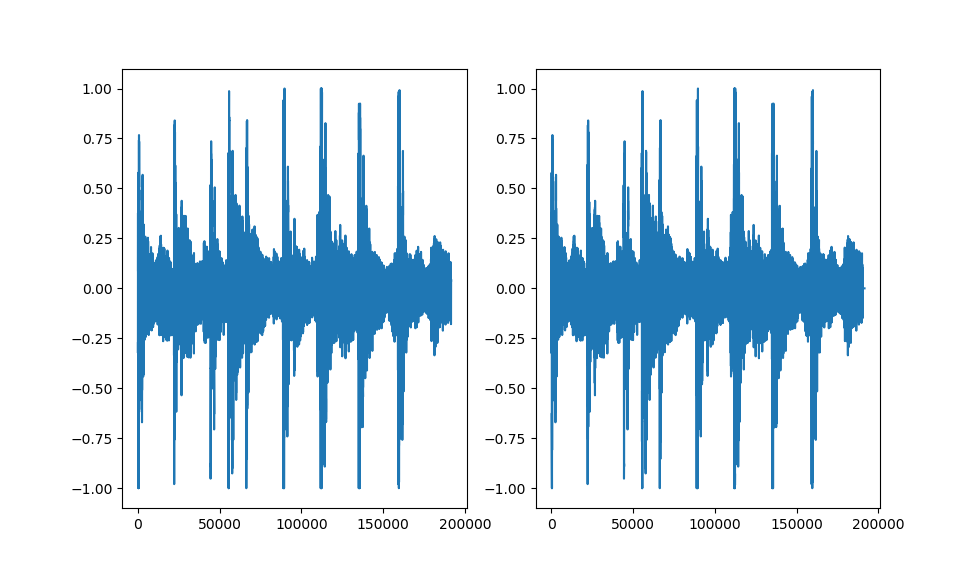

In [17]:
%matplotlib notebook

plt.subplot(1,2,1)
plt.plot(audio_mono)

plt.subplot(1,2,2)
plt.plot(np.sum(A, axis=1))
plt.show()

# Resolución del problema de *Compressed Sensing* con cvxpy

In [8]:
import cvxpy as cp
import gurobipy as gp

In [6]:
# Conocer los paquetes instalados
cp.installed_solvers()

['CBC', 'ECOS', 'ECOS_BB', 'GUROBI', 'MOSEK', 'OSQP', 'SCS']

## 1) Función objetivo de minimización de componentes

En este caso el problema de optimización se plantea de la forma:

$$\min_{\vec{x}} |\vec{x}|_1$$
$$\text{s.a}$$ $$ |A\vec{x} - y| \leq \epsilon$$

In [26]:
# Se define el rango de tolerancia de la optimización
epsilon = 0.5

# Se construye la variable
x = cp.Variable(A.shape[1])

# Se plantean las restricciones
constraints = [cp.abs(A*x - audio_mono) <= epsilon]

# Declaración de la función objetivo
obj = cp.Minimize(cp.norm(x, 1))

# Declaración del problema de optimización
opt_prob = cp.Problem(obj, constraints)

# Resolviendo...
opt_prob.solve(solver=cp.SCS, verbose=True)

(191487, 20)
(191487, 1)
----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 8193101
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 0, rho_x = 1.00e-03
Variables n = 191527, constraints m = 574501
Cones:	linear vars: 574501
WARN: aa_init returned NULL, no acceleration applied.
Setup time: 1.87e+00s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 5.35e+21  4.85e+21  1.00e+00 -1.24e+24  3.75e+18  2.09e+24  1.39e-01 
   100| 6.38e-03  1.02e-01  2.86e-02  4.42e+00  4.71e+00  6.80e-14  5.16e+00 
   200| 3.29e-03  6.12e-02  2.18e-0

5.254793765724755

In [8]:
# Se define el rango de tolerancia de la optimización
epsilon = 0.5

# Se construye la variable
x = cp.Variable(shape=(A.shape[1],))

# Se plantean las restricciones
constraints = [cp.abs(A*x - audio_mono) <= epsilon]

# Declaración de la función objetivo
obj = cp.Minimize(cp.norm(x, 1))

# Declaración del problema de optimización
opt_prob = cp.Problem(obj, constraints)

# Resolviendo...
opt_prob.solve(solver=cp.CBC, verbose=True, max_iters=1000)

SolverError: The solver CBC is not installed.

In [6]:
# Print result.
print("\nThe optimal value is", opt_prob.value)
print("A solution x is")
print(x.value)
print("A dual solution corresponding to the inequality constraints is")
print(opt_prob.constraints[0].dual_value)


The optimal value is 5.086017593749774
A solution x is
[-2.51593622e-03  8.94767226e-01  5.04191277e-01 -4.65342866e-04
 -6.33011279e-02  1.20456164e-02 -1.03668949e-03  2.30874740e-02
  8.93109442e-04  9.85498314e-02  7.18191339e-05  6.94758205e-01
 -2.77151851e-03 -9.07459904e-04  7.27829350e-01 -6.98760170e-03
  2.49252133e-01  1.42849369e-01  9.22433693e-01  8.29597789e-01]
A dual solution corresponding to the inequality constraints is
[1.46223997e-06 3.99024974e-01 2.19297505e-01 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


## 2) Función objetivo de minimización de error

En este caso el problema de optimización se plantea de la forma:

$$\min_{\vec{x}} |A\vec{x}- y|$$
$$s.a$$
$$|\vec{x}|_0 \leq L$$

In [15]:
# Se define el límite de variables a activar
L = 15

# Se construye la variable
x = cp.Variable(A.shape[1], boolean=True)

# Se plantean las restricciones
constraints = [sum(x) <= L]

# Declaración de la función objetivo
obj = cp.Minimize(cp.sum(cp.abs(A*x - audio_mono)))

# Declaración del problema de optimización
opt_prob = cp.Problem(obj, constraints)

# Resolviendo...
opt_prob.solve(solver=cp.GUROBI, verbose=True)

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Optimize a model with 382975 rows, 191507 columns and 7414846 nonzeros
Variable types: 191487 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e-13, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-07, 2e+01]
Found heuristic solution: objective 21304.190787
Found heuristic solution: objective 21304.185105
Presolve removed 3884 rows and 1942 columns (presolve time = 8s) ...
Presolve removed 3884 rows and 1942 columns (presolve time = 10s) ...
Presolve removed 3884 rows and 1942 columns (presolve time = 16s) ...
Presolve removed 3884 rows and 1942 columns (presolve time = 21s) ...
Presolve removed 3884 rows and 1942 columns (presolve time = 25s) ...
Presolve removed 3884 rows and 1942 

   21037   -2.4378763e+03   5.087805e+05   0.000000e+00    565s
   21287   -2.4207486e+03   2.967076e+04   0.000000e+00    572s
   21477   -2.4069115e+03   2.343514e+04   0.000000e+00    576s
   21657   -2.3951060e+03   1.362036e+06   0.000000e+00    581s
   21847   -2.3833928e+03   1.691842e+04   0.000000e+00    586s
   22027   -2.3700346e+03   9.797507e+03   0.000000e+00    590s
   22277   -2.3548072e+03   1.209288e+07   0.000000e+00    596s
   22457   -2.3427625e+03   1.010414e+04   0.000000e+00    601s
   22647   -2.3293006e+03   8.420427e+04   0.000000e+00    606s
   22897   -2.3126459e+03   5.859944e+04   0.000000e+00    612s
   23087   -2.2996077e+03   3.675824e+04   0.000000e+00    616s
   23267   -2.2872953e+03   1.397590e+04   0.000000e+00    620s
   23457   -2.2758904e+03   1.215443e+04   0.000000e+00    625s
   23657   -2.2617845e+03   1.258945e+04   0.000000e+00    630s
   23857   -2.2484765e+03   1.326937e+04   0.000000e+00    636s
   24037   -2.2379138e+03   1.813321e+04

   46727   -9.7772860e+02   5.366866e+04   0.000000e+00   1211s
   46907   -9.6932519e+02   1.131531e+04   0.000000e+00   1216s
   47097   -9.6064283e+02   4.306906e+04   0.000000e+00   1221s
   47287   -9.5233202e+02   1.960348e+04   0.000000e+00   1226s
   47467   -9.4377321e+02   1.383573e+04   0.000000e+00   1230s
   47667   -9.3441652e+02   2.491618e+05   0.000000e+00   1235s
   47907   -9.2284056e+02   1.010810e+06   0.000000e+00   1241s
   48087   -9.1494524e+02   1.189848e+04   0.000000e+00   1245s
   48287   -9.0578857e+02   1.031993e+04   0.000000e+00   1251s
   48487   -8.9578212e+02   6.460761e+04   0.000000e+00   1256s
   48717   -8.8531470e+02   4.348718e+04   0.000000e+00   1261s
   48907   -8.7603340e+02   1.917424e+04   0.000000e+00   1266s
   49097   -8.6747404e+02   9.260246e+03   0.000000e+00   1271s
   49277   -8.5880182e+02   2.043178e+04   0.000000e+00   1275s
   49467   -8.5070731e+02   4.303695e+05   0.000000e+00   1281s
   49677   -8.4071369e+02   8.541374e+03

   71917    4.6047172e+01   9.633332e+05   0.000000e+00   1856s
   72117    5.3039634e+01   1.813330e+04   0.000000e+00   1861s
   72317    5.9737490e+01   3.768644e+04   0.000000e+00   1867s
   72447    6.4562700e+01   5.379526e+04   0.000000e+00   1870s
   72707    7.3722152e+01   2.696895e+05   0.000000e+00   1877s
   72887    8.0642927e+01   2.726846e+04   0.000000e+00   1882s
   73017    8.4962518e+01   3.022972e+04   0.000000e+00   1885s
   73277    9.4251858e+01   2.875021e+04   0.000000e+00   1892s
   73507    1.0243320e+02   2.957531e+04   0.000000e+00   1897s
   73617    1.0624815e+02   4.177620e+05   0.000000e+00   1900s
   73817    1.1349052e+02   9.189364e+03   0.000000e+00   1906s
   73997    1.2015959e+02   2.021366e+05   0.000000e+00   1910s
   74227    1.2866055e+02   1.851911e+04   0.000000e+00   1916s
   74397    1.3487517e+02   2.340789e+04   0.000000e+00   1920s
   74597    1.4150922e+02   2.803421e+04   0.000000e+00   1926s
   74787    1.4775835e+02   6.854243e+04

   96787    8.5927953e+02   2.278733e+05   0.000000e+00   2501s
   97027    8.6695432e+02   7.994549e+03   0.000000e+00   2509s
   97137    8.7031341e+02   1.000776e+04   0.000000e+00   2513s
   97257    8.7371159e+02   2.644974e+04   0.000000e+00   2518s
   97387    8.7773909e+02   1.156020e+04   0.000000e+00   2521s
   97567    8.8284236e+02   9.282366e+03   0.000000e+00   2527s
   97677    8.8619209e+02   5.865759e+04   0.000000e+00   2531s
   97797    8.8966749e+02   6.152306e+03   0.000000e+00   2536s
   98017    8.9660726e+02   1.706460e+05   0.000000e+00   2542s
   98147    9.0051995e+02   1.500810e+04   0.000000e+00   2546s
   98347    9.0639197e+02   5.456917e+03   0.000000e+00   2551s
   98537    9.1198372e+02   8.059882e+03   0.000000e+00   2556s
   98747    9.1817303e+02   8.299373e+03   0.000000e+00   2561s
   98987    9.2481542e+02   4.683000e+04   0.000000e+00   2568s
   99117    9.2858317e+02   4.754548e+03   0.000000e+00   2571s
   99327    9.3394245e+02   1.114552e+05

  121227    1.4929351e+03   6.337223e+04   0.000000e+00   3146s
  121407    1.4973493e+03   6.875897e+03   0.000000e+00   3150s
  121587    1.5014445e+03   9.483548e+03   0.000000e+00   3155s
  121837    1.5074673e+03   1.883276e+04   0.000000e+00   3161s
  122027    1.5119263e+03   2.917122e+04   0.000000e+00   3166s
  122217    1.5165035e+03   7.519359e+03   0.000000e+00   3171s
  122417    1.5211127e+03   2.100745e+04   0.000000e+00   3176s
  122637    1.5262708e+03   6.589337e+03   0.000000e+00   3182s
  122847    1.5305929e+03   2.239093e+04   0.000000e+00   3187s
  122987    1.5338676e+03   5.526682e+03   0.000000e+00   3191s
  123177    1.5378749e+03   2.404827e+04   0.000000e+00   3196s
  123367    1.5416239e+03   1.581516e+04   0.000000e+00   3202s
  123547    1.5453476e+03   5.597712e+03   0.000000e+00   3207s
  123797    1.5512927e+03   4.214614e+04   0.000000e+00   3213s
  123867    1.5527042e+03   1.225480e+04   0.000000e+00   3215s
  124057    1.5568799e+03   2.429252e+04

  142867    1.9459145e+03   1.647599e+04   0.000000e+00   3792s
  143027    1.9485285e+03   9.842429e+04   0.000000e+00   3796s
  143227    1.9515943e+03   4.204919e+03   0.000000e+00   3803s
  143357    1.9538978e+03   6.924364e+03   0.000000e+00   3807s
  143547    1.9573715e+03   2.693865e+03   0.000000e+00   3812s
  143747    1.9609101e+03   1.110396e+04   0.000000e+00   3818s
  143917    1.9642374e+03   5.107116e+03   0.000000e+00   3823s
  144057    1.9667424e+03   1.393501e+04   0.000000e+00   3828s
  144177    1.9687246e+03   7.139919e+03   0.000000e+00   3831s
  144437    1.9734216e+03   4.841690e+03   0.000000e+00   3838s
  144557    1.9754787e+03   3.844918e+03   0.000000e+00   3842s
  144697    1.9779603e+03   6.625381e+05   0.000000e+00   3845s
  144947    1.9824743e+03   3.873100e+03   0.000000e+00   3852s
  145207    1.9872999e+03   1.294136e+04   0.000000e+00   3858s
  145347    1.9898151e+03   3.688901e+05   0.000000e+00   3862s
  145477    1.9922209e+03   5.940311e+04

  166587    2.3444550e+03   2.259705e+04   0.000000e+00   4435s
  166827    2.3487459e+03   2.079683e+03   0.000000e+00   4443s
  166897    2.3497551e+03   2.046366e+03   0.000000e+00   4446s
  167017    2.3518730e+03   1.907466e+03   0.000000e+00   4450s
  167207    2.3548228e+03   4.522289e+05   0.000000e+00   4457s
  167347    2.3569499e+03   1.161264e+04   0.000000e+00   4462s
  167477    2.3589154e+03   2.399593e+03   0.000000e+00   4466s
  167617    2.3612124e+03   8.301297e+03   0.000000e+00   4471s
  167797    2.3641709e+03   1.237698e+05   0.000000e+00   4476s
  167997    2.3674291e+03   2.815944e+03   0.000000e+00   4483s
  168127    2.3692644e+03   8.106598e+03   0.000000e+00   4488s
  168247    2.3710550e+03   1.097919e+04   0.000000e+00   4491s
  168497    2.3747687e+03   2.303810e+03   0.000000e+00   4498s
  168627    2.3767972e+03   4.244925e+03   0.000000e+00   4502s
  168817    2.3799423e+03   2.132694e+03   0.000000e+00   4508s
  169017    2.3831303e+03   6.855236e+03

  188997    2.6693360e+03   1.954235e+05   0.000000e+00   5086s
  189247    2.6729452e+03   6.750895e+03   0.000000e+00   5092s
  189387    2.6746960e+03   6.238359e+03   0.000000e+00   5096s
  189577    2.6774028e+03   6.091980e+04   0.000000e+00   5101s
  189827    2.6805651e+03   2.595974e+03   0.000000e+00   5108s
  189967    2.6823944e+03   3.426191e+03   0.000000e+00   5111s
  190237    2.6860405e+03   2.263165e+03   0.000000e+00   5118s
  190317    2.6871461e+03   4.297492e+03   0.000000e+00   5120s
  190577    2.6908346e+03   2.459577e+03   0.000000e+00   5127s
  190727    2.6928708e+03   9.289134e+04   0.000000e+00   5131s
  190977    2.6958432e+03   4.241965e+03   0.000000e+00   5138s
  191117    2.6978171e+03   1.914267e+04   0.000000e+00   5142s
  191257    2.6998414e+03   3.228340e+03   0.000000e+00   5145s
  191547    2.7038152e+03   6.834386e+04   0.000000e+00   5152s
  191677    2.7054867e+03   8.215225e+03   0.000000e+00   5155s
  191947    2.7089217e+03   2.049538e+04

  213497    2.9582844e+03   2.351937e+03   0.000000e+00   5731s
  213637    2.9597296e+03   6.421982e+04   0.000000e+00   5735s
  213927    2.9626668e+03   1.161125e+03   0.000000e+00   5742s
  214067    2.9642343e+03   5.666083e+04   0.000000e+00   5745s
  214347    2.9670985e+03   2.017455e+04   0.000000e+00   5753s
  214497    2.9684719e+03   5.959637e+03   0.000000e+00   5757s
  214627    2.9696859e+03   3.029372e+03   0.000000e+00   5760s
  214867    2.9718524e+03   2.295371e+03   0.000000e+00   5767s
  215007    2.9733756e+03   1.605184e+03   0.000000e+00   5771s
  215167    2.9750703e+03   1.045223e+05   0.000000e+00   5776s
  215387    2.9770745e+03   5.897586e+03   0.000000e+00   5782s
  215527    2.9783007e+03   1.417722e+03   0.000000e+00   5785s
  215767    2.9803399e+03   1.803550e+04   0.000000e+00   5792s
  215887    2.9816753e+03   1.317943e+03   0.000000e+00   5796s
  216177    2.9845809e+03   2.388394e+03   0.000000e+00   5803s
  216267    2.9852536e+03   2.431260e+03

  240167    3.1856530e+03   3.395775e+04   0.000000e+00   6376s
  240467    3.1877943e+03   5.713915e+02   0.000000e+00   6383s
  240617    3.1889132e+03   2.635277e+04   0.000000e+00   6387s
  240777    3.1900628e+03   6.310824e+03   0.000000e+00   6391s
  241067    3.1921302e+03   1.069440e+04   0.000000e+00   6398s
  241227    3.1932802e+03   4.131091e+03   0.000000e+00   6401s
  241517    3.1953654e+03   1.114459e+03   0.000000e+00   6409s
  241667    3.1963644e+03   4.097840e+04   0.000000e+00   6413s
  241817    3.1975286e+03   7.861292e+02   0.000000e+00   6416s
  242117    3.1994376e+03   1.943819e+05   0.000000e+00   6423s
  242257    3.2004385e+03   2.239707e+03   0.000000e+00   6426s
  242567    3.2025866e+03   2.868616e+04   0.000000e+00   6433s
  242707    3.2035246e+03   2.408980e+03   0.000000e+00   6437s
  242857    3.2045919e+03   1.592292e+04   0.000000e+00   6440s
  243147    3.2064748e+03   4.438767e+03   0.000000e+00   6447s
  243297    3.2075940e+03   3.649698e+03

  267927    3.3507914e+03   4.014790e+03   0.000000e+00   7022s
  268097    3.3515390e+03   2.384142e+04   0.000000e+00   7026s
  268387    3.3529164e+03   1.846103e+04   0.000000e+00   7032s
  268527    3.3536470e+03   4.504755e+03   0.000000e+00   7035s
  268777    3.3547876e+03   2.012323e+04   0.000000e+00   7041s
  269067    3.3561953e+03   8.256357e+02   0.000000e+00   7047s
  269217    3.3568792e+03   5.909695e+03   0.000000e+00   7051s
  269527    3.3583957e+03   1.035570e+04   0.000000e+00   7058s
  269677    3.3590917e+03   7.749000e+03   0.000000e+00   7061s
  269977    3.3605368e+03   2.463349e+02   0.000000e+00   7067s
  270137    3.3611862e+03   2.216223e+02   0.000000e+00   7071s
  270437    3.3624692e+03   1.182014e+03   0.000000e+00   7078s
  270607    3.3632066e+03   7.936447e+03   0.000000e+00   7082s
  270767    3.3639460e+03   7.323820e+03   0.000000e+00   7085s
  271077    3.3655698e+03   4.891450e+02   0.000000e+00   7092s
  271237    3.3662597e+03   1.648122e+03

  298357    3.4623859e+03   7.254004e+01   0.000000e+00   7668s
  298517    3.4628383e+03   1.218680e+02   0.000000e+00   7671s
  298847    3.4636676e+03   9.164004e+01   0.000000e+00   7678s
  299017    3.4640773e+03   2.925742e+03   0.000000e+00   7681s
  299327    3.4649073e+03   7.626531e+03   0.000000e+00   7687s
  299657    3.4658596e+03   3.822186e+04   0.000000e+00   7693s
  299807    3.4662087e+03   5.184247e+02   0.000000e+00   7696s
  300127    3.4669614e+03   6.479156e+01   0.000000e+00   7702s
  300287    3.4673454e+03   2.126450e+02   0.000000e+00   7706s
  300607    3.4681081e+03   4.214409e+02   0.000000e+00   7712s
  300767    3.4684976e+03   1.271744e+02   0.000000e+00   7715s
  301087    3.4692266e+03   9.929414e+02   0.000000e+00   7722s
  301247    3.4695913e+03   3.103369e+03   0.000000e+00   7725s
  301567    3.4703179e+03   1.096177e+03   0.000000e+00   7732s
  301737    3.4706794e+03   2.230280e+02   0.000000e+00   7735s
  302067    3.4714246e+03   1.416504e+02

  332047    3.5080536e+03   2.978552e+00   0.000000e+00   8311s
  332347    3.5080878e+03   3.729220e+01   0.000000e+00   8316s
  332657    3.5081179e+03   3.352444e-01   0.000000e+00   8321s
  332967    3.5081419e+03   4.926793e-01   0.000000e+00   8326s
  333277    3.5081603e+03   3.394084e-02   0.000000e+00   8332s
  333587    3.5081741e+03   6.054235e-02   0.000000e+00   8336s
  333877    3.5081812e+03   1.692369e+00   0.000000e+00   8341s
  334177    3.5081843e+03   2.957959e-04   0.000000e+00   8346s
  334208    3.5081843e+03   0.000000e+00   0.000000e+00   8347s

Root relaxation: objective 3.508184e+03, 334208 iterations, 8312.96 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3508.18433    0   10 21304.1851 3508.18433  83.5%     - 8350s
H    0     0                    3575.4191701 3508.18433  1.88%     - 8354s
     0     0 3566.54695    0   12 3575.41917 

3575.418069967111

In [17]:
# Print result.
print("\nThe optimal value is", opt_prob.value)
print("A solution x is")
print(x.value)
print("A dual solution corresponding to the inequality constraints is")
print(opt_prob.constraints[0].dual_value)
print(f"Suma de x: {sum(x.value)}")


The optimal value is 3575.418069967111
A solution x is
[ 1.  1.  1.  1.  1.  1. -0.  1.  1. -0. -0. -0.  1.  1.  1.  1.  1. -0.
  1.  1.]
A dual solution corresponding to the inequality constraints is
None
Suma de x: 15.0


In [10]:
help(cp.expressions.variable.Variable)

Help on class Variable in module cvxpy.expressions.variable:

class Variable(cvxpy.expressions.leaf.Leaf)
 |  The optimization variables in a problem.
 |  
 |  Method resolution order:
 |      Variable
 |      cvxpy.expressions.leaf.Leaf
 |      cvxpy.expressions.expression.Expression
 |      cvxpy.utilities.canonical.Canonical
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, shape=(), name=None, var_id=None, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__(self)
 |      String to recreate the object.
 |  
 |  canonicalize(self)
 |      Returns the graph implementation of the object.
 |      
 |      Returns:
 |          A tuple of (affine expression, [constraints]).
 |  
 |  is_constant(self)
 |      Is the expression constant?
 |  
 |  name(self)
 |      str : The name of the variable.
 |  
 |  variables(self)
 |      Returns itself as a variable.
 |  
 |  -------------------------------------------------

## 3) Utilización de solver exhaustivo

In [33]:
def exhaustive_solver(A, b, limit=5):
    # Obtener la dimensión de la matriz A
    _, q_vars = A.shape

    # Definición del error hasta ese momento
    error_opt = np.inf
    # Definición de la combinación que genera error mínimo
    comb_opt = None

    # Combinaciones posibles
    gen_comb = combinations(range(q_vars), limit)
    
    # Definición de los índices del vector a considerar
    for i in gen_comb:
        print(f"Probando combinación {i}...")
        
        # Plantilla de la combinación de pistas
        comb_i = np.zeros(q_vars)
        np.put(comb_i, i, [1]*len(i))

        # Si la diferencia es menor que el error definido actualmente,
        # esa solución es mejor que la anterior, por lo que se
        # actualiza esta información
        if (sum(np.abs(np.matmul(A, comb_i) - b)) < error_opt):
            # Actualizando los valores
            error_opt = sum(np.abs(np.matmul(A, comb_i) - b))
            comb_opt = comb_i
            print(f"Mejor combinación actualizada: Combinación -> {comb_opt}, Error = {error_opt}")

    return comb_opt, error_opt

In [ ]:
comb_opt, error_opt = exhaustive_solver(A, audio_mono, limit=7)

Probando combinación (0, 1, 2, 3, 4, 5, 6)...
Mejor combinación actualizada: Combinación -> [1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], Error = 14210.679487631736
Probando combinación (0, 1, 2, 3, 4, 5, 7)...
Mejor combinación actualizada: Combinación -> [1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], Error = 13651.33977917948
Probando combinación (0, 1, 2, 3, 4, 5, 8)...
Probando combinación (0, 1, 2, 3, 4, 5, 9)...
Probando combinación (0, 1, 2, 3, 4, 5, 10)...
Probando combinación (0, 1, 2, 3, 4, 5, 11)...
Probando combinación (0, 1, 2, 3, 4, 5, 12)...
Mejor combinación actualizada: Combinación -> [1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], Error = 13628.407960995499
Probando combinación (0, 1, 2, 3, 4, 5, 13)...
Mejor combinación actualizada: Combinación -> [1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], Error = 13512.90267211099
Probando combinación (0, 1, 2, 3, 4, 5, 14)...
Mejor combinación actualizada: Combinac

Probando combinación (0, 1, 2, 3, 5, 11, 14)...
Probando combinación (0, 1, 2, 3, 5, 11, 15)...
Probando combinación (0, 1, 2, 3, 5, 11, 16)...
Probando combinación (0, 1, 2, 3, 5, 11, 17)...
Probando combinación (0, 1, 2, 3, 5, 11, 18)...
Probando combinación (0, 1, 2, 3, 5, 11, 19)...
Probando combinación (0, 1, 2, 3, 5, 12, 13)...
Probando combinación (0, 1, 2, 3, 5, 12, 14)...
Probando combinación (0, 1, 2, 3, 5, 12, 15)...
Probando combinación (0, 1, 2, 3, 5, 12, 16)...
Probando combinación (0, 1, 2, 3, 5, 12, 17)...
Probando combinación (0, 1, 2, 3, 5, 12, 18)...
Probando combinación (0, 1, 2, 3, 5, 12, 19)...
Probando combinación (0, 1, 2, 3, 5, 13, 14)...
Probando combinación (0, 1, 2, 3, 5, 13, 15)...
Probando combinación (0, 1, 2, 3, 5, 13, 16)...
Probando combinación (0, 1, 2, 3, 5, 13, 17)...
Probando combinación (0, 1, 2, 3, 5, 13, 18)...
Probando combinación (0, 1, 2, 3, 5, 13, 19)...
Probando combinación (0, 1, 2, 3, 5, 14, 15)...
Probando combinación (0, 1, 2, 3, 5, 14,

Probando combinación (0, 1, 2, 3, 7, 16, 18)...
Probando combinación (0, 1, 2, 3, 7, 16, 19)...
Probando combinación (0, 1, 2, 3, 7, 17, 18)...
Probando combinación (0, 1, 2, 3, 7, 17, 19)...
Probando combinación (0, 1, 2, 3, 7, 18, 19)...
Probando combinación (0, 1, 2, 3, 8, 9, 10)...
Probando combinación (0, 1, 2, 3, 8, 9, 11)...
Probando combinación (0, 1, 2, 3, 8, 9, 12)...
Probando combinación (0, 1, 2, 3, 8, 9, 13)...
Probando combinación (0, 1, 2, 3, 8, 9, 14)...
Probando combinación (0, 1, 2, 3, 8, 9, 15)...
Probando combinación (0, 1, 2, 3, 8, 9, 16)...
Probando combinación (0, 1, 2, 3, 8, 9, 17)...
Probando combinación (0, 1, 2, 3, 8, 9, 18)...
Probando combinación (0, 1, 2, 3, 8, 9, 19)...
Probando combinación (0, 1, 2, 3, 8, 10, 11)...
Probando combinación (0, 1, 2, 3, 8, 10, 12)...
Probando combinación (0, 1, 2, 3, 8, 10, 13)...
Probando combinación (0, 1, 2, 3, 8, 10, 14)...
Probando combinación (0, 1, 2, 3, 8, 10, 15)...
Probando combinación (0, 1, 2, 3, 8, 10, 16)...
Pr

Probando combinación (0, 1, 2, 3, 12, 13, 16)...
Probando combinación (0, 1, 2, 3, 12, 13, 17)...
Probando combinación (0, 1, 2, 3, 12, 13, 18)...
Probando combinación (0, 1, 2, 3, 12, 13, 19)...
Probando combinación (0, 1, 2, 3, 12, 14, 15)...
Probando combinación (0, 1, 2, 3, 12, 14, 16)...
Probando combinación (0, 1, 2, 3, 12, 14, 17)...
Probando combinación (0, 1, 2, 3, 12, 14, 18)...
Probando combinación (0, 1, 2, 3, 12, 14, 19)...
Probando combinación (0, 1, 2, 3, 12, 15, 16)...
Probando combinación (0, 1, 2, 3, 12, 15, 17)...
Probando combinación (0, 1, 2, 3, 12, 15, 18)...
Probando combinación (0, 1, 2, 3, 12, 15, 19)...
Probando combinación (0, 1, 2, 3, 12, 16, 17)...
Probando combinación (0, 1, 2, 3, 12, 16, 18)...
Probando combinación (0, 1, 2, 3, 12, 16, 19)...
Probando combinación (0, 1, 2, 3, 12, 17, 18)...
Probando combinación (0, 1, 2, 3, 12, 17, 19)...
Probando combinación (0, 1, 2, 3, 12, 18, 19)...
Probando combinación (0, 1, 2, 3, 13, 14, 15)...
Probando combinación

Probando combinación (0, 1, 2, 4, 6, 8, 19)...
Probando combinación (0, 1, 2, 4, 6, 9, 10)...
Probando combinación (0, 1, 2, 4, 6, 9, 11)...
Probando combinación (0, 1, 2, 4, 6, 9, 12)...
Probando combinación (0, 1, 2, 4, 6, 9, 13)...
Probando combinación (0, 1, 2, 4, 6, 9, 14)...
Probando combinación (0, 1, 2, 4, 6, 9, 15)...
Probando combinación (0, 1, 2, 4, 6, 9, 16)...
Probando combinación (0, 1, 2, 4, 6, 9, 17)...
Probando combinación (0, 1, 2, 4, 6, 9, 18)...
Probando combinación (0, 1, 2, 4, 6, 9, 19)...
Probando combinación (0, 1, 2, 4, 6, 10, 11)...
Probando combinación (0, 1, 2, 4, 6, 10, 12)...
Probando combinación (0, 1, 2, 4, 6, 10, 13)...
Probando combinación (0, 1, 2, 4, 6, 10, 14)...
Probando combinación (0, 1, 2, 4, 6, 10, 15)...
Probando combinación (0, 1, 2, 4, 6, 10, 16)...
Probando combinación (0, 1, 2, 4, 6, 10, 17)...
Probando combinación (0, 1, 2, 4, 6, 10, 18)...
Probando combinación (0, 1, 2, 4, 6, 10, 19)...
Probando combinación (0, 1, 2, 4, 6, 11, 12)...
Pro

Probando combinación (0, 1, 2, 4, 8, 16, 18)...
Probando combinación (0, 1, 2, 4, 8, 16, 19)...
Probando combinación (0, 1, 2, 4, 8, 17, 18)...
Probando combinación (0, 1, 2, 4, 8, 17, 19)...
Probando combinación (0, 1, 2, 4, 8, 18, 19)...
Probando combinación (0, 1, 2, 4, 9, 10, 11)...
Probando combinación (0, 1, 2, 4, 9, 10, 12)...
Probando combinación (0, 1, 2, 4, 9, 10, 13)...
Probando combinación (0, 1, 2, 4, 9, 10, 14)...
Probando combinación (0, 1, 2, 4, 9, 10, 15)...
Probando combinación (0, 1, 2, 4, 9, 10, 16)...
Probando combinación (0, 1, 2, 4, 9, 10, 17)...
Probando combinación (0, 1, 2, 4, 9, 10, 18)...
Probando combinación (0, 1, 2, 4, 9, 10, 19)...
Probando combinación (0, 1, 2, 4, 9, 11, 12)...
Probando combinación (0, 1, 2, 4, 9, 11, 13)...
Probando combinación (0, 1, 2, 4, 9, 11, 14)...
Probando combinación (0, 1, 2, 4, 9, 11, 15)...
Probando combinación (0, 1, 2, 4, 9, 11, 16)...
Probando combinación (0, 1, 2, 4, 9, 11, 17)...
Probando combinación (0, 1, 2, 4, 9, 11,

Probando combinación (0, 1, 2, 4, 17, 18, 19)...
Probando combinación (0, 1, 2, 5, 6, 7, 8)...
Probando combinación (0, 1, 2, 5, 6, 7, 9)...
Probando combinación (0, 1, 2, 5, 6, 7, 10)...
Probando combinación (0, 1, 2, 5, 6, 7, 11)...
Probando combinación (0, 1, 2, 5, 6, 7, 12)...
Probando combinación (0, 1, 2, 5, 6, 7, 13)...
Probando combinación (0, 1, 2, 5, 6, 7, 14)...
Probando combinación (0, 1, 2, 5, 6, 7, 15)...
Probando combinación (0, 1, 2, 5, 6, 7, 16)...
Probando combinación (0, 1, 2, 5, 6, 7, 17)...
Probando combinación (0, 1, 2, 5, 6, 7, 18)...
Probando combinación (0, 1, 2, 5, 6, 7, 19)...
Probando combinación (0, 1, 2, 5, 6, 8, 9)...
Probando combinación (0, 1, 2, 5, 6, 8, 10)...
Probando combinación (0, 1, 2, 5, 6, 8, 11)...
Probando combinación (0, 1, 2, 5, 6, 8, 12)...
Probando combinación (0, 1, 2, 5, 6, 8, 13)...
Probando combinación (0, 1, 2, 5, 6, 8, 14)...
Probando combinación (0, 1, 2, 5, 6, 8, 15)...
Probando combinación (0, 1, 2, 5, 6, 8, 16)...
Probando combi

Probando combinación (0, 1, 2, 5, 8, 12, 14)...
Probando combinación (0, 1, 2, 5, 8, 12, 15)...
Probando combinación (0, 1, 2, 5, 8, 12, 16)...
Probando combinación (0, 1, 2, 5, 8, 12, 17)...
Probando combinación (0, 1, 2, 5, 8, 12, 18)...
Probando combinación (0, 1, 2, 5, 8, 12, 19)...
Probando combinación (0, 1, 2, 5, 8, 13, 14)...
Probando combinación (0, 1, 2, 5, 8, 13, 15)...
Probando combinación (0, 1, 2, 5, 8, 13, 16)...
Probando combinación (0, 1, 2, 5, 8, 13, 17)...
Probando combinación (0, 1, 2, 5, 8, 13, 18)...
Probando combinación (0, 1, 2, 5, 8, 13, 19)...
Probando combinación (0, 1, 2, 5, 8, 14, 15)...
Probando combinación (0, 1, 2, 5, 8, 14, 16)...
Probando combinación (0, 1, 2, 5, 8, 14, 17)...
Probando combinación (0, 1, 2, 5, 8, 14, 18)...
Probando combinación (0, 1, 2, 5, 8, 14, 19)...
Probando combinación (0, 1, 2, 5, 8, 15, 16)...
Probando combinación (0, 1, 2, 5, 8, 15, 17)...
Probando combinación (0, 1, 2, 5, 8, 15, 18)...
Probando combinación (0, 1, 2, 5, 8, 15,

Probando combinación (0, 1, 2, 5, 13, 17, 19)...
Probando combinación (0, 1, 2, 5, 13, 18, 19)...
Probando combinación (0, 1, 2, 5, 14, 15, 16)...
Probando combinación (0, 1, 2, 5, 14, 15, 17)...
Probando combinación (0, 1, 2, 5, 14, 15, 18)...
Probando combinación (0, 1, 2, 5, 14, 15, 19)...
Probando combinación (0, 1, 2, 5, 14, 16, 17)...
Probando combinación (0, 1, 2, 5, 14, 16, 18)...
Probando combinación (0, 1, 2, 5, 14, 16, 19)...
Probando combinación (0, 1, 2, 5, 14, 17, 18)...
Probando combinación (0, 1, 2, 5, 14, 17, 19)...
Probando combinación (0, 1, 2, 5, 14, 18, 19)...
Probando combinación (0, 1, 2, 5, 15, 16, 17)...
Probando combinación (0, 1, 2, 5, 15, 16, 18)...
Probando combinación (0, 1, 2, 5, 15, 16, 19)...
Probando combinación (0, 1, 2, 5, 15, 17, 18)...
Probando combinación (0, 1, 2, 5, 15, 17, 19)...
Probando combinación (0, 1, 2, 5, 15, 18, 19)...
Probando combinación (0, 1, 2, 5, 16, 17, 18)...
Probando combinación (0, 1, 2, 5, 16, 17, 19)...
Probando combinación

Probando combinación (0, 1, 2, 6, 9, 13, 18)...
Probando combinación (0, 1, 2, 6, 9, 13, 19)...
Probando combinación (0, 1, 2, 6, 9, 14, 15)...
Probando combinación (0, 1, 2, 6, 9, 14, 16)...
Probando combinación (0, 1, 2, 6, 9, 14, 17)...
Probando combinación (0, 1, 2, 6, 9, 14, 18)...
Probando combinación (0, 1, 2, 6, 9, 14, 19)...
Probando combinación (0, 1, 2, 6, 9, 15, 16)...
Probando combinación (0, 1, 2, 6, 9, 15, 17)...
Probando combinación (0, 1, 2, 6, 9, 15, 18)...
Probando combinación (0, 1, 2, 6, 9, 15, 19)...
Probando combinación (0, 1, 2, 6, 9, 16, 17)...
Probando combinación (0, 1, 2, 6, 9, 16, 18)...
Probando combinación (0, 1, 2, 6, 9, 16, 19)...
Probando combinación (0, 1, 2, 6, 9, 17, 18)...
Probando combinación (0, 1, 2, 6, 9, 17, 19)...
Probando combinación (0, 1, 2, 6, 9, 18, 19)...
Probando combinación (0, 1, 2, 6, 10, 11, 12)...
Probando combinación (0, 1, 2, 6, 10, 11, 13)...
Probando combinación (0, 1, 2, 6, 10, 11, 14)...
Probando combinación (0, 1, 2, 6, 10,

Probando combinación (0, 1, 2, 7, 8, 12, 18)...
Probando combinación (0, 1, 2, 7, 8, 12, 19)...
Probando combinación (0, 1, 2, 7, 8, 13, 14)...
Probando combinación (0, 1, 2, 7, 8, 13, 15)...
Probando combinación (0, 1, 2, 7, 8, 13, 16)...
Probando combinación (0, 1, 2, 7, 8, 13, 17)...
Probando combinación (0, 1, 2, 7, 8, 13, 18)...
Probando combinación (0, 1, 2, 7, 8, 13, 19)...
Probando combinación (0, 1, 2, 7, 8, 14, 15)...
Probando combinación (0, 1, 2, 7, 8, 14, 16)...
Probando combinación (0, 1, 2, 7, 8, 14, 17)...
Probando combinación (0, 1, 2, 7, 8, 14, 18)...
Probando combinación (0, 1, 2, 7, 8, 14, 19)...
Probando combinación (0, 1, 2, 7, 8, 15, 16)...
Probando combinación (0, 1, 2, 7, 8, 15, 17)...
Probando combinación (0, 1, 2, 7, 8, 15, 18)...
Probando combinación (0, 1, 2, 7, 8, 15, 19)...
Probando combinación (0, 1, 2, 7, 8, 16, 17)...
Probando combinación (0, 1, 2, 7, 8, 16, 18)...
Probando combinación (0, 1, 2, 7, 8, 16, 19)...
Probando combinación (0, 1, 2, 7, 8, 17,

Probando combinación (0, 1, 2, 7, 14, 15, 18)...
Probando combinación (0, 1, 2, 7, 14, 15, 19)...
Probando combinación (0, 1, 2, 7, 14, 16, 17)...
Probando combinación (0, 1, 2, 7, 14, 16, 18)...
Probando combinación (0, 1, 2, 7, 14, 16, 19)...
Probando combinación (0, 1, 2, 7, 14, 17, 18)...
Probando combinación (0, 1, 2, 7, 14, 17, 19)...
Probando combinación (0, 1, 2, 7, 14, 18, 19)...
Probando combinación (0, 1, 2, 7, 15, 16, 17)...
Probando combinación (0, 1, 2, 7, 15, 16, 18)...
Probando combinación (0, 1, 2, 7, 15, 16, 19)...
Probando combinación (0, 1, 2, 7, 15, 17, 18)...
Probando combinación (0, 1, 2, 7, 15, 17, 19)...
Probando combinación (0, 1, 2, 7, 15, 18, 19)...
Probando combinación (0, 1, 2, 7, 16, 17, 18)...
Probando combinación (0, 1, 2, 7, 16, 17, 19)...
Probando combinación (0, 1, 2, 7, 16, 18, 19)...
Probando combinación (0, 1, 2, 7, 17, 18, 19)...
Probando combinación (0, 1, 2, 8, 9, 10, 11)...
Probando combinación (0, 1, 2, 8, 9, 10, 12)...
Probando combinación (

Probando combinación (0, 1, 2, 8, 14, 16, 19)...
Probando combinación (0, 1, 2, 8, 14, 17, 18)...
Probando combinación (0, 1, 2, 8, 14, 17, 19)...
Probando combinación (0, 1, 2, 8, 14, 18, 19)...
Probando combinación (0, 1, 2, 8, 15, 16, 17)...
Probando combinación (0, 1, 2, 8, 15, 16, 18)...
Probando combinación (0, 1, 2, 8, 15, 16, 19)...
Probando combinación (0, 1, 2, 8, 15, 17, 18)...
Probando combinación (0, 1, 2, 8, 15, 17, 19)...
Probando combinación (0, 1, 2, 8, 15, 18, 19)...
Probando combinación (0, 1, 2, 8, 16, 17, 18)...
Probando combinación (0, 1, 2, 8, 16, 17, 19)...
Probando combinación (0, 1, 2, 8, 16, 18, 19)...
Probando combinación (0, 1, 2, 8, 17, 18, 19)...
Probando combinación (0, 1, 2, 9, 10, 11, 12)...
Probando combinación (0, 1, 2, 9, 10, 11, 13)...
Probando combinación (0, 1, 2, 9, 10, 11, 14)...
Probando combinación (0, 1, 2, 9, 10, 11, 15)...
Probando combinación (0, 1, 2, 9, 10, 11, 16)...
Probando combinación (0, 1, 2, 9, 10, 11, 17)...
Probando combinación

Probando combinación (0, 1, 2, 10, 12, 14, 15)...
Probando combinación (0, 1, 2, 10, 12, 14, 16)...
Probando combinación (0, 1, 2, 10, 12, 14, 17)...
Probando combinación (0, 1, 2, 10, 12, 14, 18)...
Probando combinación (0, 1, 2, 10, 12, 14, 19)...
Probando combinación (0, 1, 2, 10, 12, 15, 16)...
Probando combinación (0, 1, 2, 10, 12, 15, 17)...
Probando combinación (0, 1, 2, 10, 12, 15, 18)...
Probando combinación (0, 1, 2, 10, 12, 15, 19)...
Probando combinación (0, 1, 2, 10, 12, 16, 17)...
Probando combinación (0, 1, 2, 10, 12, 16, 18)...
Probando combinación (0, 1, 2, 10, 12, 16, 19)...
Probando combinación (0, 1, 2, 10, 12, 17, 18)...
Probando combinación (0, 1, 2, 10, 12, 17, 19)...
Probando combinación (0, 1, 2, 10, 12, 18, 19)...
Probando combinación (0, 1, 2, 10, 13, 14, 15)...
Probando combinación (0, 1, 2, 10, 13, 14, 16)...
Probando combinación (0, 1, 2, 10, 13, 14, 17)...
Probando combinación (0, 1, 2, 10, 13, 14, 18)...
Probando combinación (0, 1, 2, 10, 13, 14, 19)...


Probando combinación (0, 1, 2, 14, 15, 17, 18)...
Probando combinación (0, 1, 2, 14, 15, 17, 19)...
Probando combinación (0, 1, 2, 14, 15, 18, 19)...
Probando combinación (0, 1, 2, 14, 16, 17, 18)...
Probando combinación (0, 1, 2, 14, 16, 17, 19)...
Probando combinación (0, 1, 2, 14, 16, 18, 19)...
Probando combinación (0, 1, 2, 14, 17, 18, 19)...
Probando combinación (0, 1, 2, 15, 16, 17, 18)...
Probando combinación (0, 1, 2, 15, 16, 17, 19)...
Probando combinación (0, 1, 2, 15, 16, 18, 19)...
Probando combinación (0, 1, 2, 15, 17, 18, 19)...
Probando combinación (0, 1, 2, 16, 17, 18, 19)...
Probando combinación (0, 1, 3, 4, 5, 6, 7)...
Probando combinación (0, 1, 3, 4, 5, 6, 8)...
Probando combinación (0, 1, 3, 4, 5, 6, 9)...
Probando combinación (0, 1, 3, 4, 5, 6, 10)...
Probando combinación (0, 1, 3, 4, 5, 6, 11)...
Probando combinación (0, 1, 3, 4, 5, 6, 12)...
Probando combinación (0, 1, 3, 4, 5, 6, 13)...
Probando combinación (0, 1, 3, 4, 5, 6, 14)...
Probando combinación (0, 1,

Probando combinación (0, 1, 3, 4, 6, 15, 19)...
Probando combinación (0, 1, 3, 4, 6, 16, 17)...
Probando combinación (0, 1, 3, 4, 6, 16, 18)...
Probando combinación (0, 1, 3, 4, 6, 16, 19)...
Probando combinación (0, 1, 3, 4, 6, 17, 18)...
Probando combinación (0, 1, 3, 4, 6, 17, 19)...
Probando combinación (0, 1, 3, 4, 6, 18, 19)...
Probando combinación (0, 1, 3, 4, 7, 8, 9)...
Probando combinación (0, 1, 3, 4, 7, 8, 10)...
Probando combinación (0, 1, 3, 4, 7, 8, 11)...
Probando combinación (0, 1, 3, 4, 7, 8, 12)...
Probando combinación (0, 1, 3, 4, 7, 8, 13)...
Probando combinación (0, 1, 3, 4, 7, 8, 14)...
Probando combinación (0, 1, 3, 4, 7, 8, 15)...
Probando combinación (0, 1, 3, 4, 7, 8, 16)...
Probando combinación (0, 1, 3, 4, 7, 8, 17)...
Probando combinación (0, 1, 3, 4, 7, 8, 18)...
Probando combinación (0, 1, 3, 4, 7, 8, 19)...
Probando combinación (0, 1, 3, 4, 7, 9, 10)...
Probando combinación (0, 1, 3, 4, 7, 9, 11)...
Probando combinación (0, 1, 3, 4, 7, 9, 12)...
Proband

Probando combinación (0, 1, 3, 4, 10, 11, 13)...
Probando combinación (0, 1, 3, 4, 10, 11, 14)...
Probando combinación (0, 1, 3, 4, 10, 11, 15)...
Probando combinación (0, 1, 3, 4, 10, 11, 16)...
Probando combinación (0, 1, 3, 4, 10, 11, 17)...
Probando combinación (0, 1, 3, 4, 10, 11, 18)...
Probando combinación (0, 1, 3, 4, 10, 11, 19)...
Probando combinación (0, 1, 3, 4, 10, 12, 13)...
Probando combinación (0, 1, 3, 4, 10, 12, 14)...
Probando combinación (0, 1, 3, 4, 10, 12, 15)...
Probando combinación (0, 1, 3, 4, 10, 12, 16)...
Probando combinación (0, 1, 3, 4, 10, 12, 17)...
Probando combinación (0, 1, 3, 4, 10, 12, 18)...
Probando combinación (0, 1, 3, 4, 10, 12, 19)...
Probando combinación (0, 1, 3, 4, 10, 13, 14)...
Probando combinación (0, 1, 3, 4, 10, 13, 15)...
Probando combinación (0, 1, 3, 4, 10, 13, 16)...
Probando combinación (0, 1, 3, 4, 10, 13, 17)...
Probando combinación (0, 1, 3, 4, 10, 13, 18)...
Probando combinación (0, 1, 3, 4, 10, 13, 19)...
Probando combinación

Probando combinación (0, 1, 3, 5, 6, 12, 13)...
Probando combinación (0, 1, 3, 5, 6, 12, 14)...
Probando combinación (0, 1, 3, 5, 6, 12, 15)...
Probando combinación (0, 1, 3, 5, 6, 12, 16)...
Probando combinación (0, 1, 3, 5, 6, 12, 17)...
Probando combinación (0, 1, 3, 5, 6, 12, 18)...
Probando combinación (0, 1, 3, 5, 6, 12, 19)...
Probando combinación (0, 1, 3, 5, 6, 13, 14)...
Probando combinación (0, 1, 3, 5, 6, 13, 15)...
Probando combinación (0, 1, 3, 5, 6, 13, 16)...
Probando combinación (0, 1, 3, 5, 6, 13, 17)...
Probando combinación (0, 1, 3, 5, 6, 13, 18)...
Probando combinación (0, 1, 3, 5, 6, 13, 19)...
Probando combinación (0, 1, 3, 5, 6, 14, 15)...
Probando combinación (0, 1, 3, 5, 6, 14, 16)...
Probando combinación (0, 1, 3, 5, 6, 14, 17)...
Probando combinación (0, 1, 3, 5, 6, 14, 18)...
Probando combinación (0, 1, 3, 5, 6, 14, 19)...
Probando combinación (0, 1, 3, 5, 6, 15, 16)...
Probando combinación (0, 1, 3, 5, 6, 15, 17)...
Probando combinación (0, 1, 3, 5, 6, 15,

Probando combinación (0, 1, 3, 5, 9, 13, 15)...
Probando combinación (0, 1, 3, 5, 9, 13, 16)...
Probando combinación (0, 1, 3, 5, 9, 13, 17)...
Probando combinación (0, 1, 3, 5, 9, 13, 18)...
Probando combinación (0, 1, 3, 5, 9, 13, 19)...
Probando combinación (0, 1, 3, 5, 9, 14, 15)...
Probando combinación (0, 1, 3, 5, 9, 14, 16)...
Probando combinación (0, 1, 3, 5, 9, 14, 17)...
Probando combinación (0, 1, 3, 5, 9, 14, 18)...
Probando combinación (0, 1, 3, 5, 9, 14, 19)...
Probando combinación (0, 1, 3, 5, 9, 15, 16)...
Probando combinación (0, 1, 3, 5, 9, 15, 17)...
Probando combinación (0, 1, 3, 5, 9, 15, 18)...
Probando combinación (0, 1, 3, 5, 9, 15, 19)...
Probando combinación (0, 1, 3, 5, 9, 16, 17)...
Probando combinación (0, 1, 3, 5, 9, 16, 18)...
Probando combinación (0, 1, 3, 5, 9, 16, 19)...
Probando combinación (0, 1, 3, 5, 9, 17, 18)...
Probando combinación (0, 1, 3, 5, 9, 17, 19)...
Probando combinación (0, 1, 3, 5, 9, 18, 19)...
Probando combinación (0, 1, 3, 5, 10, 11

Probando combinación (0, 1, 3, 6, 7, 10, 19)...
Probando combinación (0, 1, 3, 6, 7, 11, 12)...
Probando combinación (0, 1, 3, 6, 7, 11, 13)...
Probando combinación (0, 1, 3, 6, 7, 11, 14)...
Probando combinación (0, 1, 3, 6, 7, 11, 15)...
Probando combinación (0, 1, 3, 6, 7, 11, 16)...
Probando combinación (0, 1, 3, 6, 7, 11, 17)...
Probando combinación (0, 1, 3, 6, 7, 11, 18)...
Probando combinación (0, 1, 3, 6, 7, 11, 19)...
Probando combinación (0, 1, 3, 6, 7, 12, 13)...
Probando combinación (0, 1, 3, 6, 7, 12, 14)...
Probando combinación (0, 1, 3, 6, 7, 12, 15)...
Probando combinación (0, 1, 3, 6, 7, 12, 16)...
Probando combinación (0, 1, 3, 6, 7, 12, 17)...
Probando combinación (0, 1, 3, 6, 7, 12, 18)...
Probando combinación (0, 1, 3, 6, 7, 12, 19)...
Probando combinación (0, 1, 3, 6, 7, 13, 14)...
Probando combinación (0, 1, 3, 6, 7, 13, 15)...
Probando combinación (0, 1, 3, 6, 7, 13, 16)...
Probando combinación (0, 1, 3, 6, 7, 13, 17)...
Probando combinación (0, 1, 3, 6, 7, 13,

Probando combinación (0, 1, 3, 6, 10, 18, 19)...
Probando combinación (0, 1, 3, 6, 11, 12, 13)...
Probando combinación (0, 1, 3, 6, 11, 12, 14)...
Probando combinación (0, 1, 3, 6, 11, 12, 15)...
Probando combinación (0, 1, 3, 6, 11, 12, 16)...
Probando combinación (0, 1, 3, 6, 11, 12, 17)...
Probando combinación (0, 1, 3, 6, 11, 12, 18)...
Probando combinación (0, 1, 3, 6, 11, 12, 19)...
Probando combinación (0, 1, 3, 6, 11, 13, 14)...
Probando combinación (0, 1, 3, 6, 11, 13, 15)...
Probando combinación (0, 1, 3, 6, 11, 13, 16)...
Probando combinación (0, 1, 3, 6, 11, 13, 17)...
Probando combinación (0, 1, 3, 6, 11, 13, 18)...
Probando combinación (0, 1, 3, 6, 11, 13, 19)...
Probando combinación (0, 1, 3, 6, 11, 14, 15)...
Probando combinación (0, 1, 3, 6, 11, 14, 16)...
Probando combinación (0, 1, 3, 6, 11, 14, 17)...
Probando combinación (0, 1, 3, 6, 11, 14, 18)...
Probando combinación (0, 1, 3, 6, 11, 14, 19)...
Probando combinación (0, 1, 3, 6, 11, 15, 16)...
Probando combinación

Probando combinación (0, 1, 3, 7, 9, 14, 16)...
Probando combinación (0, 1, 3, 7, 9, 14, 17)...
Probando combinación (0, 1, 3, 7, 9, 14, 18)...
Probando combinación (0, 1, 3, 7, 9, 14, 19)...
Probando combinación (0, 1, 3, 7, 9, 15, 16)...
Probando combinación (0, 1, 3, 7, 9, 15, 17)...
Probando combinación (0, 1, 3, 7, 9, 15, 18)...
Probando combinación (0, 1, 3, 7, 9, 15, 19)...
Probando combinación (0, 1, 3, 7, 9, 16, 17)...
Probando combinación (0, 1, 3, 7, 9, 16, 18)...
Probando combinación (0, 1, 3, 7, 9, 16, 19)...
Probando combinación (0, 1, 3, 7, 9, 17, 18)...
Probando combinación (0, 1, 3, 7, 9, 17, 19)...
Probando combinación (0, 1, 3, 7, 9, 18, 19)...
Probando combinación (0, 1, 3, 7, 10, 11, 12)...
Probando combinación (0, 1, 3, 7, 10, 11, 13)...
Probando combinación (0, 1, 3, 7, 10, 11, 14)...
Probando combinación (0, 1, 3, 7, 10, 11, 15)...
Probando combinación (0, 1, 3, 7, 10, 11, 16)...
Probando combinación (0, 1, 3, 7, 10, 11, 17)...
Probando combinación (0, 1, 3, 7, 

Probando combinación (0, 1, 3, 8, 9, 15, 17)...
Probando combinación (0, 1, 3, 8, 9, 15, 18)...
Probando combinación (0, 1, 3, 8, 9, 15, 19)...
Probando combinación (0, 1, 3, 8, 9, 16, 17)...
Probando combinación (0, 1, 3, 8, 9, 16, 18)...
Probando combinación (0, 1, 3, 8, 9, 16, 19)...
Probando combinación (0, 1, 3, 8, 9, 17, 18)...
Probando combinación (0, 1, 3, 8, 9, 17, 19)...
Probando combinación (0, 1, 3, 8, 9, 18, 19)...
Probando combinación (0, 1, 3, 8, 10, 11, 12)...
Probando combinación (0, 1, 3, 8, 10, 11, 13)...
Probando combinación (0, 1, 3, 8, 10, 11, 14)...
Probando combinación (0, 1, 3, 8, 10, 11, 15)...
Probando combinación (0, 1, 3, 8, 10, 11, 16)...
Probando combinación (0, 1, 3, 8, 10, 11, 17)...
Probando combinación (0, 1, 3, 8, 10, 11, 18)...
Probando combinación (0, 1, 3, 8, 10, 11, 19)...
Probando combinación (0, 1, 3, 8, 10, 12, 13)...
Probando combinación (0, 1, 3, 8, 10, 12, 14)...
Probando combinación (0, 1, 3, 8, 10, 12, 15)...
Probando combinación (0, 1, 3

Probando combinación (0, 1, 3, 9, 11, 12, 16)...
Probando combinación (0, 1, 3, 9, 11, 12, 17)...
Probando combinación (0, 1, 3, 9, 11, 12, 18)...
Probando combinación (0, 1, 3, 9, 11, 12, 19)...
Probando combinación (0, 1, 3, 9, 11, 13, 14)...
Probando combinación (0, 1, 3, 9, 11, 13, 15)...
Probando combinación (0, 1, 3, 9, 11, 13, 16)...
Probando combinación (0, 1, 3, 9, 11, 13, 17)...
Probando combinación (0, 1, 3, 9, 11, 13, 18)...
Probando combinación (0, 1, 3, 9, 11, 13, 19)...
Probando combinación (0, 1, 3, 9, 11, 14, 15)...
Probando combinación (0, 1, 3, 9, 11, 14, 16)...
Probando combinación (0, 1, 3, 9, 11, 14, 17)...
Probando combinación (0, 1, 3, 9, 11, 14, 18)...
Probando combinación (0, 1, 3, 9, 11, 14, 19)...
Probando combinación (0, 1, 3, 9, 11, 15, 16)...
Probando combinación (0, 1, 3, 9, 11, 15, 17)...
Probando combinación (0, 1, 3, 9, 11, 15, 18)...
Probando combinación (0, 1, 3, 9, 11, 15, 19)...
Probando combinación (0, 1, 3, 9, 11, 16, 17)...
Probando combinación

Probando combinación (0, 1, 3, 11, 12, 13, 16)...
Probando combinación (0, 1, 3, 11, 12, 13, 17)...
Probando combinación (0, 1, 3, 11, 12, 13, 18)...
Probando combinación (0, 1, 3, 11, 12, 13, 19)...
Probando combinación (0, 1, 3, 11, 12, 14, 15)...
Probando combinación (0, 1, 3, 11, 12, 14, 16)...
Probando combinación (0, 1, 3, 11, 12, 14, 17)...
Probando combinación (0, 1, 3, 11, 12, 14, 18)...
Probando combinación (0, 1, 3, 11, 12, 14, 19)...
Probando combinación (0, 1, 3, 11, 12, 15, 16)...
Probando combinación (0, 1, 3, 11, 12, 15, 17)...
Probando combinación (0, 1, 3, 11, 12, 15, 18)...
Probando combinación (0, 1, 3, 11, 12, 15, 19)...
Probando combinación (0, 1, 3, 11, 12, 16, 17)...
Probando combinación (0, 1, 3, 11, 12, 16, 18)...
Probando combinación (0, 1, 3, 11, 12, 16, 19)...
Probando combinación (0, 1, 3, 11, 12, 17, 18)...
Probando combinación (0, 1, 3, 11, 12, 17, 19)...
Probando combinación (0, 1, 3, 11, 12, 18, 19)...
Probando combinación (0, 1, 3, 11, 13, 14, 15)...


Probando combinación (0, 1, 4, 5, 6, 11, 13)...
Probando combinación (0, 1, 4, 5, 6, 11, 14)...
Probando combinación (0, 1, 4, 5, 6, 11, 15)...
Probando combinación (0, 1, 4, 5, 6, 11, 16)...
Probando combinación (0, 1, 4, 5, 6, 11, 17)...
Probando combinación (0, 1, 4, 5, 6, 11, 18)...
Probando combinación (0, 1, 4, 5, 6, 11, 19)...
Probando combinación (0, 1, 4, 5, 6, 12, 13)...
Probando combinación (0, 1, 4, 5, 6, 12, 14)...
Probando combinación (0, 1, 4, 5, 6, 12, 15)...
Probando combinación (0, 1, 4, 5, 6, 12, 16)...
Probando combinación (0, 1, 4, 5, 6, 12, 17)...
Probando combinación (0, 1, 4, 5, 6, 12, 18)...
Probando combinación (0, 1, 4, 5, 6, 12, 19)...
Probando combinación (0, 1, 4, 5, 6, 13, 14)...
Probando combinación (0, 1, 4, 5, 6, 13, 15)...
Probando combinación (0, 1, 4, 5, 6, 13, 16)...
Probando combinación (0, 1, 4, 5, 6, 13, 17)...
Probando combinación (0, 1, 4, 5, 6, 13, 18)...
Probando combinación (0, 1, 4, 5, 6, 13, 19)...
Probando combinación (0, 1, 4, 5, 6, 14,

Probando combinación (0, 1, 4, 5, 9, 11, 17)...
Probando combinación (0, 1, 4, 5, 9, 11, 18)...
Probando combinación (0, 1, 4, 5, 9, 11, 19)...
Probando combinación (0, 1, 4, 5, 9, 12, 13)...
Probando combinación (0, 1, 4, 5, 9, 12, 14)...
Probando combinación (0, 1, 4, 5, 9, 12, 15)...
Probando combinación (0, 1, 4, 5, 9, 12, 16)...
Probando combinación (0, 1, 4, 5, 9, 12, 17)...
Probando combinación (0, 1, 4, 5, 9, 12, 18)...
Probando combinación (0, 1, 4, 5, 9, 12, 19)...
Probando combinación (0, 1, 4, 5, 9, 13, 14)...
Probando combinación (0, 1, 4, 5, 9, 13, 15)...
Probando combinación (0, 1, 4, 5, 9, 13, 16)...
Probando combinación (0, 1, 4, 5, 9, 13, 17)...
Probando combinación (0, 1, 4, 5, 9, 13, 18)...
Probando combinación (0, 1, 4, 5, 9, 13, 19)...
Probando combinación (0, 1, 4, 5, 9, 14, 15)...
Probando combinación (0, 1, 4, 5, 9, 14, 16)...
Probando combinación (0, 1, 4, 5, 9, 14, 17)...
Probando combinación (0, 1, 4, 5, 9, 14, 18)...
Probando combinación (0, 1, 4, 5, 9, 14,

Probando combinación (0, 1, 4, 6, 7, 9, 18)...
Probando combinación (0, 1, 4, 6, 7, 9, 19)...
Probando combinación (0, 1, 4, 6, 7, 10, 11)...
Probando combinación (0, 1, 4, 6, 7, 10, 12)...
Probando combinación (0, 1, 4, 6, 7, 10, 13)...
Probando combinación (0, 1, 4, 6, 7, 10, 14)...
Probando combinación (0, 1, 4, 6, 7, 10, 15)...
Probando combinación (0, 1, 4, 6, 7, 10, 16)...
Probando combinación (0, 1, 4, 6, 7, 10, 17)...
Probando combinación (0, 1, 4, 6, 7, 10, 18)...
Probando combinación (0, 1, 4, 6, 7, 10, 19)...
Probando combinación (0, 1, 4, 6, 7, 11, 12)...
Probando combinación (0, 1, 4, 6, 7, 11, 13)...
Probando combinación (0, 1, 4, 6, 7, 11, 14)...
Probando combinación (0, 1, 4, 6, 7, 11, 15)...
Probando combinación (0, 1, 4, 6, 7, 11, 16)...
Probando combinación (0, 1, 4, 6, 7, 11, 17)...
Probando combinación (0, 1, 4, 6, 7, 11, 18)...
Probando combinación (0, 1, 4, 6, 7, 11, 19)...
Probando combinación (0, 1, 4, 6, 7, 12, 13)...
Probando combinación (0, 1, 4, 6, 7, 12, 1

Probando combinación (0, 1, 4, 6, 10, 14, 18)...
Probando combinación (0, 1, 4, 6, 10, 14, 19)...
Probando combinación (0, 1, 4, 6, 10, 15, 16)...
Probando combinación (0, 1, 4, 6, 10, 15, 17)...
Probando combinación (0, 1, 4, 6, 10, 15, 18)...
Probando combinación (0, 1, 4, 6, 10, 15, 19)...
Probando combinación (0, 1, 4, 6, 10, 16, 17)...
Probando combinación (0, 1, 4, 6, 10, 16, 18)...
Probando combinación (0, 1, 4, 6, 10, 16, 19)...
Probando combinación (0, 1, 4, 6, 10, 17, 18)...
Probando combinación (0, 1, 4, 6, 10, 17, 19)...
Probando combinación (0, 1, 4, 6, 10, 18, 19)...
Probando combinación (0, 1, 4, 6, 11, 12, 13)...
Probando combinación (0, 1, 4, 6, 11, 12, 14)...
Probando combinación (0, 1, 4, 6, 11, 12, 15)...
Probando combinación (0, 1, 4, 6, 11, 12, 16)...
Probando combinación (0, 1, 4, 6, 11, 12, 17)...
Probando combinación (0, 1, 4, 6, 11, 12, 18)...
Probando combinación (0, 1, 4, 6, 11, 12, 19)...
Probando combinación (0, 1, 4, 6, 11, 13, 14)...
Probando combinación

Probando combinación (0, 1, 4, 7, 9, 12, 15)...
Probando combinación (0, 1, 4, 7, 9, 12, 16)...
Probando combinación (0, 1, 4, 7, 9, 12, 17)...
Probando combinación (0, 1, 4, 7, 9, 12, 18)...
Probando combinación (0, 1, 4, 7, 9, 12, 19)...
Probando combinación (0, 1, 4, 7, 9, 13, 14)...
Probando combinación (0, 1, 4, 7, 9, 13, 15)...
Probando combinación (0, 1, 4, 7, 9, 13, 16)...
Probando combinación (0, 1, 4, 7, 9, 13, 17)...
Probando combinación (0, 1, 4, 7, 9, 13, 18)...
Probando combinación (0, 1, 4, 7, 9, 13, 19)...
Probando combinación (0, 1, 4, 7, 9, 14, 15)...
Probando combinación (0, 1, 4, 7, 9, 14, 16)...
Probando combinación (0, 1, 4, 7, 9, 14, 17)...
Probando combinación (0, 1, 4, 7, 9, 14, 18)...
Probando combinación (0, 1, 4, 7, 9, 14, 19)...
Probando combinación (0, 1, 4, 7, 9, 15, 16)...
Probando combinación (0, 1, 4, 7, 9, 15, 17)...
Probando combinación (0, 1, 4, 7, 9, 15, 18)...
Probando combinación (0, 1, 4, 7, 9, 15, 19)...
Probando combinación (0, 1, 4, 7, 9, 16,

Probando combinación (0, 1, 4, 8, 9, 13, 14)...
Probando combinación (0, 1, 4, 8, 9, 13, 15)...
Probando combinación (0, 1, 4, 8, 9, 13, 16)...
Probando combinación (0, 1, 4, 8, 9, 13, 17)...
Probando combinación (0, 1, 4, 8, 9, 13, 18)...
Probando combinación (0, 1, 4, 8, 9, 13, 19)...
Probando combinación (0, 1, 4, 8, 9, 14, 15)...
Probando combinación (0, 1, 4, 8, 9, 14, 16)...
Probando combinación (0, 1, 4, 8, 9, 14, 17)...
Probando combinación (0, 1, 4, 8, 9, 14, 18)...
Probando combinación (0, 1, 4, 8, 9, 14, 19)...
Probando combinación (0, 1, 4, 8, 9, 15, 16)...
Probando combinación (0, 1, 4, 8, 9, 15, 17)...
Probando combinación (0, 1, 4, 8, 9, 15, 18)...
Probando combinación (0, 1, 4, 8, 9, 15, 19)...
Probando combinación (0, 1, 4, 8, 9, 16, 17)...
Probando combinación (0, 1, 4, 8, 9, 16, 18)...
Probando combinación (0, 1, 4, 8, 9, 16, 19)...
Probando combinación (0, 1, 4, 8, 9, 17, 18)...
Probando combinación (0, 1, 4, 8, 9, 17, 19)...
Probando combinación (0, 1, 4, 8, 9, 18,

Probando combinación (0, 1, 4, 9, 10, 15, 17)...
Probando combinación (0, 1, 4, 9, 10, 15, 18)...
Probando combinación (0, 1, 4, 9, 10, 15, 19)...
Probando combinación (0, 1, 4, 9, 10, 16, 17)...
Probando combinación (0, 1, 4, 9, 10, 16, 18)...
Probando combinación (0, 1, 4, 9, 10, 16, 19)...
Probando combinación (0, 1, 4, 9, 10, 17, 18)...
Probando combinación (0, 1, 4, 9, 10, 17, 19)...
Probando combinación (0, 1, 4, 9, 10, 18, 19)...
Probando combinación (0, 1, 4, 9, 11, 12, 13)...
Probando combinación (0, 1, 4, 9, 11, 12, 14)...
Probando combinación (0, 1, 4, 9, 11, 12, 15)...
Probando combinación (0, 1, 4, 9, 11, 12, 16)...
Probando combinación (0, 1, 4, 9, 11, 12, 17)...
Probando combinación (0, 1, 4, 9, 11, 12, 18)...
Probando combinación (0, 1, 4, 9, 11, 12, 19)...
Probando combinación (0, 1, 4, 9, 11, 13, 14)...
Probando combinación (0, 1, 4, 9, 11, 13, 15)...
Probando combinación (0, 1, 4, 9, 11, 13, 16)...
Probando combinación (0, 1, 4, 9, 11, 13, 17)...
Probando combinación

Probando combinación (0, 1, 4, 10, 15, 16, 17)...
Probando combinación (0, 1, 4, 10, 15, 16, 18)...
Probando combinación (0, 1, 4, 10, 15, 16, 19)...
Probando combinación (0, 1, 4, 10, 15, 17, 18)...
Probando combinación (0, 1, 4, 10, 15, 17, 19)...
Probando combinación (0, 1, 4, 10, 15, 18, 19)...
Probando combinación (0, 1, 4, 10, 16, 17, 18)...
Probando combinación (0, 1, 4, 10, 16, 17, 19)...
Probando combinación (0, 1, 4, 10, 16, 18, 19)...
Probando combinación (0, 1, 4, 10, 17, 18, 19)...
Probando combinación (0, 1, 4, 11, 12, 13, 14)...
Probando combinación (0, 1, 4, 11, 12, 13, 15)...
Probando combinación (0, 1, 4, 11, 12, 13, 16)...
Probando combinación (0, 1, 4, 11, 12, 13, 17)...
Probando combinación (0, 1, 4, 11, 12, 13, 18)...
Probando combinación (0, 1, 4, 11, 12, 13, 19)...
Probando combinación (0, 1, 4, 11, 12, 14, 15)...
Probando combinación (0, 1, 4, 11, 12, 14, 16)...
Probando combinación (0, 1, 4, 11, 12, 14, 17)...
Probando combinación (0, 1, 4, 11, 12, 14, 18)...


Probando combinación (0, 1, 5, 6, 7, 11, 13)...
Probando combinación (0, 1, 5, 6, 7, 11, 14)...
Probando combinación (0, 1, 5, 6, 7, 11, 15)...
Probando combinación (0, 1, 5, 6, 7, 11, 16)...
Probando combinación (0, 1, 5, 6, 7, 11, 17)...
Probando combinación (0, 1, 5, 6, 7, 11, 18)...
Probando combinación (0, 1, 5, 6, 7, 11, 19)...
Probando combinación (0, 1, 5, 6, 7, 12, 13)...
Probando combinación (0, 1, 5, 6, 7, 12, 14)...
Probando combinación (0, 1, 5, 6, 7, 12, 15)...
Probando combinación (0, 1, 5, 6, 7, 12, 16)...
Probando combinación (0, 1, 5, 6, 7, 12, 17)...
Probando combinación (0, 1, 5, 6, 7, 12, 18)...
Probando combinación (0, 1, 5, 6, 7, 12, 19)...
Probando combinación (0, 1, 5, 6, 7, 13, 14)...
Probando combinación (0, 1, 5, 6, 7, 13, 15)...
Probando combinación (0, 1, 5, 6, 7, 13, 16)...
Probando combinación (0, 1, 5, 6, 7, 13, 17)...
Probando combinación (0, 1, 5, 6, 7, 13, 18)...
Probando combinación (0, 1, 5, 6, 7, 13, 19)...
Probando combinación (0, 1, 5, 6, 7, 14,

Probando combinación (0, 1, 5, 6, 11, 12, 13)...
Probando combinación (0, 1, 5, 6, 11, 12, 14)...
Probando combinación (0, 1, 5, 6, 11, 12, 15)...
Probando combinación (0, 1, 5, 6, 11, 12, 16)...
Probando combinación (0, 1, 5, 6, 11, 12, 17)...
Probando combinación (0, 1, 5, 6, 11, 12, 18)...
Probando combinación (0, 1, 5, 6, 11, 12, 19)...
Probando combinación (0, 1, 5, 6, 11, 13, 14)...
Probando combinación (0, 1, 5, 6, 11, 13, 15)...
Probando combinación (0, 1, 5, 6, 11, 13, 16)...
Probando combinación (0, 1, 5, 6, 11, 13, 17)...
Probando combinación (0, 1, 5, 6, 11, 13, 18)...
Probando combinación (0, 1, 5, 6, 11, 13, 19)...
Probando combinación (0, 1, 5, 6, 11, 14, 15)...
Probando combinación (0, 1, 5, 6, 11, 14, 16)...
Probando combinación (0, 1, 5, 6, 11, 14, 17)...
Probando combinación (0, 1, 5, 6, 11, 14, 18)...
Probando combinación (0, 1, 5, 6, 11, 14, 19)...
Probando combinación (0, 1, 5, 6, 11, 15, 16)...
Probando combinación (0, 1, 5, 6, 11, 15, 17)...
Probando combinación

Probando combinación (0, 1, 5, 7, 9, 14, 17)...
Probando combinación (0, 1, 5, 7, 9, 14, 18)...
Probando combinación (0, 1, 5, 7, 9, 14, 19)...
Probando combinación (0, 1, 5, 7, 9, 15, 16)...
Probando combinación (0, 1, 5, 7, 9, 15, 17)...
Probando combinación (0, 1, 5, 7, 9, 15, 18)...
Probando combinación (0, 1, 5, 7, 9, 15, 19)...
Probando combinación (0, 1, 5, 7, 9, 16, 17)...
Probando combinación (0, 1, 5, 7, 9, 16, 18)...
Probando combinación (0, 1, 5, 7, 9, 16, 19)...
Probando combinación (0, 1, 5, 7, 9, 17, 18)...
Probando combinación (0, 1, 5, 7, 9, 17, 19)...
Probando combinación (0, 1, 5, 7, 9, 18, 19)...
Probando combinación (0, 1, 5, 7, 10, 11, 12)...
Probando combinación (0, 1, 5, 7, 10, 11, 13)...
Probando combinación (0, 1, 5, 7, 10, 11, 14)...
Probando combinación (0, 1, 5, 7, 10, 11, 15)...
Probando combinación (0, 1, 5, 7, 10, 11, 16)...
Probando combinación (0, 1, 5, 7, 10, 11, 17)...
Probando combinación (0, 1, 5, 7, 10, 11, 18)...
Probando combinación (0, 1, 5, 7,

Probando combinación (0, 1, 5, 8, 9, 15, 17)...
Probando combinación (0, 1, 5, 8, 9, 15, 18)...
Probando combinación (0, 1, 5, 8, 9, 15, 19)...
Probando combinación (0, 1, 5, 8, 9, 16, 17)...
Probando combinación (0, 1, 5, 8, 9, 16, 18)...
Probando combinación (0, 1, 5, 8, 9, 16, 19)...
Probando combinación (0, 1, 5, 8, 9, 17, 18)...
Probando combinación (0, 1, 5, 8, 9, 17, 19)...
Probando combinación (0, 1, 5, 8, 9, 18, 19)...
Probando combinación (0, 1, 5, 8, 10, 11, 12)...
Probando combinación (0, 1, 5, 8, 10, 11, 13)...
Probando combinación (0, 1, 5, 8, 10, 11, 14)...
Probando combinación (0, 1, 5, 8, 10, 11, 15)...
Probando combinación (0, 1, 5, 8, 10, 11, 16)...
Probando combinación (0, 1, 5, 8, 10, 11, 17)...
Probando combinación (0, 1, 5, 8, 10, 11, 18)...
Probando combinación (0, 1, 5, 8, 10, 11, 19)...
Probando combinación (0, 1, 5, 8, 10, 12, 13)...
Probando combinación (0, 1, 5, 8, 10, 12, 14)...
Probando combinación (0, 1, 5, 8, 10, 12, 15)...
Probando combinación (0, 1, 5

Probando combinación (0, 1, 5, 9, 11, 12, 16)...
Probando combinación (0, 1, 5, 9, 11, 12, 17)...
Probando combinación (0, 1, 5, 9, 11, 12, 18)...
Probando combinación (0, 1, 5, 9, 11, 12, 19)...
Probando combinación (0, 1, 5, 9, 11, 13, 14)...
Probando combinación (0, 1, 5, 9, 11, 13, 15)...
Probando combinación (0, 1, 5, 9, 11, 13, 16)...
Probando combinación (0, 1, 5, 9, 11, 13, 17)...
Probando combinación (0, 1, 5, 9, 11, 13, 18)...
Probando combinación (0, 1, 5, 9, 11, 13, 19)...
Probando combinación (0, 1, 5, 9, 11, 14, 15)...
Probando combinación (0, 1, 5, 9, 11, 14, 16)...
Probando combinación (0, 1, 5, 9, 11, 14, 17)...
Probando combinación (0, 1, 5, 9, 11, 14, 18)...
Probando combinación (0, 1, 5, 9, 11, 14, 19)...
Probando combinación (0, 1, 5, 9, 11, 15, 16)...
Probando combinación (0, 1, 5, 9, 11, 15, 17)...
Probando combinación (0, 1, 5, 9, 11, 15, 18)...
Probando combinación (0, 1, 5, 9, 11, 15, 19)...
Probando combinación (0, 1, 5, 9, 11, 16, 17)...
Probando combinación

Probando combinación (0, 1, 5, 11, 12, 13, 16)...
Probando combinación (0, 1, 5, 11, 12, 13, 17)...
Probando combinación (0, 1, 5, 11, 12, 13, 18)...
Probando combinación (0, 1, 5, 11, 12, 13, 19)...
Probando combinación (0, 1, 5, 11, 12, 14, 15)...
Probando combinación (0, 1, 5, 11, 12, 14, 16)...
Probando combinación (0, 1, 5, 11, 12, 14, 17)...
Probando combinación (0, 1, 5, 11, 12, 14, 18)...
Probando combinación (0, 1, 5, 11, 12, 14, 19)...
Probando combinación (0, 1, 5, 11, 12, 15, 16)...
Probando combinación (0, 1, 5, 11, 12, 15, 17)...
Probando combinación (0, 1, 5, 11, 12, 15, 18)...
Probando combinación (0, 1, 5, 11, 12, 15, 19)...
Probando combinación (0, 1, 5, 11, 12, 16, 17)...
Probando combinación (0, 1, 5, 11, 12, 16, 18)...
Probando combinación (0, 1, 5, 11, 12, 16, 19)...
Probando combinación (0, 1, 5, 11, 12, 17, 18)...
Probando combinación (0, 1, 5, 11, 12, 17, 19)...
Probando combinación (0, 1, 5, 11, 12, 18, 19)...
Probando combinación (0, 1, 5, 11, 13, 14, 15)...


Probando combinación (0, 1, 6, 7, 8, 14, 17)...
Probando combinación (0, 1, 6, 7, 8, 14, 18)...
Probando combinación (0, 1, 6, 7, 8, 14, 19)...
Probando combinación (0, 1, 6, 7, 8, 15, 16)...
Probando combinación (0, 1, 6, 7, 8, 15, 17)...
Probando combinación (0, 1, 6, 7, 8, 15, 18)...
Probando combinación (0, 1, 6, 7, 8, 15, 19)...
Probando combinación (0, 1, 6, 7, 8, 16, 17)...
Probando combinación (0, 1, 6, 7, 8, 16, 18)...
Probando combinación (0, 1, 6, 7, 8, 16, 19)...
Probando combinación (0, 1, 6, 7, 8, 17, 18)...
Probando combinación (0, 1, 6, 7, 8, 17, 19)...
Probando combinación (0, 1, 6, 7, 8, 18, 19)...
Probando combinación (0, 1, 6, 7, 9, 10, 11)...
Probando combinación (0, 1, 6, 7, 9, 10, 12)...
Probando combinación (0, 1, 6, 7, 9, 10, 13)...
Probando combinación (0, 1, 6, 7, 9, 10, 14)...
Probando combinación (0, 1, 6, 7, 9, 10, 15)...
Probando combinación (0, 1, 6, 7, 9, 10, 16)...
Probando combinación (0, 1, 6, 7, 9, 10, 17)...
Probando combinación (0, 1, 6, 7, 9, 10,

Probando combinación (0, 1, 6, 7, 15, 16, 19)...
Probando combinación (0, 1, 6, 7, 15, 17, 18)...
Probando combinación (0, 1, 6, 7, 15, 17, 19)...
Probando combinación (0, 1, 6, 7, 15, 18, 19)...
Probando combinación (0, 1, 6, 7, 16, 17, 18)...
Probando combinación (0, 1, 6, 7, 16, 17, 19)...
Probando combinación (0, 1, 6, 7, 16, 18, 19)...
Probando combinación (0, 1, 6, 7, 17, 18, 19)...
Probando combinación (0, 1, 6, 8, 9, 10, 11)...
Probando combinación (0, 1, 6, 8, 9, 10, 12)...
Probando combinación (0, 1, 6, 8, 9, 10, 13)...
Probando combinación (0, 1, 6, 8, 9, 10, 14)...
Probando combinación (0, 1, 6, 8, 9, 10, 15)...
Probando combinación (0, 1, 6, 8, 9, 10, 16)...
Probando combinación (0, 1, 6, 8, 9, 10, 17)...
Probando combinación (0, 1, 6, 8, 9, 10, 18)...
Probando combinación (0, 1, 6, 8, 9, 10, 19)...
Probando combinación (0, 1, 6, 8, 9, 11, 12)...
Probando combinación (0, 1, 6, 8, 9, 11, 13)...
Probando combinación (0, 1, 6, 8, 9, 11, 14)...
Probando combinación (0, 1, 6, 8

Probando combinación (0, 1, 6, 8, 16, 17, 19)...
Probando combinación (0, 1, 6, 8, 16, 18, 19)...
Probando combinación (0, 1, 6, 8, 17, 18, 19)...
Probando combinación (0, 1, 6, 9, 10, 11, 12)...
Probando combinación (0, 1, 6, 9, 10, 11, 13)...
Probando combinación (0, 1, 6, 9, 10, 11, 14)...
Probando combinación (0, 1, 6, 9, 10, 11, 15)...
Probando combinación (0, 1, 6, 9, 10, 11, 16)...
Probando combinación (0, 1, 6, 9, 10, 11, 17)...
Probando combinación (0, 1, 6, 9, 10, 11, 18)...
Probando combinación (0, 1, 6, 9, 10, 11, 19)...
Probando combinación (0, 1, 6, 9, 10, 12, 13)...
Probando combinación (0, 1, 6, 9, 10, 12, 14)...
Probando combinación (0, 1, 6, 9, 10, 12, 15)...
Probando combinación (0, 1, 6, 9, 10, 12, 16)...
Probando combinación (0, 1, 6, 9, 10, 12, 17)...
Probando combinación (0, 1, 6, 9, 10, 12, 18)...
Probando combinación (0, 1, 6, 9, 10, 12, 19)...
Probando combinación (0, 1, 6, 9, 10, 13, 14)...
Probando combinación (0, 1, 6, 9, 10, 13, 15)...
Probando combinación

Probando combinación (0, 1, 6, 10, 12, 16, 19)...
Probando combinación (0, 1, 6, 10, 12, 17, 18)...
Probando combinación (0, 1, 6, 10, 12, 17, 19)...
Probando combinación (0, 1, 6, 10, 12, 18, 19)...
Probando combinación (0, 1, 6, 10, 13, 14, 15)...
Probando combinación (0, 1, 6, 10, 13, 14, 16)...
Probando combinación (0, 1, 6, 10, 13, 14, 17)...
Probando combinación (0, 1, 6, 10, 13, 14, 18)...
Probando combinación (0, 1, 6, 10, 13, 14, 19)...
Probando combinación (0, 1, 6, 10, 13, 15, 16)...
Probando combinación (0, 1, 6, 10, 13, 15, 17)...
Probando combinación (0, 1, 6, 10, 13, 15, 18)...
Probando combinación (0, 1, 6, 10, 13, 15, 19)...
Probando combinación (0, 1, 6, 10, 13, 16, 17)...
Probando combinación (0, 1, 6, 10, 13, 16, 18)...
Probando combinación (0, 1, 6, 10, 13, 16, 19)...
Probando combinación (0, 1, 6, 10, 13, 17, 18)...
Probando combinación (0, 1, 6, 10, 13, 17, 19)...
Probando combinación (0, 1, 6, 10, 13, 18, 19)...
Probando combinación (0, 1, 6, 10, 14, 15, 16)...


Probando combinación (0, 1, 6, 16, 17, 18, 19)...
Probando combinación (0, 1, 7, 8, 9, 10, 11)...
Probando combinación (0, 1, 7, 8, 9, 10, 12)...
Probando combinación (0, 1, 7, 8, 9, 10, 13)...
Probando combinación (0, 1, 7, 8, 9, 10, 14)...
Probando combinación (0, 1, 7, 8, 9, 10, 15)...
Probando combinación (0, 1, 7, 8, 9, 10, 16)...
Probando combinación (0, 1, 7, 8, 9, 10, 17)...
Probando combinación (0, 1, 7, 8, 9, 10, 18)...
Probando combinación (0, 1, 7, 8, 9, 10, 19)...
Probando combinación (0, 1, 7, 8, 9, 11, 12)...
Probando combinación (0, 1, 7, 8, 9, 11, 13)...
Probando combinación (0, 1, 7, 8, 9, 11, 14)...
Probando combinación (0, 1, 7, 8, 9, 11, 15)...
Probando combinación (0, 1, 7, 8, 9, 11, 16)...
Probando combinación (0, 1, 7, 8, 9, 11, 17)...
Probando combinación (0, 1, 7, 8, 9, 11, 18)...
Probando combinación (0, 1, 7, 8, 9, 11, 19)...
Probando combinación (0, 1, 7, 8, 9, 12, 13)...
Probando combinación (0, 1, 7, 8, 9, 12, 14)...
Probando combinación (0, 1, 7, 8, 9, 1

Probando combinación (0, 1, 7, 9, 10, 11, 16)...
Probando combinación (0, 1, 7, 9, 10, 11, 17)...
Probando combinación (0, 1, 7, 9, 10, 11, 18)...
Probando combinación (0, 1, 7, 9, 10, 11, 19)...
Probando combinación (0, 1, 7, 9, 10, 12, 13)...
Probando combinación (0, 1, 7, 9, 10, 12, 14)...
Probando combinación (0, 1, 7, 9, 10, 12, 15)...
Probando combinación (0, 1, 7, 9, 10, 12, 16)...
Probando combinación (0, 1, 7, 9, 10, 12, 17)...
Probando combinación (0, 1, 7, 9, 10, 12, 18)...
Probando combinación (0, 1, 7, 9, 10, 12, 19)...
Probando combinación (0, 1, 7, 9, 10, 13, 14)...
Probando combinación (0, 1, 7, 9, 10, 13, 15)...
Probando combinación (0, 1, 7, 9, 10, 13, 16)...
Probando combinación (0, 1, 7, 9, 10, 13, 17)...
Probando combinación (0, 1, 7, 9, 10, 13, 18)...
Probando combinación (0, 1, 7, 9, 10, 13, 19)...
Probando combinación (0, 1, 7, 9, 10, 14, 15)...
Probando combinación (0, 1, 7, 9, 10, 14, 16)...
Probando combinación (0, 1, 7, 9, 10, 14, 17)...
Probando combinación

Probando combinación (0, 1, 7, 10, 13, 14, 18)...
Probando combinación (0, 1, 7, 10, 13, 14, 19)...
Probando combinación (0, 1, 7, 10, 13, 15, 16)...
Probando combinación (0, 1, 7, 10, 13, 15, 17)...
Probando combinación (0, 1, 7, 10, 13, 15, 18)...
Probando combinación (0, 1, 7, 10, 13, 15, 19)...
Probando combinación (0, 1, 7, 10, 13, 16, 17)...
Probando combinación (0, 1, 7, 10, 13, 16, 18)...
Probando combinación (0, 1, 7, 10, 13, 16, 19)...
Probando combinación (0, 1, 7, 10, 13, 17, 18)...
Probando combinación (0, 1, 7, 10, 13, 17, 19)...
Probando combinación (0, 1, 7, 10, 13, 18, 19)...
Probando combinación (0, 1, 7, 10, 14, 15, 16)...
Probando combinación (0, 1, 7, 10, 14, 15, 17)...
Probando combinación (0, 1, 7, 10, 14, 15, 18)...
Probando combinación (0, 1, 7, 10, 14, 15, 19)...
Probando combinación (0, 1, 7, 10, 14, 16, 17)...
Probando combinación (0, 1, 7, 10, 14, 16, 18)...
Probando combinación (0, 1, 7, 10, 14, 16, 19)...
Probando combinación (0, 1, 7, 10, 14, 17, 18)...


Probando combinación (0, 1, 8, 9, 10, 11, 18)...
Probando combinación (0, 1, 8, 9, 10, 11, 19)...
Probando combinación (0, 1, 8, 9, 10, 12, 13)...
Probando combinación (0, 1, 8, 9, 10, 12, 14)...
Probando combinación (0, 1, 8, 9, 10, 12, 15)...
Probando combinación (0, 1, 8, 9, 10, 12, 16)...
Probando combinación (0, 1, 8, 9, 10, 12, 17)...
Probando combinación (0, 1, 8, 9, 10, 12, 18)...
Probando combinación (0, 1, 8, 9, 10, 12, 19)...
Probando combinación (0, 1, 8, 9, 10, 13, 14)...
Probando combinación (0, 1, 8, 9, 10, 13, 15)...
Probando combinación (0, 1, 8, 9, 10, 13, 16)...
Probando combinación (0, 1, 8, 9, 10, 13, 17)...
Probando combinación (0, 1, 8, 9, 10, 13, 18)...
Probando combinación (0, 1, 8, 9, 10, 13, 19)...
Probando combinación (0, 1, 8, 9, 10, 14, 15)...
Probando combinación (0, 1, 8, 9, 10, 14, 16)...
Probando combinación (0, 1, 8, 9, 10, 14, 17)...
Probando combinación (0, 1, 8, 9, 10, 14, 18)...
Probando combinación (0, 1, 8, 9, 10, 14, 19)...
Probando combinación

Probando combinación (0, 1, 8, 10, 13, 15, 16)...
Probando combinación (0, 1, 8, 10, 13, 15, 17)...
Probando combinación (0, 1, 8, 10, 13, 15, 18)...
Probando combinación (0, 1, 8, 10, 13, 15, 19)...
Probando combinación (0, 1, 8, 10, 13, 16, 17)...
Probando combinación (0, 1, 8, 10, 13, 16, 18)...
Probando combinación (0, 1, 8, 10, 13, 16, 19)...
Probando combinación (0, 1, 8, 10, 13, 17, 18)...
Probando combinación (0, 1, 8, 10, 13, 17, 19)...
Probando combinación (0, 1, 8, 10, 13, 18, 19)...
Probando combinación (0, 1, 8, 10, 14, 15, 16)...
Probando combinación (0, 1, 8, 10, 14, 15, 17)...
Probando combinación (0, 1, 8, 10, 14, 15, 18)...
Probando combinación (0, 1, 8, 10, 14, 15, 19)...
Probando combinación (0, 1, 8, 10, 14, 16, 17)...
Probando combinación (0, 1, 8, 10, 14, 16, 18)...
Probando combinación (0, 1, 8, 10, 14, 16, 19)...
Probando combinación (0, 1, 8, 10, 14, 17, 18)...
Probando combinación (0, 1, 8, 10, 14, 17, 19)...
Probando combinación (0, 1, 8, 10, 14, 18, 19)...


Probando combinación (0, 1, 9, 10, 11, 13, 15)...
Probando combinación (0, 1, 9, 10, 11, 13, 16)...
Probando combinación (0, 1, 9, 10, 11, 13, 17)...
Probando combinación (0, 1, 9, 10, 11, 13, 18)...
Probando combinación (0, 1, 9, 10, 11, 13, 19)...
Probando combinación (0, 1, 9, 10, 11, 14, 15)...
Probando combinación (0, 1, 9, 10, 11, 14, 16)...
Probando combinación (0, 1, 9, 10, 11, 14, 17)...
Probando combinación (0, 1, 9, 10, 11, 14, 18)...
Probando combinación (0, 1, 9, 10, 11, 14, 19)...
Probando combinación (0, 1, 9, 10, 11, 15, 16)...
Probando combinación (0, 1, 9, 10, 11, 15, 17)...
Probando combinación (0, 1, 9, 10, 11, 15, 18)...
Probando combinación (0, 1, 9, 10, 11, 15, 19)...
Probando combinación (0, 1, 9, 10, 11, 16, 17)...
Probando combinación (0, 1, 9, 10, 11, 16, 18)...
Probando combinación (0, 1, 9, 10, 11, 16, 19)...
Probando combinación (0, 1, 9, 10, 11, 17, 18)...
Probando combinación (0, 1, 9, 10, 11, 17, 19)...
Probando combinación (0, 1, 9, 10, 11, 18, 19)...


Probando combinación (0, 1, 9, 12, 16, 17, 19)...
Probando combinación (0, 1, 9, 12, 16, 18, 19)...
Probando combinación (0, 1, 9, 12, 17, 18, 19)...
Probando combinación (0, 1, 9, 13, 14, 15, 16)...
Probando combinación (0, 1, 9, 13, 14, 15, 17)...
Probando combinación (0, 1, 9, 13, 14, 15, 18)...
Probando combinación (0, 1, 9, 13, 14, 15, 19)...
Probando combinación (0, 1, 9, 13, 14, 16, 17)...
Probando combinación (0, 1, 9, 13, 14, 16, 18)...
Probando combinación (0, 1, 9, 13, 14, 16, 19)...
Probando combinación (0, 1, 9, 13, 14, 17, 18)...
Probando combinación (0, 1, 9, 13, 14, 17, 19)...
Probando combinación (0, 1, 9, 13, 14, 18, 19)...
Probando combinación (0, 1, 9, 13, 15, 16, 17)...
Probando combinación (0, 1, 9, 13, 15, 16, 18)...
Probando combinación (0, 1, 9, 13, 15, 16, 19)...
Probando combinación (0, 1, 9, 13, 15, 17, 18)...
Probando combinación (0, 1, 9, 13, 15, 17, 19)...
Probando combinación (0, 1, 9, 13, 15, 18, 19)...
Probando combinación (0, 1, 9, 13, 16, 17, 18)...


Probando combinación (0, 1, 10, 15, 17, 18, 19)...
Probando combinación (0, 1, 10, 16, 17, 18, 19)...
Probando combinación (0, 1, 11, 12, 13, 14, 15)...
Probando combinación (0, 1, 11, 12, 13, 14, 16)...
Probando combinación (0, 1, 11, 12, 13, 14, 17)...
Probando combinación (0, 1, 11, 12, 13, 14, 18)...
Probando combinación (0, 1, 11, 12, 13, 14, 19)...
Probando combinación (0, 1, 11, 12, 13, 15, 16)...
Probando combinación (0, 1, 11, 12, 13, 15, 17)...
Probando combinación (0, 1, 11, 12, 13, 15, 18)...
Probando combinación (0, 1, 11, 12, 13, 15, 19)...
Probando combinación (0, 1, 11, 12, 13, 16, 17)...
Probando combinación (0, 1, 11, 12, 13, 16, 18)...
Probando combinación (0, 1, 11, 12, 13, 16, 19)...
Probando combinación (0, 1, 11, 12, 13, 17, 18)...
Probando combinación (0, 1, 11, 12, 13, 17, 19)...
Probando combinación (0, 1, 11, 12, 13, 18, 19)...
Probando combinación (0, 1, 11, 12, 14, 15, 16)...
Probando combinación (0, 1, 11, 12, 14, 15, 17)...
Probando combinación (0, 1, 11,

Probando combinación (0, 2, 3, 4, 5, 9, 11)...
Probando combinación (0, 2, 3, 4, 5, 9, 12)...
Probando combinación (0, 2, 3, 4, 5, 9, 13)...
Probando combinación (0, 2, 3, 4, 5, 9, 14)...
Probando combinación (0, 2, 3, 4, 5, 9, 15)...
Probando combinación (0, 2, 3, 4, 5, 9, 16)...
Probando combinación (0, 2, 3, 4, 5, 9, 17)...
Probando combinación (0, 2, 3, 4, 5, 9, 18)...
Probando combinación (0, 2, 3, 4, 5, 9, 19)...
Probando combinación (0, 2, 3, 4, 5, 10, 11)...
Probando combinación (0, 2, 3, 4, 5, 10, 12)...
Probando combinación (0, 2, 3, 4, 5, 10, 13)...
Probando combinación (0, 2, 3, 4, 5, 10, 14)...
Probando combinación (0, 2, 3, 4, 5, 10, 15)...
Probando combinación (0, 2, 3, 4, 5, 10, 16)...
Probando combinación (0, 2, 3, 4, 5, 10, 17)...
Probando combinación (0, 2, 3, 4, 5, 10, 18)...
Probando combinación (0, 2, 3, 4, 5, 10, 19)...
Probando combinación (0, 2, 3, 4, 5, 11, 12)...
Probando combinación (0, 2, 3, 4, 5, 11, 13)...
Probando combinación (0, 2, 3, 4, 5, 11, 14)...
P

Probando combinación (0, 2, 3, 4, 7, 12, 17)...
Probando combinación (0, 2, 3, 4, 7, 12, 18)...
Probando combinación (0, 2, 3, 4, 7, 12, 19)...
Probando combinación (0, 2, 3, 4, 7, 13, 14)...
Probando combinación (0, 2, 3, 4, 7, 13, 15)...
Probando combinación (0, 2, 3, 4, 7, 13, 16)...
Probando combinación (0, 2, 3, 4, 7, 13, 17)...
Probando combinación (0, 2, 3, 4, 7, 13, 18)...
Probando combinación (0, 2, 3, 4, 7, 13, 19)...
Probando combinación (0, 2, 3, 4, 7, 14, 15)...
Probando combinación (0, 2, 3, 4, 7, 14, 16)...
Probando combinación (0, 2, 3, 4, 7, 14, 17)...
Probando combinación (0, 2, 3, 4, 7, 14, 18)...
Probando combinación (0, 2, 3, 4, 7, 14, 19)...
Probando combinación (0, 2, 3, 4, 7, 15, 16)...
Probando combinación (0, 2, 3, 4, 7, 15, 17)...
Probando combinación (0, 2, 3, 4, 7, 15, 18)...
Probando combinación (0, 2, 3, 4, 7, 15, 19)...
Probando combinación (0, 2, 3, 4, 7, 16, 17)...
Probando combinación (0, 2, 3, 4, 7, 16, 18)...
Probando combinación (0, 2, 3, 4, 7, 16,

Probando combinación (0, 2, 3, 4, 11, 13, 17)...
Probando combinación (0, 2, 3, 4, 11, 13, 18)...
Probando combinación (0, 2, 3, 4, 11, 13, 19)...
Probando combinación (0, 2, 3, 4, 11, 14, 15)...
Probando combinación (0, 2, 3, 4, 11, 14, 16)...
Probando combinación (0, 2, 3, 4, 11, 14, 17)...
Probando combinación (0, 2, 3, 4, 11, 14, 18)...
Probando combinación (0, 2, 3, 4, 11, 14, 19)...
Probando combinación (0, 2, 3, 4, 11, 15, 16)...
Probando combinación (0, 2, 3, 4, 11, 15, 17)...
Probando combinación (0, 2, 3, 4, 11, 15, 18)...
Probando combinación (0, 2, 3, 4, 11, 15, 19)...
Probando combinación (0, 2, 3, 4, 11, 16, 17)...
Probando combinación (0, 2, 3, 4, 11, 16, 18)...
Probando combinación (0, 2, 3, 4, 11, 16, 19)...
Probando combinación (0, 2, 3, 4, 11, 17, 18)...
Probando combinación (0, 2, 3, 4, 11, 17, 19)...
Probando combinación (0, 2, 3, 4, 11, 18, 19)...
Probando combinación (0, 2, 3, 4, 12, 13, 14)...
Probando combinación (0, 2, 3, 4, 12, 13, 15)...
Probando combinación

Probando combinación (0, 2, 3, 5, 7, 9, 19)...
Probando combinación (0, 2, 3, 5, 7, 10, 11)...
Probando combinación (0, 2, 3, 5, 7, 10, 12)...
Probando combinación (0, 2, 3, 5, 7, 10, 13)...
Probando combinación (0, 2, 3, 5, 7, 10, 14)...
Probando combinación (0, 2, 3, 5, 7, 10, 15)...
Probando combinación (0, 2, 3, 5, 7, 10, 16)...
Probando combinación (0, 2, 3, 5, 7, 10, 17)...
Probando combinación (0, 2, 3, 5, 7, 10, 18)...
Probando combinación (0, 2, 3, 5, 7, 10, 19)...
Probando combinación (0, 2, 3, 5, 7, 11, 12)...
Probando combinación (0, 2, 3, 5, 7, 11, 13)...
Probando combinación (0, 2, 3, 5, 7, 11, 14)...
Probando combinación (0, 2, 3, 5, 7, 11, 15)...
Probando combinación (0, 2, 3, 5, 7, 11, 16)...
Probando combinación (0, 2, 3, 5, 7, 11, 17)...
Probando combinación (0, 2, 3, 5, 7, 11, 18)...
Probando combinación (0, 2, 3, 5, 7, 11, 19)...
Probando combinación (0, 2, 3, 5, 7, 12, 13)...
Probando combinación (0, 2, 3, 5, 7, 12, 14)...
Probando combinación (0, 2, 3, 5, 7, 12, 

Probando combinación (0, 2, 3, 5, 10, 15, 16)...
Probando combinación (0, 2, 3, 5, 10, 15, 17)...
Probando combinación (0, 2, 3, 5, 10, 15, 18)...
Probando combinación (0, 2, 3, 5, 10, 15, 19)...
Probando combinación (0, 2, 3, 5, 10, 16, 17)...
Probando combinación (0, 2, 3, 5, 10, 16, 18)...
Probando combinación (0, 2, 3, 5, 10, 16, 19)...
Probando combinación (0, 2, 3, 5, 10, 17, 18)...
Probando combinación (0, 2, 3, 5, 10, 17, 19)...
Probando combinación (0, 2, 3, 5, 10, 18, 19)...
Probando combinación (0, 2, 3, 5, 11, 12, 13)...
Probando combinación (0, 2, 3, 5, 11, 12, 14)...
Probando combinación (0, 2, 3, 5, 11, 12, 15)...
Probando combinación (0, 2, 3, 5, 11, 12, 16)...
Probando combinación (0, 2, 3, 5, 11, 12, 17)...
Probando combinación (0, 2, 3, 5, 11, 12, 18)...
Probando combinación (0, 2, 3, 5, 11, 12, 19)...
Probando combinación (0, 2, 3, 5, 11, 13, 14)...
Probando combinación (0, 2, 3, 5, 11, 13, 15)...
Probando combinación (0, 2, 3, 5, 11, 13, 16)...
Probando combinación

Probando combinación (0, 2, 3, 6, 8, 10, 11)...
Probando combinación (0, 2, 3, 6, 8, 10, 12)...
Probando combinación (0, 2, 3, 6, 8, 10, 13)...
Probando combinación (0, 2, 3, 6, 8, 10, 14)...
Probando combinación (0, 2, 3, 6, 8, 10, 15)...
Probando combinación (0, 2, 3, 6, 8, 10, 16)...
Probando combinación (0, 2, 3, 6, 8, 10, 17)...
Probando combinación (0, 2, 3, 6, 8, 10, 18)...
Probando combinación (0, 2, 3, 6, 8, 10, 19)...
Probando combinación (0, 2, 3, 6, 8, 11, 12)...
Probando combinación (0, 2, 3, 6, 8, 11, 13)...
Probando combinación (0, 2, 3, 6, 8, 11, 14)...
Probando combinación (0, 2, 3, 6, 8, 11, 15)...
Probando combinación (0, 2, 3, 6, 8, 11, 16)...
Probando combinación (0, 2, 3, 6, 8, 11, 17)...
Probando combinación (0, 2, 3, 6, 8, 11, 18)...
Probando combinación (0, 2, 3, 6, 8, 11, 19)...
Probando combinación (0, 2, 3, 6, 8, 12, 13)...
Probando combinación (0, 2, 3, 6, 8, 12, 14)...
Probando combinación (0, 2, 3, 6, 8, 12, 15)...
Probando combinación (0, 2, 3, 6, 8, 12,

Probando combinación (0, 2, 3, 6, 12, 16, 18)...
Probando combinación (0, 2, 3, 6, 12, 16, 19)...
Probando combinación (0, 2, 3, 6, 12, 17, 18)...
Probando combinación (0, 2, 3, 6, 12, 17, 19)...
Probando combinación (0, 2, 3, 6, 12, 18, 19)...
Probando combinación (0, 2, 3, 6, 13, 14, 15)...
Probando combinación (0, 2, 3, 6, 13, 14, 16)...
Probando combinación (0, 2, 3, 6, 13, 14, 17)...
Probando combinación (0, 2, 3, 6, 13, 14, 18)...
Probando combinación (0, 2, 3, 6, 13, 14, 19)...
Probando combinación (0, 2, 3, 6, 13, 15, 16)...
Probando combinación (0, 2, 3, 6, 13, 15, 17)...
Probando combinación (0, 2, 3, 6, 13, 15, 18)...
Probando combinación (0, 2, 3, 6, 13, 15, 19)...
Probando combinación (0, 2, 3, 6, 13, 16, 17)...
Probando combinación (0, 2, 3, 6, 13, 16, 18)...
Probando combinación (0, 2, 3, 6, 13, 16, 19)...
Probando combinación (0, 2, 3, 6, 13, 17, 18)...
Probando combinación (0, 2, 3, 6, 13, 17, 19)...
Probando combinación (0, 2, 3, 6, 13, 18, 19)...
Probando combinación

Probando combinación (0, 2, 3, 7, 10, 16, 17)...
Probando combinación (0, 2, 3, 7, 10, 16, 18)...
Probando combinación (0, 2, 3, 7, 10, 16, 19)...
Probando combinación (0, 2, 3, 7, 10, 17, 18)...
Probando combinación (0, 2, 3, 7, 10, 17, 19)...
Probando combinación (0, 2, 3, 7, 10, 18, 19)...
Probando combinación (0, 2, 3, 7, 11, 12, 13)...
Probando combinación (0, 2, 3, 7, 11, 12, 14)...
Probando combinación (0, 2, 3, 7, 11, 12, 15)...
Probando combinación (0, 2, 3, 7, 11, 12, 16)...
Probando combinación (0, 2, 3, 7, 11, 12, 17)...
Probando combinación (0, 2, 3, 7, 11, 12, 18)...
Probando combinación (0, 2, 3, 7, 11, 12, 19)...
Probando combinación (0, 2, 3, 7, 11, 13, 14)...
Probando combinación (0, 2, 3, 7, 11, 13, 15)...
Probando combinación (0, 2, 3, 7, 11, 13, 16)...
Probando combinación (0, 2, 3, 7, 11, 13, 17)...
Probando combinación (0, 2, 3, 7, 11, 13, 18)...
Probando combinación (0, 2, 3, 7, 11, 13, 19)...
Probando combinación (0, 2, 3, 7, 11, 14, 15)...
Probando combinación

Probando combinación (0, 2, 3, 8, 10, 17, 19)...
Probando combinación (0, 2, 3, 8, 10, 18, 19)...
Probando combinación (0, 2, 3, 8, 11, 12, 13)...
Probando combinación (0, 2, 3, 8, 11, 12, 14)...
Probando combinación (0, 2, 3, 8, 11, 12, 15)...
Probando combinación (0, 2, 3, 8, 11, 12, 16)...
Probando combinación (0, 2, 3, 8, 11, 12, 17)...
Probando combinación (0, 2, 3, 8, 11, 12, 18)...
Probando combinación (0, 2, 3, 8, 11, 12, 19)...
Probando combinación (0, 2, 3, 8, 11, 13, 14)...
Probando combinación (0, 2, 3, 8, 11, 13, 15)...
Probando combinación (0, 2, 3, 8, 11, 13, 16)...
Probando combinación (0, 2, 3, 8, 11, 13, 17)...
Probando combinación (0, 2, 3, 8, 11, 13, 18)...
Probando combinación (0, 2, 3, 8, 11, 13, 19)...
Probando combinación (0, 2, 3, 8, 11, 14, 15)...
Probando combinación (0, 2, 3, 8, 11, 14, 16)...
Probando combinación (0, 2, 3, 8, 11, 14, 17)...
Probando combinación (0, 2, 3, 8, 11, 14, 18)...
Probando combinación (0, 2, 3, 8, 11, 14, 19)...
Probando combinación

Probando combinación (0, 2, 3, 9, 12, 17, 18)...
Probando combinación (0, 2, 3, 9, 12, 17, 19)...
Probando combinación (0, 2, 3, 9, 12, 18, 19)...
Probando combinación (0, 2, 3, 9, 13, 14, 15)...
Probando combinación (0, 2, 3, 9, 13, 14, 16)...
Probando combinación (0, 2, 3, 9, 13, 14, 17)...
Probando combinación (0, 2, 3, 9, 13, 14, 18)...
Probando combinación (0, 2, 3, 9, 13, 14, 19)...
Probando combinación (0, 2, 3, 9, 13, 15, 16)...
Probando combinación (0, 2, 3, 9, 13, 15, 17)...
Probando combinación (0, 2, 3, 9, 13, 15, 18)...
Probando combinación (0, 2, 3, 9, 13, 15, 19)...
Probando combinación (0, 2, 3, 9, 13, 16, 17)...
Probando combinación (0, 2, 3, 9, 13, 16, 18)...
Probando combinación (0, 2, 3, 9, 13, 16, 19)...
Probando combinación (0, 2, 3, 9, 13, 17, 18)...
Probando combinación (0, 2, 3, 9, 13, 17, 19)...
Probando combinación (0, 2, 3, 9, 13, 18, 19)...
Probando combinación (0, 2, 3, 9, 14, 15, 16)...
Probando combinación (0, 2, 3, 9, 14, 15, 17)...
Probando combinación

Probando combinación (0, 2, 3, 11, 14, 17, 18)...
Probando combinación (0, 2, 3, 11, 14, 17, 19)...
Probando combinación (0, 2, 3, 11, 14, 18, 19)...
Probando combinación (0, 2, 3, 11, 15, 16, 17)...
Probando combinación (0, 2, 3, 11, 15, 16, 18)...
Probando combinación (0, 2, 3, 11, 15, 16, 19)...
Probando combinación (0, 2, 3, 11, 15, 17, 18)...
Probando combinación (0, 2, 3, 11, 15, 17, 19)...
Probando combinación (0, 2, 3, 11, 15, 18, 19)...
Probando combinación (0, 2, 3, 11, 16, 17, 18)...
Probando combinación (0, 2, 3, 11, 16, 17, 19)...
Probando combinación (0, 2, 3, 11, 16, 18, 19)...
Probando combinación (0, 2, 3, 11, 17, 18, 19)...
Probando combinación (0, 2, 3, 12, 13, 14, 15)...
Probando combinación (0, 2, 3, 12, 13, 14, 16)...
Probando combinación (0, 2, 3, 12, 13, 14, 17)...
Probando combinación (0, 2, 3, 12, 13, 14, 18)...
Probando combinación (0, 2, 3, 12, 13, 14, 19)...
Probando combinación (0, 2, 3, 12, 13, 15, 16)...
Probando combinación (0, 2, 3, 12, 13, 15, 17)...


Probando combinación (0, 2, 4, 5, 7, 8, 17)...
Probando combinación (0, 2, 4, 5, 7, 8, 18)...
Probando combinación (0, 2, 4, 5, 7, 8, 19)...
Probando combinación (0, 2, 4, 5, 7, 9, 10)...
Probando combinación (0, 2, 4, 5, 7, 9, 11)...
Probando combinación (0, 2, 4, 5, 7, 9, 12)...
Probando combinación (0, 2, 4, 5, 7, 9, 13)...
Probando combinación (0, 2, 4, 5, 7, 9, 14)...
Probando combinación (0, 2, 4, 5, 7, 9, 15)...
Probando combinación (0, 2, 4, 5, 7, 9, 16)...
Probando combinación (0, 2, 4, 5, 7, 9, 17)...
Probando combinación (0, 2, 4, 5, 7, 9, 18)...
Probando combinación (0, 2, 4, 5, 7, 9, 19)...
Probando combinación (0, 2, 4, 5, 7, 10, 11)...
Probando combinación (0, 2, 4, 5, 7, 10, 12)...
Probando combinación (0, 2, 4, 5, 7, 10, 13)...
Probando combinación (0, 2, 4, 5, 7, 10, 14)...
Probando combinación (0, 2, 4, 5, 7, 10, 15)...
Probando combinación (0, 2, 4, 5, 7, 10, 16)...
Probando combinación (0, 2, 4, 5, 7, 10, 17)...
Probando combinación (0, 2, 4, 5, 7, 10, 18)...
Proba

Probando combinación (0, 2, 4, 5, 10, 12, 19)...
Probando combinación (0, 2, 4, 5, 10, 13, 14)...
Probando combinación (0, 2, 4, 5, 10, 13, 15)...
Probando combinación (0, 2, 4, 5, 10, 13, 16)...
Probando combinación (0, 2, 4, 5, 10, 13, 17)...
Probando combinación (0, 2, 4, 5, 10, 13, 18)...
Probando combinación (0, 2, 4, 5, 10, 13, 19)...
Probando combinación (0, 2, 4, 5, 10, 14, 15)...
Probando combinación (0, 2, 4, 5, 10, 14, 16)...
Probando combinación (0, 2, 4, 5, 10, 14, 17)...
Probando combinación (0, 2, 4, 5, 10, 14, 18)...
Probando combinación (0, 2, 4, 5, 10, 14, 19)...
Probando combinación (0, 2, 4, 5, 10, 15, 16)...
Probando combinación (0, 2, 4, 5, 10, 15, 17)...
Probando combinación (0, 2, 4, 5, 10, 15, 18)...
Probando combinación (0, 2, 4, 5, 10, 15, 19)...
Probando combinación (0, 2, 4, 5, 10, 16, 17)...
Probando combinación (0, 2, 4, 5, 10, 16, 18)...
Probando combinación (0, 2, 4, 5, 10, 16, 19)...
Probando combinación (0, 2, 4, 5, 10, 17, 18)...
Probando combinación

Probando combinación (0, 2, 4, 6, 7, 17, 19)...
Probando combinación (0, 2, 4, 6, 7, 18, 19)...
Probando combinación (0, 2, 4, 6, 8, 9, 10)...
Probando combinación (0, 2, 4, 6, 8, 9, 11)...
Probando combinación (0, 2, 4, 6, 8, 9, 12)...
Probando combinación (0, 2, 4, 6, 8, 9, 13)...
Probando combinación (0, 2, 4, 6, 8, 9, 14)...
Probando combinación (0, 2, 4, 6, 8, 9, 15)...
Probando combinación (0, 2, 4, 6, 8, 9, 16)...
Probando combinación (0, 2, 4, 6, 8, 9, 17)...
Probando combinación (0, 2, 4, 6, 8, 9, 18)...
Probando combinación (0, 2, 4, 6, 8, 9, 19)...
Probando combinación (0, 2, 4, 6, 8, 10, 11)...
Probando combinación (0, 2, 4, 6, 8, 10, 12)...
Probando combinación (0, 2, 4, 6, 8, 10, 13)...
Probando combinación (0, 2, 4, 6, 8, 10, 14)...
Probando combinación (0, 2, 4, 6, 8, 10, 15)...
Probando combinación (0, 2, 4, 6, 8, 10, 16)...
Probando combinación (0, 2, 4, 6, 8, 10, 17)...
Probando combinación (0, 2, 4, 6, 8, 10, 18)...
Probando combinación (0, 2, 4, 6, 8, 10, 19)...
Pr

Probando combinación (0, 2, 4, 6, 12, 13, 18)...
Probando combinación (0, 2, 4, 6, 12, 13, 19)...
Probando combinación (0, 2, 4, 6, 12, 14, 15)...
Probando combinación (0, 2, 4, 6, 12, 14, 16)...
Probando combinación (0, 2, 4, 6, 12, 14, 17)...
Probando combinación (0, 2, 4, 6, 12, 14, 18)...
Probando combinación (0, 2, 4, 6, 12, 14, 19)...
Probando combinación (0, 2, 4, 6, 12, 15, 16)...
Probando combinación (0, 2, 4, 6, 12, 15, 17)...
Probando combinación (0, 2, 4, 6, 12, 15, 18)...
Probando combinación (0, 2, 4, 6, 12, 15, 19)...
Probando combinación (0, 2, 4, 6, 12, 16, 17)...
Probando combinación (0, 2, 4, 6, 12, 16, 18)...
Probando combinación (0, 2, 4, 6, 12, 16, 19)...
Probando combinación (0, 2, 4, 6, 12, 17, 18)...
Probando combinación (0, 2, 4, 6, 12, 17, 19)...
Probando combinación (0, 2, 4, 6, 12, 18, 19)...
Probando combinación (0, 2, 4, 6, 13, 14, 15)...
Probando combinación (0, 2, 4, 6, 13, 14, 16)...
Probando combinación (0, 2, 4, 6, 13, 14, 17)...
Probando combinación

Probando combinación (0, 2, 4, 7, 10, 13, 17)...
Probando combinación (0, 2, 4, 7, 10, 13, 18)...
Probando combinación (0, 2, 4, 7, 10, 13, 19)...
Probando combinación (0, 2, 4, 7, 10, 14, 15)...
Probando combinación (0, 2, 4, 7, 10, 14, 16)...
Probando combinación (0, 2, 4, 7, 10, 14, 17)...
Probando combinación (0, 2, 4, 7, 10, 14, 18)...
Probando combinación (0, 2, 4, 7, 10, 14, 19)...
Probando combinación (0, 2, 4, 7, 10, 15, 16)...
Probando combinación (0, 2, 4, 7, 10, 15, 17)...
Probando combinación (0, 2, 4, 7, 10, 15, 18)...
Probando combinación (0, 2, 4, 7, 10, 15, 19)...
Probando combinación (0, 2, 4, 7, 10, 16, 17)...
Probando combinación (0, 2, 4, 7, 10, 16, 18)...
Probando combinación (0, 2, 4, 7, 10, 16, 19)...
Probando combinación (0, 2, 4, 7, 10, 17, 18)...
Probando combinación (0, 2, 4, 7, 10, 17, 19)...
Probando combinación (0, 2, 4, 7, 10, 18, 19)...
Probando combinación (0, 2, 4, 7, 11, 12, 13)...
Probando combinación (0, 2, 4, 7, 11, 12, 14)...
Probando combinación

Probando combinación (0, 2, 4, 8, 10, 14, 17)...
Probando combinación (0, 2, 4, 8, 10, 14, 18)...
Probando combinación (0, 2, 4, 8, 10, 14, 19)...
Probando combinación (0, 2, 4, 8, 10, 15, 16)...
Probando combinación (0, 2, 4, 8, 10, 15, 17)...
Probando combinación (0, 2, 4, 8, 10, 15, 18)...
Probando combinación (0, 2, 4, 8, 10, 15, 19)...
Probando combinación (0, 2, 4, 8, 10, 16, 17)...
Probando combinación (0, 2, 4, 8, 10, 16, 18)...
Probando combinación (0, 2, 4, 8, 10, 16, 19)...
Probando combinación (0, 2, 4, 8, 10, 17, 18)...
Probando combinación (0, 2, 4, 8, 10, 17, 19)...
Probando combinación (0, 2, 4, 8, 10, 18, 19)...
Probando combinación (0, 2, 4, 8, 11, 12, 13)...
Probando combinación (0, 2, 4, 8, 11, 12, 14)...
Probando combinación (0, 2, 4, 8, 11, 12, 15)...
Probando combinación (0, 2, 4, 8, 11, 12, 16)...
Probando combinación (0, 2, 4, 8, 11, 12, 17)...
Probando combinación (0, 2, 4, 8, 11, 12, 18)...
Probando combinación (0, 2, 4, 8, 11, 12, 19)...
Probando combinación

Probando combinación (0, 2, 4, 9, 12, 14, 16)...
Probando combinación (0, 2, 4, 9, 12, 14, 17)...
Probando combinación (0, 2, 4, 9, 12, 14, 18)...
Probando combinación (0, 2, 4, 9, 12, 14, 19)...
Probando combinación (0, 2, 4, 9, 12, 15, 16)...
Probando combinación (0, 2, 4, 9, 12, 15, 17)...
Probando combinación (0, 2, 4, 9, 12, 15, 18)...
Probando combinación (0, 2, 4, 9, 12, 15, 19)...
Probando combinación (0, 2, 4, 9, 12, 16, 17)...
Probando combinación (0, 2, 4, 9, 12, 16, 18)...
Probando combinación (0, 2, 4, 9, 12, 16, 19)...
Probando combinación (0, 2, 4, 9, 12, 17, 18)...
Probando combinación (0, 2, 4, 9, 12, 17, 19)...
Probando combinación (0, 2, 4, 9, 12, 18, 19)...
Probando combinación (0, 2, 4, 9, 13, 14, 15)...
Probando combinación (0, 2, 4, 9, 13, 14, 16)...
Probando combinación (0, 2, 4, 9, 13, 14, 17)...
Probando combinación (0, 2, 4, 9, 13, 14, 18)...
Probando combinación (0, 2, 4, 9, 13, 14, 19)...
Probando combinación (0, 2, 4, 9, 13, 15, 16)...
Probando combinación

Probando combinación (0, 2, 4, 11, 13, 17, 18)...
Probando combinación (0, 2, 4, 11, 13, 17, 19)...
Probando combinación (0, 2, 4, 11, 13, 18, 19)...
Probando combinación (0, 2, 4, 11, 14, 15, 16)...
Probando combinación (0, 2, 4, 11, 14, 15, 17)...
Probando combinación (0, 2, 4, 11, 14, 15, 18)...
Probando combinación (0, 2, 4, 11, 14, 15, 19)...
Probando combinación (0, 2, 4, 11, 14, 16, 17)...
Probando combinación (0, 2, 4, 11, 14, 16, 18)...
Probando combinación (0, 2, 4, 11, 14, 16, 19)...
Probando combinación (0, 2, 4, 11, 14, 17, 18)...
Probando combinación (0, 2, 4, 11, 14, 17, 19)...
Probando combinación (0, 2, 4, 11, 14, 18, 19)...
Probando combinación (0, 2, 4, 11, 15, 16, 17)...
Probando combinación (0, 2, 4, 11, 15, 16, 18)...
Probando combinación (0, 2, 4, 11, 15, 16, 19)...
Probando combinación (0, 2, 4, 11, 15, 17, 18)...
Probando combinación (0, 2, 4, 11, 15, 17, 19)...
Probando combinación (0, 2, 4, 11, 15, 18, 19)...
Probando combinación (0, 2, 4, 11, 16, 17, 18)...


Probando combinación (0, 2, 5, 6, 8, 9, 19)...
Probando combinación (0, 2, 5, 6, 8, 10, 11)...
Probando combinación (0, 2, 5, 6, 8, 10, 12)...
Probando combinación (0, 2, 5, 6, 8, 10, 13)...
Probando combinación (0, 2, 5, 6, 8, 10, 14)...
Probando combinación (0, 2, 5, 6, 8, 10, 15)...
Probando combinación (0, 2, 5, 6, 8, 10, 16)...
Probando combinación (0, 2, 5, 6, 8, 10, 17)...
Probando combinación (0, 2, 5, 6, 8, 10, 18)...
Probando combinación (0, 2, 5, 6, 8, 10, 19)...
Probando combinación (0, 2, 5, 6, 8, 11, 12)...
Probando combinación (0, 2, 5, 6, 8, 11, 13)...
Probando combinación (0, 2, 5, 6, 8, 11, 14)...
Probando combinación (0, 2, 5, 6, 8, 11, 15)...
Probando combinación (0, 2, 5, 6, 8, 11, 16)...
Probando combinación (0, 2, 5, 6, 8, 11, 17)...
Probando combinación (0, 2, 5, 6, 8, 11, 18)...
Probando combinación (0, 2, 5, 6, 8, 11, 19)...
Probando combinación (0, 2, 5, 6, 8, 12, 13)...
Probando combinación (0, 2, 5, 6, 8, 12, 14)...
Probando combinación (0, 2, 5, 6, 8, 12, 

Probando combinación (0, 2, 5, 6, 12, 16, 17)...
Probando combinación (0, 2, 5, 6, 12, 16, 18)...
Probando combinación (0, 2, 5, 6, 12, 16, 19)...
Probando combinación (0, 2, 5, 6, 12, 17, 18)...
Probando combinación (0, 2, 5, 6, 12, 17, 19)...
Probando combinación (0, 2, 5, 6, 12, 18, 19)...
Probando combinación (0, 2, 5, 6, 13, 14, 15)...
Probando combinación (0, 2, 5, 6, 13, 14, 16)...
Probando combinación (0, 2, 5, 6, 13, 14, 17)...
Probando combinación (0, 2, 5, 6, 13, 14, 18)...
Probando combinación (0, 2, 5, 6, 13, 14, 19)...
Probando combinación (0, 2, 5, 6, 13, 15, 16)...
Probando combinación (0, 2, 5, 6, 13, 15, 17)...
Probando combinación (0, 2, 5, 6, 13, 15, 18)...
Probando combinación (0, 2, 5, 6, 13, 15, 19)...
Probando combinación (0, 2, 5, 6, 13, 16, 17)...
Probando combinación (0, 2, 5, 6, 13, 16, 18)...
Probando combinación (0, 2, 5, 6, 13, 16, 19)...
Probando combinación (0, 2, 5, 6, 13, 17, 18)...
Probando combinación (0, 2, 5, 6, 13, 17, 19)...
Probando combinación

Probando combinación (0, 2, 5, 7, 10, 15, 19)...
Probando combinación (0, 2, 5, 7, 10, 16, 17)...
Probando combinación (0, 2, 5, 7, 10, 16, 18)...
Probando combinación (0, 2, 5, 7, 10, 16, 19)...
Probando combinación (0, 2, 5, 7, 10, 17, 18)...
Probando combinación (0, 2, 5, 7, 10, 17, 19)...
Probando combinación (0, 2, 5, 7, 10, 18, 19)...
Probando combinación (0, 2, 5, 7, 11, 12, 13)...
Probando combinación (0, 2, 5, 7, 11, 12, 14)...
Probando combinación (0, 2, 5, 7, 11, 12, 15)...
Probando combinación (0, 2, 5, 7, 11, 12, 16)...
Probando combinación (0, 2, 5, 7, 11, 12, 17)...
Probando combinación (0, 2, 5, 7, 11, 12, 18)...
Probando combinación (0, 2, 5, 7, 11, 12, 19)...
Probando combinación (0, 2, 5, 7, 11, 13, 14)...
Probando combinación (0, 2, 5, 7, 11, 13, 15)...
Probando combinación (0, 2, 5, 7, 11, 13, 16)...
Probando combinación (0, 2, 5, 7, 11, 13, 17)...
Probando combinación (0, 2, 5, 7, 11, 13, 18)...
Probando combinación (0, 2, 5, 7, 11, 13, 19)...
Probando combinación

Probando combinación (0, 2, 5, 8, 10, 17, 19)...
Probando combinación (0, 2, 5, 8, 10, 18, 19)...
Probando combinación (0, 2, 5, 8, 11, 12, 13)...
Probando combinación (0, 2, 5, 8, 11, 12, 14)...
Probando combinación (0, 2, 5, 8, 11, 12, 15)...
Probando combinación (0, 2, 5, 8, 11, 12, 16)...
Probando combinación (0, 2, 5, 8, 11, 12, 17)...
Probando combinación (0, 2, 5, 8, 11, 12, 18)...
Probando combinación (0, 2, 5, 8, 11, 12, 19)...
Probando combinación (0, 2, 5, 8, 11, 13, 14)...
Probando combinación (0, 2, 5, 8, 11, 13, 15)...
Probando combinación (0, 2, 5, 8, 11, 13, 16)...
Probando combinación (0, 2, 5, 8, 11, 13, 17)...
Probando combinación (0, 2, 5, 8, 11, 13, 18)...
Probando combinación (0, 2, 5, 8, 11, 13, 19)...
Probando combinación (0, 2, 5, 8, 11, 14, 15)...
Probando combinación (0, 2, 5, 8, 11, 14, 16)...
Probando combinación (0, 2, 5, 8, 11, 14, 17)...
Probando combinación (0, 2, 5, 8, 11, 14, 18)...
Probando combinación (0, 2, 5, 8, 11, 14, 19)...
Probando combinación

Probando combinación (0, 2, 5, 9, 12, 17, 18)...
Probando combinación (0, 2, 5, 9, 12, 17, 19)...
Probando combinación (0, 2, 5, 9, 12, 18, 19)...
Probando combinación (0, 2, 5, 9, 13, 14, 15)...
Probando combinación (0, 2, 5, 9, 13, 14, 16)...
Probando combinación (0, 2, 5, 9, 13, 14, 17)...
Probando combinación (0, 2, 5, 9, 13, 14, 18)...
Probando combinación (0, 2, 5, 9, 13, 14, 19)...
Probando combinación (0, 2, 5, 9, 13, 15, 16)...
Probando combinación (0, 2, 5, 9, 13, 15, 17)...
Probando combinación (0, 2, 5, 9, 13, 15, 18)...
Probando combinación (0, 2, 5, 9, 13, 15, 19)...
Probando combinación (0, 2, 5, 9, 13, 16, 17)...
Probando combinación (0, 2, 5, 9, 13, 16, 18)...
Probando combinación (0, 2, 5, 9, 13, 16, 19)...
Probando combinación (0, 2, 5, 9, 13, 17, 18)...
Probando combinación (0, 2, 5, 9, 13, 17, 19)...
Probando combinación (0, 2, 5, 9, 13, 18, 19)...
Probando combinación (0, 2, 5, 9, 14, 15, 16)...
Probando combinación (0, 2, 5, 9, 14, 15, 17)...
Probando combinación

Probando combinación (0, 2, 5, 11, 14, 17, 18)...
Probando combinación (0, 2, 5, 11, 14, 17, 19)...
Probando combinación (0, 2, 5, 11, 14, 18, 19)...
Probando combinación (0, 2, 5, 11, 15, 16, 17)...
Probando combinación (0, 2, 5, 11, 15, 16, 18)...
Probando combinación (0, 2, 5, 11, 15, 16, 19)...
Probando combinación (0, 2, 5, 11, 15, 17, 18)...
Probando combinación (0, 2, 5, 11, 15, 17, 19)...
Probando combinación (0, 2, 5, 11, 15, 18, 19)...
Probando combinación (0, 2, 5, 11, 16, 17, 18)...
Probando combinación (0, 2, 5, 11, 16, 17, 19)...
Probando combinación (0, 2, 5, 11, 16, 18, 19)...
Probando combinación (0, 2, 5, 11, 17, 18, 19)...
Probando combinación (0, 2, 5, 12, 13, 14, 15)...
Probando combinación (0, 2, 5, 12, 13, 14, 16)...
Probando combinación (0, 2, 5, 12, 13, 14, 17)...
Probando combinación (0, 2, 5, 12, 13, 14, 18)...
Probando combinación (0, 2, 5, 12, 13, 14, 19)...
Probando combinación (0, 2, 5, 12, 13, 15, 16)...
Probando combinación (0, 2, 5, 12, 13, 15, 17)...


Probando combinación (0, 2, 6, 7, 9, 14, 15)...
Probando combinación (0, 2, 6, 7, 9, 14, 16)...
Probando combinación (0, 2, 6, 7, 9, 14, 17)...
Probando combinación (0, 2, 6, 7, 9, 14, 18)...
Probando combinación (0, 2, 6, 7, 9, 14, 19)...
Probando combinación (0, 2, 6, 7, 9, 15, 16)...
Probando combinación (0, 2, 6, 7, 9, 15, 17)...
Probando combinación (0, 2, 6, 7, 9, 15, 18)...
Probando combinación (0, 2, 6, 7, 9, 15, 19)...
Probando combinación (0, 2, 6, 7, 9, 16, 17)...
Probando combinación (0, 2, 6, 7, 9, 16, 18)...
Probando combinación (0, 2, 6, 7, 9, 16, 19)...
Probando combinación (0, 2, 6, 7, 9, 17, 18)...
Probando combinación (0, 2, 6, 7, 9, 17, 19)...
Probando combinación (0, 2, 6, 7, 9, 18, 19)...
Probando combinación (0, 2, 6, 7, 10, 11, 12)...
Probando combinación (0, 2, 6, 7, 10, 11, 13)...
Probando combinación (0, 2, 6, 7, 10, 11, 14)...
Probando combinación (0, 2, 6, 7, 10, 11, 15)...
Probando combinación (0, 2, 6, 7, 10, 11, 16)...
Probando combinación (0, 2, 6, 7, 1

Probando combinación (0, 2, 6, 8, 9, 15, 16)...
Probando combinación (0, 2, 6, 8, 9, 15, 17)...
Probando combinación (0, 2, 6, 8, 9, 15, 18)...
Probando combinación (0, 2, 6, 8, 9, 15, 19)...
Probando combinación (0, 2, 6, 8, 9, 16, 17)...
Probando combinación (0, 2, 6, 8, 9, 16, 18)...
Probando combinación (0, 2, 6, 8, 9, 16, 19)...
Probando combinación (0, 2, 6, 8, 9, 17, 18)...
Probando combinación (0, 2, 6, 8, 9, 17, 19)...
Probando combinación (0, 2, 6, 8, 9, 18, 19)...
Probando combinación (0, 2, 6, 8, 10, 11, 12)...
Probando combinación (0, 2, 6, 8, 10, 11, 13)...
Probando combinación (0, 2, 6, 8, 10, 11, 14)...
Probando combinación (0, 2, 6, 8, 10, 11, 15)...
Probando combinación (0, 2, 6, 8, 10, 11, 16)...
Probando combinación (0, 2, 6, 8, 10, 11, 17)...
Probando combinación (0, 2, 6, 8, 10, 11, 18)...
Probando combinación (0, 2, 6, 8, 10, 11, 19)...
Probando combinación (0, 2, 6, 8, 10, 12, 13)...
Probando combinación (0, 2, 6, 8, 10, 12, 14)...
Probando combinación (0, 2, 6,

Probando combinación (0, 2, 6, 9, 11, 12, 16)...
Probando combinación (0, 2, 6, 9, 11, 12, 17)...
Probando combinación (0, 2, 6, 9, 11, 12, 18)...
Probando combinación (0, 2, 6, 9, 11, 12, 19)...
Probando combinación (0, 2, 6, 9, 11, 13, 14)...
Probando combinación (0, 2, 6, 9, 11, 13, 15)...
Probando combinación (0, 2, 6, 9, 11, 13, 16)...
Probando combinación (0, 2, 6, 9, 11, 13, 17)...
Probando combinación (0, 2, 6, 9, 11, 13, 18)...
Probando combinación (0, 2, 6, 9, 11, 13, 19)...
Probando combinación (0, 2, 6, 9, 11, 14, 15)...
Probando combinación (0, 2, 6, 9, 11, 14, 16)...
Probando combinación (0, 2, 6, 9, 11, 14, 17)...
Probando combinación (0, 2, 6, 9, 11, 14, 18)...
Probando combinación (0, 2, 6, 9, 11, 14, 19)...
Probando combinación (0, 2, 6, 9, 11, 15, 16)...
Probando combinación (0, 2, 6, 9, 11, 15, 17)...
Probando combinación (0, 2, 6, 9, 11, 15, 18)...
Probando combinación (0, 2, 6, 9, 11, 15, 19)...
Probando combinación (0, 2, 6, 9, 11, 16, 17)...
Probando combinación

Probando combinación (0, 2, 6, 11, 12, 13, 15)...
Probando combinación (0, 2, 6, 11, 12, 13, 16)...
Probando combinación (0, 2, 6, 11, 12, 13, 17)...
Probando combinación (0, 2, 6, 11, 12, 13, 18)...
Probando combinación (0, 2, 6, 11, 12, 13, 19)...
Probando combinación (0, 2, 6, 11, 12, 14, 15)...
Probando combinación (0, 2, 6, 11, 12, 14, 16)...
Probando combinación (0, 2, 6, 11, 12, 14, 17)...
Probando combinación (0, 2, 6, 11, 12, 14, 18)...
Probando combinación (0, 2, 6, 11, 12, 14, 19)...
Probando combinación (0, 2, 6, 11, 12, 15, 16)...
Probando combinación (0, 2, 6, 11, 12, 15, 17)...
Probando combinación (0, 2, 6, 11, 12, 15, 18)...
Probando combinación (0, 2, 6, 11, 12, 15, 19)...
Probando combinación (0, 2, 6, 11, 12, 16, 17)...
Probando combinación (0, 2, 6, 11, 12, 16, 18)...
Probando combinación (0, 2, 6, 11, 12, 16, 19)...
Probando combinación (0, 2, 6, 11, 12, 17, 18)...
Probando combinación (0, 2, 6, 11, 12, 17, 19)...
Probando combinación (0, 2, 6, 11, 12, 18, 19)...


Probando combinación (0, 2, 7, 8, 9, 17, 18)...
Probando combinación (0, 2, 7, 8, 9, 17, 19)...
Probando combinación (0, 2, 7, 8, 9, 18, 19)...
Probando combinación (0, 2, 7, 8, 10, 11, 12)...
Probando combinación (0, 2, 7, 8, 10, 11, 13)...
Probando combinación (0, 2, 7, 8, 10, 11, 14)...
Probando combinación (0, 2, 7, 8, 10, 11, 15)...
Probando combinación (0, 2, 7, 8, 10, 11, 16)...
Probando combinación (0, 2, 7, 8, 10, 11, 17)...
Probando combinación (0, 2, 7, 8, 10, 11, 18)...
Probando combinación (0, 2, 7, 8, 10, 11, 19)...
Probando combinación (0, 2, 7, 8, 10, 12, 13)...
Probando combinación (0, 2, 7, 8, 10, 12, 14)...
Probando combinación (0, 2, 7, 8, 10, 12, 15)...
Probando combinación (0, 2, 7, 8, 10, 12, 16)...
Probando combinación (0, 2, 7, 8, 10, 12, 17)...
Probando combinación (0, 2, 7, 8, 10, 12, 18)...
Probando combinación (0, 2, 7, 8, 10, 12, 19)...
Probando combinación (0, 2, 7, 8, 10, 13, 14)...
Probando combinación (0, 2, 7, 8, 10, 13, 15)...
Probando combinación (0

Probando combinación (0, 2, 7, 9, 11, 13, 16)...
Probando combinación (0, 2, 7, 9, 11, 13, 17)...
Probando combinación (0, 2, 7, 9, 11, 13, 18)...
Probando combinación (0, 2, 7, 9, 11, 13, 19)...
Probando combinación (0, 2, 7, 9, 11, 14, 15)...
Probando combinación (0, 2, 7, 9, 11, 14, 16)...
Probando combinación (0, 2, 7, 9, 11, 14, 17)...
Probando combinación (0, 2, 7, 9, 11, 14, 18)...
Probando combinación (0, 2, 7, 9, 11, 14, 19)...
Probando combinación (0, 2, 7, 9, 11, 15, 16)...
Probando combinación (0, 2, 7, 9, 11, 15, 17)...
Probando combinación (0, 2, 7, 9, 11, 15, 18)...
Probando combinación (0, 2, 7, 9, 11, 15, 19)...
Probando combinación (0, 2, 7, 9, 11, 16, 17)...
Probando combinación (0, 2, 7, 9, 11, 16, 18)...
Probando combinación (0, 2, 7, 9, 11, 16, 19)...
Probando combinación (0, 2, 7, 9, 11, 17, 18)...
Probando combinación (0, 2, 7, 9, 11, 17, 19)...
Probando combinación (0, 2, 7, 9, 11, 18, 19)...
Probando combinación (0, 2, 7, 9, 12, 13, 14)...
Probando combinación

Probando combinación (0, 2, 7, 11, 12, 14, 16)...
Probando combinación (0, 2, 7, 11, 12, 14, 17)...
Probando combinación (0, 2, 7, 11, 12, 14, 18)...
Probando combinación (0, 2, 7, 11, 12, 14, 19)...
Probando combinación (0, 2, 7, 11, 12, 15, 16)...
Probando combinación (0, 2, 7, 11, 12, 15, 17)...
Probando combinación (0, 2, 7, 11, 12, 15, 18)...
Probando combinación (0, 2, 7, 11, 12, 15, 19)...
Probando combinación (0, 2, 7, 11, 12, 16, 17)...
Probando combinación (0, 2, 7, 11, 12, 16, 18)...
Probando combinación (0, 2, 7, 11, 12, 16, 19)...
Probando combinación (0, 2, 7, 11, 12, 17, 18)...
Probando combinación (0, 2, 7, 11, 12, 17, 19)...
Probando combinación (0, 2, 7, 11, 12, 18, 19)...
Probando combinación (0, 2, 7, 11, 13, 14, 15)...
Probando combinación (0, 2, 7, 11, 13, 14, 16)...
Probando combinación (0, 2, 7, 11, 13, 14, 17)...
Probando combinación (0, 2, 7, 11, 13, 14, 18)...
Probando combinación (0, 2, 7, 11, 13, 14, 19)...
Probando combinación (0, 2, 7, 11, 13, 15, 16)...


Probando combinación (0, 2, 8, 9, 11, 13, 18)...
Probando combinación (0, 2, 8, 9, 11, 13, 19)...
Probando combinación (0, 2, 8, 9, 11, 14, 15)...
Probando combinación (0, 2, 8, 9, 11, 14, 16)...
Probando combinación (0, 2, 8, 9, 11, 14, 17)...
Probando combinación (0, 2, 8, 9, 11, 14, 18)...
Probando combinación (0, 2, 8, 9, 11, 14, 19)...
Probando combinación (0, 2, 8, 9, 11, 15, 16)...
Probando combinación (0, 2, 8, 9, 11, 15, 17)...
Probando combinación (0, 2, 8, 9, 11, 15, 18)...
Probando combinación (0, 2, 8, 9, 11, 15, 19)...
Probando combinación (0, 2, 8, 9, 11, 16, 17)...
Probando combinación (0, 2, 8, 9, 11, 16, 18)...
Probando combinación (0, 2, 8, 9, 11, 16, 19)...
Probando combinación (0, 2, 8, 9, 11, 17, 18)...
Probando combinación (0, 2, 8, 9, 11, 17, 19)...
Probando combinación (0, 2, 8, 9, 11, 18, 19)...
Probando combinación (0, 2, 8, 9, 12, 13, 14)...
Probando combinación (0, 2, 8, 9, 12, 13, 15)...
Probando combinación (0, 2, 8, 9, 12, 13, 16)...
Probando combinación

Probando combinación (0, 2, 8, 11, 12, 14, 18)...
Probando combinación (0, 2, 8, 11, 12, 14, 19)...
Probando combinación (0, 2, 8, 11, 12, 15, 16)...
Probando combinación (0, 2, 8, 11, 12, 15, 17)...
Probando combinación (0, 2, 8, 11, 12, 15, 18)...
Probando combinación (0, 2, 8, 11, 12, 15, 19)...
Probando combinación (0, 2, 8, 11, 12, 16, 17)...
Probando combinación (0, 2, 8, 11, 12, 16, 18)...
Probando combinación (0, 2, 8, 11, 12, 16, 19)...
Probando combinación (0, 2, 8, 11, 12, 17, 18)...
Probando combinación (0, 2, 8, 11, 12, 17, 19)...
Probando combinación (0, 2, 8, 11, 12, 18, 19)...
Probando combinación (0, 2, 8, 11, 13, 14, 15)...
Probando combinación (0, 2, 8, 11, 13, 14, 16)...
Probando combinación (0, 2, 8, 11, 13, 14, 17)...
Probando combinación (0, 2, 8, 11, 13, 14, 18)...
Probando combinación (0, 2, 8, 11, 13, 14, 19)...
Probando combinación (0, 2, 8, 11, 13, 15, 16)...
Probando combinación (0, 2, 8, 11, 13, 15, 17)...
Probando combinación (0, 2, 8, 11, 13, 15, 18)...


Probando combinación (0, 2, 9, 10, 12, 18, 19)...
Probando combinación (0, 2, 9, 10, 13, 14, 15)...
Probando combinación (0, 2, 9, 10, 13, 14, 16)...
Probando combinación (0, 2, 9, 10, 13, 14, 17)...
Probando combinación (0, 2, 9, 10, 13, 14, 18)...
Probando combinación (0, 2, 9, 10, 13, 14, 19)...
Probando combinación (0, 2, 9, 10, 13, 15, 16)...
Probando combinación (0, 2, 9, 10, 13, 15, 17)...
Probando combinación (0, 2, 9, 10, 13, 15, 18)...
Probando combinación (0, 2, 9, 10, 13, 15, 19)...
Probando combinación (0, 2, 9, 10, 13, 16, 17)...
Probando combinación (0, 2, 9, 10, 13, 16, 18)...
Probando combinación (0, 2, 9, 10, 13, 16, 19)...
Probando combinación (0, 2, 9, 10, 13, 17, 18)...
Probando combinación (0, 2, 9, 10, 13, 17, 19)...
Probando combinación (0, 2, 9, 10, 13, 18, 19)...
Probando combinación (0, 2, 9, 10, 14, 15, 16)...
Probando combinación (0, 2, 9, 10, 14, 15, 17)...
Probando combinación (0, 2, 9, 10, 14, 15, 18)...
Probando combinación (0, 2, 9, 10, 14, 15, 19)...


Probando combinación (0, 2, 10, 11, 12, 13, 17)...
Probando combinación (0, 2, 10, 11, 12, 13, 18)...
Probando combinación (0, 2, 10, 11, 12, 13, 19)...
Probando combinación (0, 2, 10, 11, 12, 14, 15)...
Probando combinación (0, 2, 10, 11, 12, 14, 16)...
Probando combinación (0, 2, 10, 11, 12, 14, 17)...
Probando combinación (0, 2, 10, 11, 12, 14, 18)...
Probando combinación (0, 2, 10, 11, 12, 14, 19)...
Probando combinación (0, 2, 10, 11, 12, 15, 16)...
Probando combinación (0, 2, 10, 11, 12, 15, 17)...
Probando combinación (0, 2, 10, 11, 12, 15, 18)...
Probando combinación (0, 2, 10, 11, 12, 15, 19)...
Probando combinación (0, 2, 10, 11, 12, 16, 17)...
Probando combinación (0, 2, 10, 11, 12, 16, 18)...
Probando combinación (0, 2, 10, 11, 12, 16, 19)...
Probando combinación (0, 2, 10, 11, 12, 17, 18)...
Probando combinación (0, 2, 10, 11, 12, 17, 19)...
Probando combinación (0, 2, 10, 11, 12, 18, 19)...
Probando combinación (0, 2, 10, 11, 13, 14, 15)...
Probando combinación (0, 2, 10,

Probando combinación (0, 2, 11, 13, 14, 16, 17)...
Probando combinación (0, 2, 11, 13, 14, 16, 18)...
Probando combinación (0, 2, 11, 13, 14, 16, 19)...
Probando combinación (0, 2, 11, 13, 14, 17, 18)...
Probando combinación (0, 2, 11, 13, 14, 17, 19)...
Probando combinación (0, 2, 11, 13, 14, 18, 19)...
Probando combinación (0, 2, 11, 13, 15, 16, 17)...
Probando combinación (0, 2, 11, 13, 15, 16, 18)...
Probando combinación (0, 2, 11, 13, 15, 16, 19)...
Probando combinación (0, 2, 11, 13, 15, 17, 18)...
Probando combinación (0, 2, 11, 13, 15, 17, 19)...
Probando combinación (0, 2, 11, 13, 15, 18, 19)...
Probando combinación (0, 2, 11, 13, 16, 17, 18)...
Probando combinación (0, 2, 11, 13, 16, 17, 19)...
Probando combinación (0, 2, 11, 13, 16, 18, 19)...
Probando combinación (0, 2, 11, 13, 17, 18, 19)...
Probando combinación (0, 2, 11, 14, 15, 16, 17)...
Probando combinación (0, 2, 11, 14, 15, 16, 18)...
Probando combinación (0, 2, 11, 14, 15, 16, 19)...
Probando combinación (0, 2, 11,

Probando combinación (0, 3, 4, 5, 7, 8, 12)...
Probando combinación (0, 3, 4, 5, 7, 8, 13)...
Probando combinación (0, 3, 4, 5, 7, 8, 14)...
Probando combinación (0, 3, 4, 5, 7, 8, 15)...
Probando combinación (0, 3, 4, 5, 7, 8, 16)...
Probando combinación (0, 3, 4, 5, 7, 8, 17)...
Probando combinación (0, 3, 4, 5, 7, 8, 18)...
Probando combinación (0, 3, 4, 5, 7, 8, 19)...
Probando combinación (0, 3, 4, 5, 7, 9, 10)...
Probando combinación (0, 3, 4, 5, 7, 9, 11)...
Probando combinación (0, 3, 4, 5, 7, 9, 12)...
Probando combinación (0, 3, 4, 5, 7, 9, 13)...
Probando combinación (0, 3, 4, 5, 7, 9, 14)...
Probando combinación (0, 3, 4, 5, 7, 9, 15)...
Probando combinación (0, 3, 4, 5, 7, 9, 16)...
Probando combinación (0, 3, 4, 5, 7, 9, 17)...
Probando combinación (0, 3, 4, 5, 7, 9, 18)...
Probando combinación (0, 3, 4, 5, 7, 9, 19)...
Probando combinación (0, 3, 4, 5, 7, 10, 11)...
Probando combinación (0, 3, 4, 5, 7, 10, 12)...
Probando combinación (0, 3, 4, 5, 7, 10, 13)...
Probando c

Probando combinación (0, 3, 4, 5, 10, 12, 14)...
Probando combinación (0, 3, 4, 5, 10, 12, 15)...
Probando combinación (0, 3, 4, 5, 10, 12, 16)...
Probando combinación (0, 3, 4, 5, 10, 12, 17)...
Probando combinación (0, 3, 4, 5, 10, 12, 18)...
Probando combinación (0, 3, 4, 5, 10, 12, 19)...
Probando combinación (0, 3, 4, 5, 10, 13, 14)...
Probando combinación (0, 3, 4, 5, 10, 13, 15)...
Probando combinación (0, 3, 4, 5, 10, 13, 16)...
Probando combinación (0, 3, 4, 5, 10, 13, 17)...
Probando combinación (0, 3, 4, 5, 10, 13, 18)...
Probando combinación (0, 3, 4, 5, 10, 13, 19)...
Probando combinación (0, 3, 4, 5, 10, 14, 15)...
Probando combinación (0, 3, 4, 5, 10, 14, 16)...
Probando combinación (0, 3, 4, 5, 10, 14, 17)...
Probando combinación (0, 3, 4, 5, 10, 14, 18)...
Probando combinación (0, 3, 4, 5, 10, 14, 19)...
Probando combinación (0, 3, 4, 5, 10, 15, 16)...
Probando combinación (0, 3, 4, 5, 10, 15, 17)...
Probando combinación (0, 3, 4, 5, 10, 15, 18)...
Probando combinación

Probando combinación (0, 3, 4, 6, 7, 15, 18)...
Probando combinación (0, 3, 4, 6, 7, 15, 19)...
Probando combinación (0, 3, 4, 6, 7, 16, 17)...
Probando combinación (0, 3, 4, 6, 7, 16, 18)...
Probando combinación (0, 3, 4, 6, 7, 16, 19)...
Probando combinación (0, 3, 4, 6, 7, 17, 18)...
Probando combinación (0, 3, 4, 6, 7, 17, 19)...
Probando combinación (0, 3, 4, 6, 7, 18, 19)...
Probando combinación (0, 3, 4, 6, 8, 9, 10)...
Probando combinación (0, 3, 4, 6, 8, 9, 11)...
Probando combinación (0, 3, 4, 6, 8, 9, 12)...
Probando combinación (0, 3, 4, 6, 8, 9, 13)...
Probando combinación (0, 3, 4, 6, 8, 9, 14)...
Probando combinación (0, 3, 4, 6, 8, 9, 15)...
Probando combinación (0, 3, 4, 6, 8, 9, 16)...
Probando combinación (0, 3, 4, 6, 8, 9, 17)...
Probando combinación (0, 3, 4, 6, 8, 9, 18)...
Probando combinación (0, 3, 4, 6, 8, 9, 19)...
Probando combinación (0, 3, 4, 6, 8, 10, 11)...
Probando combinación (0, 3, 4, 6, 8, 10, 12)...
Probando combinación (0, 3, 4, 6, 8, 10, 13)...
Pr

Probando combinación (0, 3, 4, 6, 11, 18, 19)...
Probando combinación (0, 3, 4, 6, 12, 13, 14)...
Probando combinación (0, 3, 4, 6, 12, 13, 15)...
Probando combinación (0, 3, 4, 6, 12, 13, 16)...
Probando combinación (0, 3, 4, 6, 12, 13, 17)...
Probando combinación (0, 3, 4, 6, 12, 13, 18)...
Probando combinación (0, 3, 4, 6, 12, 13, 19)...
Probando combinación (0, 3, 4, 6, 12, 14, 15)...
Probando combinación (0, 3, 4, 6, 12, 14, 16)...
Probando combinación (0, 3, 4, 6, 12, 14, 17)...
Probando combinación (0, 3, 4, 6, 12, 14, 18)...
Probando combinación (0, 3, 4, 6, 12, 14, 19)...
Probando combinación (0, 3, 4, 6, 12, 15, 16)...
Probando combinación (0, 3, 4, 6, 12, 15, 17)...
Probando combinación (0, 3, 4, 6, 12, 15, 18)...
Probando combinación (0, 3, 4, 6, 12, 15, 19)...
Probando combinación (0, 3, 4, 6, 12, 16, 17)...
Probando combinación (0, 3, 4, 6, 12, 16, 18)...
Probando combinación (0, 3, 4, 6, 12, 16, 19)...
Probando combinación (0, 3, 4, 6, 12, 17, 18)...
Probando combinación

Probando combinación (0, 3, 4, 7, 10, 12, 18)...
Probando combinación (0, 3, 4, 7, 10, 12, 19)...
Probando combinación (0, 3, 4, 7, 10, 13, 14)...
Probando combinación (0, 3, 4, 7, 10, 13, 15)...
Probando combinación (0, 3, 4, 7, 10, 13, 16)...
Probando combinación (0, 3, 4, 7, 10, 13, 17)...
Probando combinación (0, 3, 4, 7, 10, 13, 18)...
Probando combinación (0, 3, 4, 7, 10, 13, 19)...
Probando combinación (0, 3, 4, 7, 10, 14, 15)...
Probando combinación (0, 3, 4, 7, 10, 14, 16)...
Probando combinación (0, 3, 4, 7, 10, 14, 17)...
Probando combinación (0, 3, 4, 7, 10, 14, 18)...
Probando combinación (0, 3, 4, 7, 10, 14, 19)...
Probando combinación (0, 3, 4, 7, 10, 15, 16)...
Probando combinación (0, 3, 4, 7, 10, 15, 17)...
Probando combinación (0, 3, 4, 7, 10, 15, 18)...
Probando combinación (0, 3, 4, 7, 10, 15, 19)...
Probando combinación (0, 3, 4, 7, 10, 16, 17)...
Probando combinación (0, 3, 4, 7, 10, 16, 18)...
Probando combinación (0, 3, 4, 7, 10, 16, 19)...
Probando combinación

Probando combinación (0, 3, 4, 8, 10, 13, 16)...
Probando combinación (0, 3, 4, 8, 10, 13, 17)...
Probando combinación (0, 3, 4, 8, 10, 13, 18)...
Probando combinación (0, 3, 4, 8, 10, 13, 19)...
Probando combinación (0, 3, 4, 8, 10, 14, 15)...
Probando combinación (0, 3, 4, 8, 10, 14, 16)...
Probando combinación (0, 3, 4, 8, 10, 14, 17)...
Probando combinación (0, 3, 4, 8, 10, 14, 18)...
Probando combinación (0, 3, 4, 8, 10, 14, 19)...
Probando combinación (0, 3, 4, 8, 10, 15, 16)...
Probando combinación (0, 3, 4, 8, 10, 15, 17)...
Probando combinación (0, 3, 4, 8, 10, 15, 18)...
Probando combinación (0, 3, 4, 8, 10, 15, 19)...
Probando combinación (0, 3, 4, 8, 10, 16, 17)...
Probando combinación (0, 3, 4, 8, 10, 16, 18)...
Probando combinación (0, 3, 4, 8, 10, 16, 19)...
Probando combinación (0, 3, 4, 8, 10, 17, 18)...
Probando combinación (0, 3, 4, 8, 10, 17, 19)...
Probando combinación (0, 3, 4, 8, 10, 18, 19)...
Probando combinación (0, 3, 4, 8, 11, 12, 13)...
Probando combinación

Probando combinación (0, 3, 4, 9, 12, 13, 16)...
Probando combinación (0, 3, 4, 9, 12, 13, 17)...
Probando combinación (0, 3, 4, 9, 12, 13, 18)...
Probando combinación (0, 3, 4, 9, 12, 13, 19)...
Probando combinación (0, 3, 4, 9, 12, 14, 15)...
Probando combinación (0, 3, 4, 9, 12, 14, 16)...
Probando combinación (0, 3, 4, 9, 12, 14, 17)...
Probando combinación (0, 3, 4, 9, 12, 14, 18)...
Probando combinación (0, 3, 4, 9, 12, 14, 19)...
Probando combinación (0, 3, 4, 9, 12, 15, 16)...
Probando combinación (0, 3, 4, 9, 12, 15, 17)...
Probando combinación (0, 3, 4, 9, 12, 15, 18)...
Probando combinación (0, 3, 4, 9, 12, 15, 19)...
Probando combinación (0, 3, 4, 9, 12, 16, 17)...
Probando combinación (0, 3, 4, 9, 12, 16, 18)...
Probando combinación (0, 3, 4, 9, 12, 16, 19)...
Probando combinación (0, 3, 4, 9, 12, 17, 18)...
Probando combinación (0, 3, 4, 9, 12, 17, 19)...
Probando combinación (0, 3, 4, 9, 12, 18, 19)...
Probando combinación (0, 3, 4, 9, 13, 14, 15)...
Probando combinación

Probando combinación (0, 3, 4, 11, 13, 15, 18)...
Probando combinación (0, 3, 4, 11, 13, 15, 19)...
Probando combinación (0, 3, 4, 11, 13, 16, 17)...
Probando combinación (0, 3, 4, 11, 13, 16, 18)...
Probando combinación (0, 3, 4, 11, 13, 16, 19)...
Probando combinación (0, 3, 4, 11, 13, 17, 18)...
Probando combinación (0, 3, 4, 11, 13, 17, 19)...
Probando combinación (0, 3, 4, 11, 13, 18, 19)...
Probando combinación (0, 3, 4, 11, 14, 15, 16)...
Probando combinación (0, 3, 4, 11, 14, 15, 17)...
Probando combinación (0, 3, 4, 11, 14, 15, 18)...
Probando combinación (0, 3, 4, 11, 14, 15, 19)...
Probando combinación (0, 3, 4, 11, 14, 16, 17)...
Probando combinación (0, 3, 4, 11, 14, 16, 18)...
Probando combinación (0, 3, 4, 11, 14, 16, 19)...
Probando combinación (0, 3, 4, 11, 14, 17, 18)...
Probando combinación (0, 3, 4, 11, 14, 17, 19)...
Probando combinación (0, 3, 4, 11, 14, 18, 19)...
Probando combinación (0, 3, 4, 11, 15, 16, 17)...
Probando combinación (0, 3, 4, 11, 15, 16, 18)...


Probando combinación (0, 3, 5, 6, 8, 9, 16)...
Probando combinación (0, 3, 5, 6, 8, 9, 17)...
Probando combinación (0, 3, 5, 6, 8, 9, 18)...
Probando combinación (0, 3, 5, 6, 8, 9, 19)...
Probando combinación (0, 3, 5, 6, 8, 10, 11)...
Probando combinación (0, 3, 5, 6, 8, 10, 12)...
Probando combinación (0, 3, 5, 6, 8, 10, 13)...
Probando combinación (0, 3, 5, 6, 8, 10, 14)...
Probando combinación (0, 3, 5, 6, 8, 10, 15)...
Probando combinación (0, 3, 5, 6, 8, 10, 16)...
Probando combinación (0, 3, 5, 6, 8, 10, 17)...
Probando combinación (0, 3, 5, 6, 8, 10, 18)...
Probando combinación (0, 3, 5, 6, 8, 10, 19)...
Probando combinación (0, 3, 5, 6, 8, 11, 12)...
Probando combinación (0, 3, 5, 6, 8, 11, 13)...
Probando combinación (0, 3, 5, 6, 8, 11, 14)...
Probando combinación (0, 3, 5, 6, 8, 11, 15)...
Probando combinación (0, 3, 5, 6, 8, 11, 16)...
Probando combinación (0, 3, 5, 6, 8, 11, 17)...
Probando combinación (0, 3, 5, 6, 8, 11, 18)...
Probando combinación (0, 3, 5, 6, 8, 11, 19)

Probando combinación (0, 3, 5, 6, 12, 15, 18)...
Probando combinación (0, 3, 5, 6, 12, 15, 19)...
Probando combinación (0, 3, 5, 6, 12, 16, 17)...
Probando combinación (0, 3, 5, 6, 12, 16, 18)...
Probando combinación (0, 3, 5, 6, 12, 16, 19)...
Probando combinación (0, 3, 5, 6, 12, 17, 18)...
Probando combinación (0, 3, 5, 6, 12, 17, 19)...
Probando combinación (0, 3, 5, 6, 12, 18, 19)...
Probando combinación (0, 3, 5, 6, 13, 14, 15)...
Probando combinación (0, 3, 5, 6, 13, 14, 16)...
Probando combinación (0, 3, 5, 6, 13, 14, 17)...
Probando combinación (0, 3, 5, 6, 13, 14, 18)...
Probando combinación (0, 3, 5, 6, 13, 14, 19)...
Probando combinación (0, 3, 5, 6, 13, 15, 16)...
Probando combinación (0, 3, 5, 6, 13, 15, 17)...
Probando combinación (0, 3, 5, 6, 13, 15, 18)...
Probando combinación (0, 3, 5, 6, 13, 15, 19)...
Probando combinación (0, 3, 5, 6, 13, 16, 17)...
Probando combinación (0, 3, 5, 6, 13, 16, 18)...
Probando combinación (0, 3, 5, 6, 13, 16, 19)...
Probando combinación

Probando combinación (0, 3, 5, 7, 10, 15, 18)...
Probando combinación (0, 3, 5, 7, 10, 15, 19)...
Probando combinación (0, 3, 5, 7, 10, 16, 17)...
Probando combinación (0, 3, 5, 7, 10, 16, 18)...
Probando combinación (0, 3, 5, 7, 10, 16, 19)...
Probando combinación (0, 3, 5, 7, 10, 17, 18)...
Probando combinación (0, 3, 5, 7, 10, 17, 19)...
Probando combinación (0, 3, 5, 7, 10, 18, 19)...
Probando combinación (0, 3, 5, 7, 11, 12, 13)...
Probando combinación (0, 3, 5, 7, 11, 12, 14)...
Probando combinación (0, 3, 5, 7, 11, 12, 15)...
Probando combinación (0, 3, 5, 7, 11, 12, 16)...
Probando combinación (0, 3, 5, 7, 11, 12, 17)...
Probando combinación (0, 3, 5, 7, 11, 12, 18)...
Probando combinación (0, 3, 5, 7, 11, 12, 19)...
Probando combinación (0, 3, 5, 7, 11, 13, 14)...
Probando combinación (0, 3, 5, 7, 11, 13, 15)...
Probando combinación (0, 3, 5, 7, 11, 13, 16)...
Probando combinación (0, 3, 5, 7, 11, 13, 17)...
Probando combinación (0, 3, 5, 7, 11, 13, 18)...
Probando combinación

Probando combinación (0, 3, 5, 8, 10, 16, 19)...
Probando combinación (0, 3, 5, 8, 10, 17, 18)...
Probando combinación (0, 3, 5, 8, 10, 17, 19)...
Probando combinación (0, 3, 5, 8, 10, 18, 19)...
Probando combinación (0, 3, 5, 8, 11, 12, 13)...
Probando combinación (0, 3, 5, 8, 11, 12, 14)...
Probando combinación (0, 3, 5, 8, 11, 12, 15)...
Probando combinación (0, 3, 5, 8, 11, 12, 16)...
Probando combinación (0, 3, 5, 8, 11, 12, 17)...
Probando combinación (0, 3, 5, 8, 11, 12, 18)...
Probando combinación (0, 3, 5, 8, 11, 12, 19)...
Probando combinación (0, 3, 5, 8, 11, 13, 14)...
Probando combinación (0, 3, 5, 8, 11, 13, 15)...
Probando combinación (0, 3, 5, 8, 11, 13, 16)...
Probando combinación (0, 3, 5, 8, 11, 13, 17)...
Probando combinación (0, 3, 5, 8, 11, 13, 18)...
Probando combinación (0, 3, 5, 8, 11, 13, 19)...
Probando combinación (0, 3, 5, 8, 11, 14, 15)...
Probando combinación (0, 3, 5, 8, 11, 14, 16)...
Probando combinación (0, 3, 5, 8, 11, 14, 17)...
Probando combinación

Probando combinación (0, 3, 5, 9, 12, 16, 19)...
Probando combinación (0, 3, 5, 9, 12, 17, 18)...
Probando combinación (0, 3, 5, 9, 12, 17, 19)...
Probando combinación (0, 3, 5, 9, 12, 18, 19)...
Probando combinación (0, 3, 5, 9, 13, 14, 15)...
Probando combinación (0, 3, 5, 9, 13, 14, 16)...
Probando combinación (0, 3, 5, 9, 13, 14, 17)...
Probando combinación (0, 3, 5, 9, 13, 14, 18)...
Probando combinación (0, 3, 5, 9, 13, 14, 19)...
Probando combinación (0, 3, 5, 9, 13, 15, 16)...
Probando combinación (0, 3, 5, 9, 13, 15, 17)...
Probando combinación (0, 3, 5, 9, 13, 15, 18)...
Probando combinación (0, 3, 5, 9, 13, 15, 19)...
Probando combinación (0, 3, 5, 9, 13, 16, 17)...
Probando combinación (0, 3, 5, 9, 13, 16, 18)...
Probando combinación (0, 3, 5, 9, 13, 16, 19)...
Probando combinación (0, 3, 5, 9, 13, 17, 18)...
Probando combinación (0, 3, 5, 9, 13, 17, 19)...
Probando combinación (0, 3, 5, 9, 13, 18, 19)...
Probando combinación (0, 3, 5, 9, 14, 15, 16)...
Probando combinación

Probando combinación (0, 3, 5, 11, 14, 17, 18)...
Probando combinación (0, 3, 5, 11, 14, 17, 19)...
Probando combinación (0, 3, 5, 11, 14, 18, 19)...
Probando combinación (0, 3, 5, 11, 15, 16, 17)...
Probando combinación (0, 3, 5, 11, 15, 16, 18)...
Probando combinación (0, 3, 5, 11, 15, 16, 19)...
Probando combinación (0, 3, 5, 11, 15, 17, 18)...
Probando combinación (0, 3, 5, 11, 15, 17, 19)...
Probando combinación (0, 3, 5, 11, 15, 18, 19)...
Probando combinación (0, 3, 5, 11, 16, 17, 18)...
Probando combinación (0, 3, 5, 11, 16, 17, 19)...
Probando combinación (0, 3, 5, 11, 16, 18, 19)...
Probando combinación (0, 3, 5, 11, 17, 18, 19)...
Probando combinación (0, 3, 5, 12, 13, 14, 15)...
Probando combinación (0, 3, 5, 12, 13, 14, 16)...
Probando combinación (0, 3, 5, 12, 13, 14, 17)...
Probando combinación (0, 3, 5, 12, 13, 14, 18)...
Probando combinación (0, 3, 5, 12, 13, 14, 19)...
Probando combinación (0, 3, 5, 12, 13, 15, 16)...
Probando combinación (0, 3, 5, 12, 13, 15, 17)...


Probando combinación (0, 3, 6, 7, 9, 14, 15)...
Probando combinación (0, 3, 6, 7, 9, 14, 16)...
Probando combinación (0, 3, 6, 7, 9, 14, 17)...
Probando combinación (0, 3, 6, 7, 9, 14, 18)...
Probando combinación (0, 3, 6, 7, 9, 14, 19)...
Probando combinación (0, 3, 6, 7, 9, 15, 16)...
Probando combinación (0, 3, 6, 7, 9, 15, 17)...
Probando combinación (0, 3, 6, 7, 9, 15, 18)...
Probando combinación (0, 3, 6, 7, 9, 15, 19)...
Probando combinación (0, 3, 6, 7, 9, 16, 17)...
Probando combinación (0, 3, 6, 7, 9, 16, 18)...
Probando combinación (0, 3, 6, 7, 9, 16, 19)...
Probando combinación (0, 3, 6, 7, 9, 17, 18)...
Probando combinación (0, 3, 6, 7, 9, 17, 19)...
Probando combinación (0, 3, 6, 7, 9, 18, 19)...
Probando combinación (0, 3, 6, 7, 10, 11, 12)...
Probando combinación (0, 3, 6, 7, 10, 11, 13)...
Probando combinación (0, 3, 6, 7, 10, 11, 14)...
Probando combinación (0, 3, 6, 7, 10, 11, 15)...
Probando combinación (0, 3, 6, 7, 10, 11, 16)...
Probando combinación (0, 3, 6, 7, 1

Probando combinación (0, 3, 6, 8, 9, 14, 19)...
Probando combinación (0, 3, 6, 8, 9, 15, 16)...
Probando combinación (0, 3, 6, 8, 9, 15, 17)...
Probando combinación (0, 3, 6, 8, 9, 15, 18)...
Probando combinación (0, 3, 6, 8, 9, 15, 19)...
Probando combinación (0, 3, 6, 8, 9, 16, 17)...
Probando combinación (0, 3, 6, 8, 9, 16, 18)...
Probando combinación (0, 3, 6, 8, 9, 16, 19)...
Probando combinación (0, 3, 6, 8, 9, 17, 18)...
Probando combinación (0, 3, 6, 8, 9, 17, 19)...
Probando combinación (0, 3, 6, 8, 9, 18, 19)...
Probando combinación (0, 3, 6, 8, 10, 11, 12)...
Probando combinación (0, 3, 6, 8, 10, 11, 13)...
Probando combinación (0, 3, 6, 8, 10, 11, 14)...
Probando combinación (0, 3, 6, 8, 10, 11, 15)...
Probando combinación (0, 3, 6, 8, 10, 11, 16)...
Probando combinación (0, 3, 6, 8, 10, 11, 17)...
Probando combinación (0, 3, 6, 8, 10, 11, 18)...
Probando combinación (0, 3, 6, 8, 10, 11, 19)...
Probando combinación (0, 3, 6, 8, 10, 12, 13)...
Probando combinación (0, 3, 6, 

Probando combinación (0, 3, 6, 9, 11, 12, 15)...
Probando combinación (0, 3, 6, 9, 11, 12, 16)...
Probando combinación (0, 3, 6, 9, 11, 12, 17)...
Probando combinación (0, 3, 6, 9, 11, 12, 18)...
Probando combinación (0, 3, 6, 9, 11, 12, 19)...
Probando combinación (0, 3, 6, 9, 11, 13, 14)...
Probando combinación (0, 3, 6, 9, 11, 13, 15)...
Probando combinación (0, 3, 6, 9, 11, 13, 16)...
Probando combinación (0, 3, 6, 9, 11, 13, 17)...
Probando combinación (0, 3, 6, 9, 11, 13, 18)...
Probando combinación (0, 3, 6, 9, 11, 13, 19)...
Probando combinación (0, 3, 6, 9, 11, 14, 15)...
Probando combinación (0, 3, 6, 9, 11, 14, 16)...
Probando combinación (0, 3, 6, 9, 11, 14, 17)...
Probando combinación (0, 3, 6, 9, 11, 14, 18)...
Probando combinación (0, 3, 6, 9, 11, 14, 19)...
Probando combinación (0, 3, 6, 9, 11, 15, 16)...
Probando combinación (0, 3, 6, 9, 11, 15, 17)...
Probando combinación (0, 3, 6, 9, 11, 15, 18)...
Probando combinación (0, 3, 6, 9, 11, 15, 19)...
Probando combinación

Probando combinación (0, 3, 6, 11, 12, 13, 16)...
Probando combinación (0, 3, 6, 11, 12, 13, 17)...
Probando combinación (0, 3, 6, 11, 12, 13, 18)...
Probando combinación (0, 3, 6, 11, 12, 13, 19)...
Probando combinación (0, 3, 6, 11, 12, 14, 15)...
Probando combinación (0, 3, 6, 11, 12, 14, 16)...
Probando combinación (0, 3, 6, 11, 12, 14, 17)...
Probando combinación (0, 3, 6, 11, 12, 14, 18)...
Probando combinación (0, 3, 6, 11, 12, 14, 19)...
Probando combinación (0, 3, 6, 11, 12, 15, 16)...
Probando combinación (0, 3, 6, 11, 12, 15, 17)...
Probando combinación (0, 3, 6, 11, 12, 15, 18)...
Probando combinación (0, 3, 6, 11, 12, 15, 19)...
Probando combinación (0, 3, 6, 11, 12, 16, 17)...
Probando combinación (0, 3, 6, 11, 12, 16, 18)...
Probando combinación (0, 3, 6, 11, 12, 16, 19)...
Probando combinación (0, 3, 6, 11, 12, 17, 18)...
Probando combinación (0, 3, 6, 11, 12, 17, 19)...
Probando combinación (0, 3, 6, 11, 12, 18, 19)...
Probando combinación (0, 3, 6, 11, 13, 14, 15)...


## 4) Función objetivo de minimización de error cuadrático

En este caso el problema de optimización se plantea de la forma:

$$\min_{\vec{x}} |A\vec{x}- y|_2^2$$
$$s.a$$
$$|\vec{x}|_0 \leq L$$

### Conclusión: No se recomienda el uso de la función objetivo cuadrática ya que toma más tiempo que el caso de la norma 1.

In [7]:
# Se define el límite de variables a activar
L = 15

# Se construye la variable
x = cp.Variable(A.shape[1], boolean=True)

# Se plantean las restricciones
constraints = [sum(x) <= L]

# Declaración de la función objetivo
obj = cp.Minimize(cp.norm(A*x - audio_mono, 2)**2)

# Declaración del problema de optimización
opt_prob = cp.Problem(obj, constraints)

raise('Solver bloqueado por usuario')

# Resolviendo...
opt_prob.solve(solver=cp.GUROBI, verbose=True)

TypeError: exceptions must derive from BaseException

## 5) Planteamiento del problema linealizado, utilizando directamente gurobipy

El problema se plantea de la forma:

$$\min \vec{z}$$
$$s.a.$$
$$-\vec{z} \leq A\vec{x} - b \leq \vec{z}$$
$$|\vec{x}|_0 \leq L$$

Donde $A \in R^{n\times m}$Pasando a expresiones escalares se tiene que:
$$\min \sum_{j \in \{1,...,m \} } z_j$$

$$s.a$$
$$-z_i \leq \sum_{j \in \{1,...,m \}} {a_{ij}x_j} - b_i \leq z_i, \forall i \in \{1,...,n\}$$
$$\sum_{j \in \{1,...,m \}} x_j \leq L $$
$$x_j \in \{0,1\}, \forall j \in \{1,...,m \}$$
$$z_i \in R, \forall i \in \{1,...,n \}$$

Donde:
- $z_i$: Variable que restringe la diferencia entre el sonido original y la combinación de las bases *sparse* para la fila $i$.
- $x_j$: Variable que activa la componente $j$ del set de componentes.
- $I = \{1,...,n\}$
- $J = \{1,...,m\}$

In [6]:
import gurobipy as gp

In [7]:
# Se define el límite de variables a activar
L = 15

try:
    # Definir el modelo
    m = gp.Model("Compressed Sensing para Audio percusión con piano")
    
    # Definición de indices
    I, J = range(A.shape[0]), range(A.shape[1])
    
    # Creación de variables
    x = m.addVars(J, vtype=gp.GRB.BINARY, name='x')
    z = m.addVars(I, vtype=gp.GRB.CONTINUOUS, name='z')

    # Definición de la función objetivo
    m.setObjective(gp.quicksum(z), gp.GRB.MINIMIZE)
    
    # Definición de las restricciones
    print(f"Escribiendo las restricciones...")
    m.addConstr(gp.quicksum(x) <= L, "Rest. Cantidad Activación")
    m.addConstrs((gp.quicksum(A[i,j] * x[j] for j in J) - audio_mono[i] <= z[i]
                  for i in I), name=f'Rest. Límite Sup')
    m.addConstrs((gp.quicksum(A[i,j] * x[j] for j in J) - audio_mono[i] >= -z[i]
                  for i in I), name=f'Rest. Límite Inf')
    print(f"¡Restricciones completadas!")
    
    m.write('Test_1.lp')
    
    # Partiendo rutina de optimización
    print("Optimizando...")
    m.optimize()

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ": " + str(e))

except AttributeError:
    print('Encountered an attribute error')

Academic license - for non-commercial use only
Escribiendo las restricciones...
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
¡Restricciones completadas!
Optimizando...
Optimize a model with 382975 rows, 191507 columns and 7414846 nonzeros
Variable types: 191487 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e-13, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-07, 2e+01]
Found heuristic solution: objective 21304.190787
Found heuristic solution: objective 21304.185105
Presolve removed 3339 rows and 1325 columns (presolve time = 5s) ...
Presolve removed 3339 rows and 1325 columns (presolve time = 10s) ...
Presolve removed 3339 rows and 1325 columns (presolve time = 15s) ...
Presolve removed 3339 rows and 1325 columns (presolve time = 20s) ...
Presolve removed 3339 rows and 1325 columns
Presolve time: 21.87s
Presolved: 379636 rows, 190182 columns, 6507318 nonzeros
Variable t

   22150    1.0889699e+03   1.461116e+04   0.000000e+00    570s
   22410    1.0974935e+03   1.018687e+04   0.000000e+00    576s
   22600    1.1043540e+03   7.678403e+03   0.000000e+00    582s
   22730    1.1092041e+03   5.792880e+03   0.000000e+00    585s
   22980    1.1184650e+03   2.302712e+04   0.000000e+00    591s
   23180    1.1252722e+03   5.540413e+03   0.000000e+00    596s
   23370    1.1319146e+03   7.067623e+03   0.000000e+00    601s
   23560    1.1387929e+03   4.874246e+03   0.000000e+00    606s
   23760    1.1461778e+03   8.316103e+03   0.000000e+00    610s
   23990    1.1544956e+03   8.762657e+03   0.000000e+00    616s
   24180    1.1600076e+03   5.371863e+03   0.000000e+00    620s
   24390    1.1675556e+03   8.348942e+03   0.000000e+00    625s
   24630    1.1753331e+03   3.621424e+05   0.000000e+00    631s
   24830    1.1820917e+03   9.675988e+05   0.000000e+00    636s
   25030    1.1884576e+03   6.983075e+04   0.000000e+00    641s
   25280    1.1971375e+03   6.647101e+03

   48300    1.8196977e+03   4.247633e+04   0.000000e+00   1216s
   48590    1.8261709e+03   4.962047e+03   0.000000e+00   1222s
   48730    1.8291333e+03   4.715767e+03   0.000000e+00   1225s
   49000    1.8353886e+03   5.134444e+03   0.000000e+00   1231s
   49230    1.8401244e+03   3.385067e+03   0.000000e+00   1236s
   49410    1.8444744e+03   2.504638e+04   0.000000e+00   1240s
   49680    1.8499075e+03   4.799372e+03   0.000000e+00   1247s
   49870    1.8539867e+03   6.887018e+03   0.000000e+00   1251s
   50130    1.8593959e+03   3.852973e+03   0.000000e+00   1257s
   50330    1.8632943e+03   3.758226e+03   0.000000e+00   1262s
   50460    1.8662904e+03   4.070965e+03   0.000000e+00   1265s
   50700    1.8718791e+03   7.175068e+03   0.000000e+00   1271s
   50890    1.8756791e+03   6.249386e+03   0.000000e+00   1275s
   51140    1.8812338e+03   3.053143e+04   0.000000e+00   1282s
   51340    1.8851542e+03   1.913464e+04   0.000000e+00   1286s
   51540    1.8893174e+03   1.306730e+04

   75610    2.3448440e+03   2.277253e+04   0.000000e+00   1866s
   75870    2.3491075e+03   2.079332e+04   0.000000e+00   1872s
   76140    2.3538704e+03   6.072317e+03   0.000000e+00   1878s
   76280    2.3562360e+03   7.729458e+03   0.000000e+00   1881s
   76520    2.3599164e+03   6.064516e+03   0.000000e+00   1887s
   76740    2.3637630e+03   1.078957e+04   0.000000e+00   1893s
   76860    2.3656266e+03   5.052093e+04   0.000000e+00   1897s
   77070    2.3692999e+03   3.699879e+03   0.000000e+00   1902s
   77200    2.3713400e+03   5.498272e+03   0.000000e+00   1905s
   77410    2.3744745e+03   1.276069e+04   0.000000e+00   1911s
   77680    2.3788117e+03   3.584573e+04   0.000000e+00   1917s
   77820    2.3808414e+03   2.768433e+03   0.000000e+00   1920s
   78090    2.3853685e+03   7.490518e+03   0.000000e+00   1927s
   78360    2.3893125e+03   1.677648e+04   0.000000e+00   1933s
   78550    2.3923159e+03   2.548440e+03   0.000000e+00   1938s
   78680    2.3946120e+03   5.125628e+03

  103570    2.7236722e+03   2.666540e+03   0.000000e+00   2511s
  103840    2.7267036e+03   5.066066e+03   0.000000e+00   2517s
  103990    2.7281685e+03   4.763822e+03   0.000000e+00   2521s
  104260    2.7310853e+03   1.288105e+03   0.000000e+00   2527s
  104470    2.7335853e+03   1.711025e+04   0.000000e+00   2532s
  104740    2.7365992e+03   5.924579e+03   0.000000e+00   2538s
  104870    2.7379094e+03   8.394846e+03   0.000000e+00   2541s
  105130    2.7408224e+03   2.111169e+03   0.000000e+00   2546s
  105410    2.7437948e+03   2.284423e+04   0.000000e+00   2552s
  105540    2.7452353e+03   2.978676e+03   0.000000e+00   2555s
  105820    2.7481486e+03   1.713271e+03   0.000000e+00   2561s
  106080    2.7510133e+03   1.403123e+03   0.000000e+00   2567s
  106350    2.7540549e+03   3.678764e+03   0.000000e+00   2573s
  106480    2.7555422e+03   1.386437e+03   0.000000e+00   2576s
  106750    2.7586517e+03   1.739132e+04   0.000000e+00   2582s
  107030    2.7616405e+03   6.133228e+03

  133000    3.0044502e+03   2.864041e+03   0.000000e+00   3158s
  133150    3.0057251e+03   5.840744e+03   0.000000e+00   3161s
  133440    3.0081551e+03   4.731088e+03   0.000000e+00   3167s
  133590    3.0092866e+03   2.796036e+04   0.000000e+00   3170s
  133900    3.0115353e+03   1.866619e+03   0.000000e+00   3177s
  134190    3.0140101e+03   5.948454e+03   0.000000e+00   3183s
  134330    3.0152231e+03   3.055078e+03   0.000000e+00   3186s
  134630    3.0175597e+03   4.856660e+03   0.000000e+00   3192s
  134760    3.0187212e+03   2.543051e+04   0.000000e+00   3195s
  135030    3.0208101e+03   1.847813e+03   0.000000e+00   3201s
  135320    3.0230741e+03   1.202795e+03   0.000000e+00   3207s
  135460    3.0242351e+03   1.648049e+03   0.000000e+00   3210s
  135750    3.0266082e+03   5.006897e+03   0.000000e+00   3216s
  136040    3.0288234e+03   3.169705e+03   0.000000e+00   3223s
  136180    3.0299992e+03   4.054487e+03   0.000000e+00   3226s
  136470    3.0321978e+03   8.715102e+03

  163210    3.2045711e+03   2.680370e+03   0.000000e+00   3800s
  163500    3.2061896e+03   1.318804e+03   0.000000e+00   3806s
  163810    3.2078233e+03   3.553769e+04   0.000000e+00   3812s
  163970    3.2087656e+03   1.241941e+04   0.000000e+00   3815s
  164260    3.2105323e+03   7.357668e+03   0.000000e+00   3821s
  164570    3.2120775e+03   3.122342e+04   0.000000e+00   3827s
  164730    3.2129537e+03   3.346455e+03   0.000000e+00   3831s
  165040    3.2145940e+03   5.382253e+03   0.000000e+00   3837s
  165340    3.2160988e+03   1.797706e+04   0.000000e+00   3843s
  165510    3.2169872e+03   6.688176e+03   0.000000e+00   3847s
  165810    3.2185263e+03   7.195635e+03   0.000000e+00   3853s
  165950    3.2192324e+03   4.402027e+03   0.000000e+00   3856s
  166260    3.2209003e+03   4.890415e+04   0.000000e+00   3862s
  166420    3.2217404e+03   1.200623e+03   0.000000e+00   3865s
  166720    3.2232247e+03   1.711200e+03   0.000000e+00   3872s
  167030    3.2247856e+03   1.097223e+03

  195250    3.3449734e+03   1.464444e+03   0.000000e+00   4447s
  195560    3.3460605e+03   4.307965e+03   0.000000e+00   4453s
  195720    3.3465768e+03   2.836607e+03   0.000000e+00   4456s
  196030    3.3476840e+03   1.014023e+04   0.000000e+00   4462s
  196180    3.3482158e+03   2.519246e+03   0.000000e+00   4465s
  196490    3.3494366e+03   8.636232e+02   0.000000e+00   4471s
  196810    3.3505947e+03   1.523943e+03   0.000000e+00   4478s
  196980    3.3512239e+03   2.292422e+04   0.000000e+00   4481s
  197300    3.3522667e+03   4.159551e+03   0.000000e+00   4487s
  197590    3.3532844e+03   1.588877e+03   0.000000e+00   4492s
  197750    3.3537828e+03   5.936873e+02   0.000000e+00   4495s
  198060    3.3548961e+03   2.648914e+03   0.000000e+00   4501s
  198380    3.3559816e+03   8.070192e+02   0.000000e+00   4508s
  198550    3.3565128e+03   3.442142e+02   0.000000e+00   4511s
  198860    3.3575892e+03   2.571964e+02   0.000000e+00   4517s
  199160    3.3585436e+03   4.386193e+03

  227450    3.4337883e+03   4.646383e+02   0.000000e+00   5093s
  227610    3.4341200e+03   7.626228e+03   0.000000e+00   5096s
  227920    3.4347810e+03   1.822377e+02   0.000000e+00   5102s
  228080    3.4351156e+03   1.259476e+02   0.000000e+00   5106s
  228390    3.4357721e+03   1.028149e+02   0.000000e+00   5112s
  228550    3.4360739e+03   1.091864e+02   0.000000e+00   5115s
  228870    3.4366602e+03   1.575221e+04   0.000000e+00   5122s
  229190    3.4372173e+03   3.350292e+02   0.000000e+00   5128s
  229340    3.4375182e+03   3.688673e+02   0.000000e+00   5131s
  229650    3.4382120e+03   2.180002e+03   0.000000e+00   5137s
  229800    3.4384944e+03   3.899779e+02   0.000000e+00   5140s
  230110    3.4391359e+03   2.377297e+02   0.000000e+00   5147s
  230440    3.4398315e+03   2.390558e+03   0.000000e+00   5153s
  230590    3.4401399e+03   7.945467e+02   0.000000e+00   5157s
  230920    3.4408199e+03   8.543727e+03   0.000000e+00   5163s
  231080    3.4411413e+03   5.083047e+04

  260600    3.4852976e+03   8.175985e+03   0.000000e+00   5736s
  260920    3.4856273e+03   4.399700e+02   0.000000e+00   5742s
  261080    3.4857882e+03   4.876749e+02   0.000000e+00   5745s
  261400    3.4861351e+03   1.113891e+03   0.000000e+00   5751s
  261720    3.4864360e+03   1.571747e+04   0.000000e+00   5758s
  261880    3.4865832e+03   9.541811e+01   0.000000e+00   5761s
  262200    3.4868442e+03   8.181512e+01   0.000000e+00   5767s
  262360    3.4869931e+03   1.990001e+02   0.000000e+00   5770s
  262680    3.4873071e+03   4.345820e+01   0.000000e+00   5777s
  263000    3.4876260e+03   3.297067e+01   0.000000e+00   5782s
  263160    3.4877926e+03   3.049036e+04   0.000000e+00   5785s
  263490    3.4880626e+03   2.572723e+01   0.000000e+00   5792s
  263650    3.4881979e+03   8.126310e+02   0.000000e+00   5795s
  263980    3.4885277e+03   3.643215e+02   0.000000e+00   5802s
  264140    3.4886741e+03   1.479782e+03   0.000000e+00   5805s
  264460    3.4889546e+03   3.682582e+03

  295300    3.5078987e+03   9.146186e+02   0.000000e+00   6381s
  295600    3.5079791e+03   1.084032e+03   0.000000e+00   6387s
  295920    3.5080619e+03   2.736517e+02   0.000000e+00   6393s
  296080    3.5081070e+03   1.040585e+02   0.000000e+00   6395s
  296380    3.5081910e+03   8.188509e+01   0.000000e+00   6401s
  296700    3.5082695e+03   1.555020e+02   0.000000e+00   6407s
  297020    3.5083471e+03   2.054623e+02   0.000000e+00   6412s
  297320    3.5084149e+03   2.459635e+01   0.000000e+00   6417s
  297490    3.5084631e+03   1.974164e+00   0.000000e+00   6420s
  297800    3.5085440e+03   3.881541e+02   0.000000e+00   6426s
  298120    3.5086303e+03   3.195482e+01   0.000000e+00   6432s
  298440    3.5087130e+03   1.920675e+00   0.000000e+00   6437s
  298760    3.5087898e+03   3.374831e+02   0.000000e+00   6443s
  298920    3.5088261e+03   1.403232e+02   0.000000e+00   6445s
  299230    3.5088930e+03   9.514536e+01   0.000000e+00   6451s
  299540    3.5089589e+03   1.907841e+00

In [16]:
for i in range(A.shape[1]):
    print(f'x[{i}] = {x[i].x}')

print('Obj: %g' % m.objVal)

x[0] = 1.0
x[1] = 1.0
x[2] = 1.0
x[3] = 1.0
x[4] = 1.0
x[5] = 1.0
x[6] = -0.0
x[7] = 1.0
x[8] = 1.0
x[9] = -0.0
x[10] = -0.0
x[11] = -0.0
x[12] = 1.0
x[13] = 1.0
x[14] = 1.0
x[15] = 1.0
x[16] = 1.0
x[17] = -0.0
x[18] = 1.0
x[19] = 1.0
Obj: 3575.42


## 6) Planteamiento del problema linealizado, utilizando directamente gurobipy, utilizando z constante

En este caso el problema resulta de la forma:

$$\min z$$

$$s.a$$
$$-z \leq \sum_{j \in \{1,...,m \}} {a_{ij}x_j} - b_i \leq z, \forall i \in \{1,...,n\}$$
$$\sum_{j \in \{1,...,m \}} x_j \leq L $$
$$x_j \in \{0,1\}, \forall j \in \{1,...,m \}$$
$$z \in R$$

In [10]:
import gurobipy as gp
import time

In [11]:
# Se define el límite de variables a activar
L = 15

try:
    # Definir el modelo
    m1 = gp.Model("Compressed Sensing para Audio percusión con piano")
    
    # Definición de indices
    I, J = range(A.shape[0]), range(A.shape[1])
    
    # Creación de variables
    x = m1.addVars(J, vtype=gp.GRB.BINARY, name='x')
    z = m1.addVar(vtype=gp.GRB.CONTINUOUS, name='z')

    # Definición de la función objetivo
    m1.setObjective(z, gp.GRB.MINIMIZE)
    
    # Definición de las restricciones
    print(f"Escribiendo las restricciones...")
    begin_time = time.time()
    m1.addConstr(gp.quicksum(x) <= L, "Rest. Cantidad Activación")
    m1.addConstrs((gp.quicksum(A[i,j] * x[j] for j in J) - audio_mono[i] <= z
                  for i in I), name=f'Rest. Límite Sup')
    m1.addConstrs((gp.quicksum(A[i,j] * x[j] for j in J) - audio_mono[i] >= -z
                  for i in I), name=f'Rest. Límite Inf')
    end_time = time.time()
    print(f"¡Restricciones completadas!")
    print(f'Tiempo total de carga de restricciones = {end_time - begin_time}')
    
    m1.write('Test_2.lp')
    
    # Partiendo rutina de optimización
    print("Optimizando...")
    m1.optimize()

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ": " + str(e))

except AttributeError:
    print('Encountered an attribute error')

Escribiendo las restricciones...
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
¡Restricciones completadas!
Tiempo total de carga de restricciones = 730.1271131038666
Optimizando...
Optimize a model with 382975 rows, 21 columns and 7414846 nonzeros
Variable types: 1 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e-13, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-07, 2e+01]
Found heuristic solution: objective 1.0000000
Presolve removed 336734 rows and 0 columns (presolve time = 5s) ...
Presolve removed 336734 rows and 0 columns (presolve time = 10s) ...
Presolve removed 336734 rows and 0 columns
Presolve time: 10.92s
Presolved: 46241 rows, 21 columns, 880888 nonzeros
Variable types: 1 continuous, 20 integer (20 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7915881e-01   0.000000e+00   1.563068e+04     12s
     

In [20]:
for i in range(A.shape[1]):
    print(f'x[{i}] = {x[i].x}')

print('Obj: %g' % m1.objVal)

x[0] = 1.0
x[1] = 1.0
x[2] = 1.0
x[3] = 0.0
x[4] = 1.0
x[5] = 1.0
x[6] = 0.0
x[7] = 0.0
x[8] = 1.0
x[9] = 1.0
x[10] = 1.0
x[11] = 1.0
x[12] = 0.0
x[13] = 1.0
x[14] = 1.0
x[15] = 0.0
x[16] = 1.0
x[17] = 1.0
x[18] = 1.0
x[19] = 1.0
Obj: 0.246325


## 7) Planteamiento del problema linealizado, utilizando cvxpy y z constante

En este caso el problema resulta de la forma:

$$\min z$$

$$s.a$$
$$-z \leq A\vec{x} - b \leq z$$
$$\sum_{j \in \{1,...,m \}} x_j \leq L $$
$$x_j \in \{0,1\}, \forall j \in \{1,...,m \}$$
$$z \in R$$

Donde:
  $$\vec{x} = \begin{align}
         \begin{bmatrix}
           x_{1} \\
           x_{2} \\
           \vdots \\
           x_{m}
         \end{bmatrix}
  \end{align}$$

In [14]:
import cvxpy as cp

In [16]:
print(A.shape)
print(len(audio_mono))

(674, 20)
179550


In [18]:
# Se define el límite de variables a activar
L = 11

# Se construye la variable
x = cp.Variable(A.shape[1], boolean=True)
z = cp.Variable(1)

# Se plantean las restricciones
constraints = [sum(x) <= L,
               A*x - audio_mono <= z,
               A*x - audio_mono >= -z]

# Declaración de la función objetivo
obj = cp.Minimize(z)

# Declaración del problema de optimización
opt_prob = cp.Problem(obj, constraints)

# Resolviendo...
opt_prob.solve(solver=cp.GUROBI, verbose=True)

Academic license - for non-commercial use only
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Optimize a model with 359101 rows, 21 columns and 6064122 nonzeros
Variable types: 1 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e-13, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 1e+01]
Found heuristic solution: objective 1.0000000
Presolve removed 316630 rows and 0 columns
Presolve time: 4.41s
Presolved: 42471 rows, 21 columns, 816783 nonzeros
Variable types: 1 continuous, 20 integer (20 binary)

Root relaxation: objective 2.077967e-01, 642 iterations, 0.21 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0  

0.2556845707969412

In [22]:
# Print result.
print("\nThe optimal value is", opt_prob.value)
print("A solution x is")
print(x.value)
print("A dual solution corresponding to the inequality constraints is")
print(opt_prob.constraints[0].dual_value)
print(f"Suma de x: {sum(x.value)}")


The optimal value is 0.33701415872993984
A solution x is
[0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1.]
A dual solution corresponding to the inequality constraints is
None
Suma de x: 11.0


# Validando la solución

### 1) Salida de cvxpy

In [23]:
sound_recovered = np.matmul(A, x.value)

Audio(sound_recovered, rate=samplerate)